# French Cam-CAN using behavioral data sets

In [164]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style='ticks', palette='tab10')

from sklearn.preprocessing import Imputer
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR
from sklearn.feature_selection import SelectKBest, SelectFromModel, f_regression
from sklearn.model_selection import KFold, cross_val_predict, GridSearchCV, train_test_split
from sklearn.metrics import r2_score, median_absolute_error
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.externals.joblib import Memory, Parallel, delayed

from camcan.datasets import load_camcan_behavioural
from camcan.datasets import load_camcan_behavioural_feature

In [56]:
path_data = '/home/glemaitre/Documents/data/camcan/cc700-scored/total_score.csv'
path_participants_info = '/home/glemaitre/Documents/data/camcan/cc700-scored/participant_data.csv'
path_selected_features = "/home/glemaitre/Documents/data/camcan/cc700-scored/features"
path_exp_feat_map = '/home/glemaitre/Documents/data/camcan/cc700-scored/behavioural_features.json'

### Age prediction using key variables

#### Baseline model using ridge regressor

This step make age prediction using key variables stated in:

Taylor, Jason R., et al. "The Cambridge Centre for Ageing and Neuroscience (Cam-CAN) data repository: structural and functional MRI, MEG, and cognitive data from a cross-sectional adult lifespan sample." Neuroimage (2015).

In [57]:
# load the interesting features
features_name = ['Observations']
with open(path_selected_features, mode="rt", encoding="utf-8") as f:
    for row in f:
        features_name.append(row.strip())

dataset = load_camcan_behavioural(path_data, path_participants_info, column_selected=features_name)

X = dataset.data
y = dataset.scores.age

print('There is {} selected features'.format(X.shape[1]))

There is 113 selected features


There is some missing data inside these features and they will be replace by a mean value.
In addition, we will first use a ridge regressor as a baseline estimator.

In [60]:
def plot_results(y_true, y_pred, method):
    f = plt.figure(figsize=(6, 6))
    ax = f.gca()
    ax.scatter(y_true, y_pred)
    ax.plot([0, 100], [0, 100], 'r', linewidth=2)
    ax.grid(linestyle='--')
    xlabels = ['%u' % x for x in ax.get_xticks()]
    ax.set_xticklabels(xlabels, fontsize=26)
    labels = ['%u' % x for x in ax.get_yticks()]
    ax.set_yticklabels(labels, fontsize=26)
    ax.set_ylabel('Predicted Age', fontsize=24)
    ax.set_xlabel('True Age', fontsize=24)
    ax.text(0, 90, r'$R^2$=%.2f, MAE=%.2f' % (r2_score(y_true, y_pred), median_absolute_error(y_true, y_pred)),
            fontsize=18)
    ax.set_title(method,
                 fontsize=20, fontweight='bold')
    f.tight_layout()

R2 score: 0.6330533696801592
Median absolute deviation score: 7.022467141220083


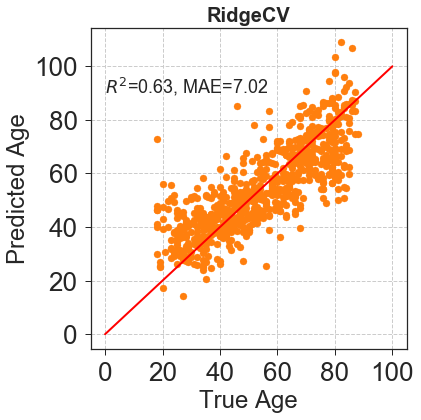

In [61]:
pipeline = make_pipeline(Imputer(), RidgeCV())
y_pred = cross_val_predict(pipeline, X, y, cv=KFold(n_splits=10, shuffle=True,
                                                    random_state=0))

print('R2 score: {}'.format(r2_score(y, y_pred)))
print('Median absolute deviation score: {}'.format(median_absolute_error(y, y_pred)))
plot_results(y, y_pred, 'RidgeCV')

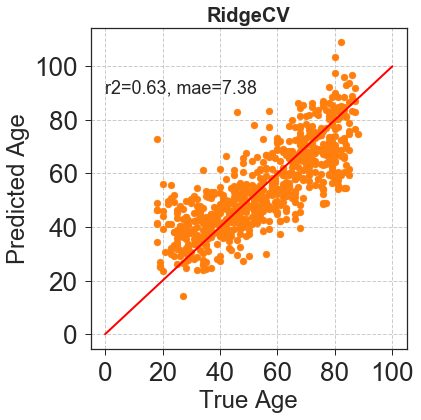

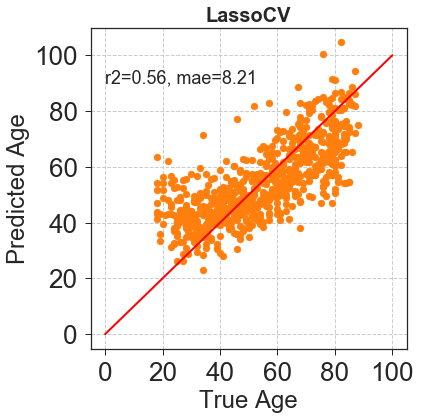

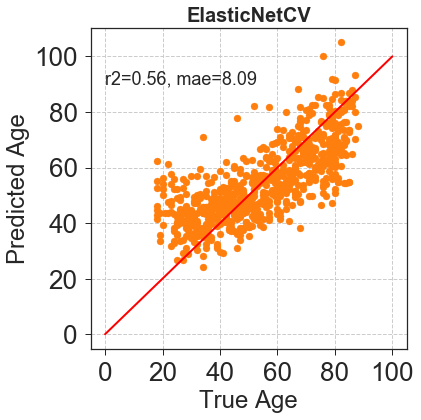

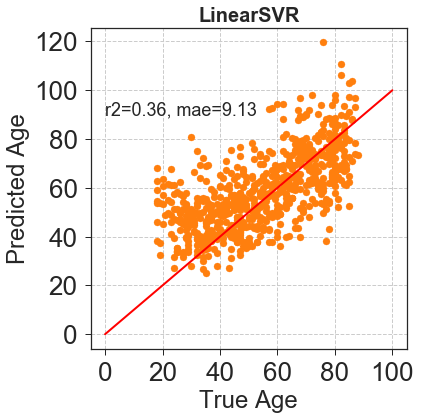

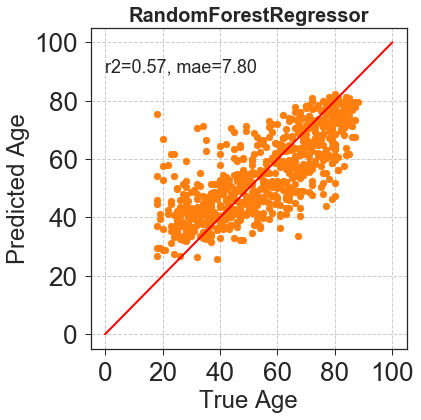

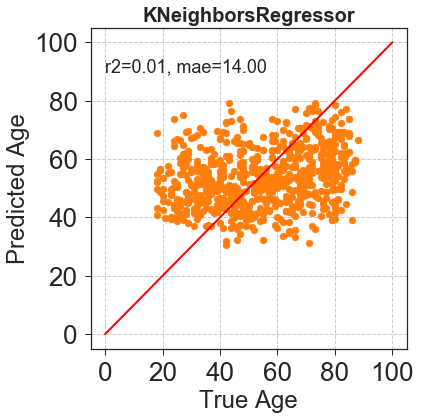

In [38]:
cv = KFold(shuffle=True, random_state=0)
estimators = [RidgeCV(cv=cv),
              LassoCV(cv=cv, random_state=0),
              ElasticNetCV(cv=cv, random_state=0),
              LinearSVR(random_state=0),
              RandomForestRegressor(random_state=0),
              KNeighborsRegressor()]

for estimator in estimators:
    pipeline = make_pipeline(Imputer(), estimator)
    y_pred = cross_val_predict(pipeline, X, y, cv=KFold(n_splits=10, shuffle=True, random_state=0))
    plot_results(y, y_pred, estimator.__class__.__name__)

### Age prediction using univariate feature selection

Load all the data and remove the data link to "HomeInterview" which contain data directly link to the age. In addition, we will keep only numeric features which are non-constant.

In [157]:
dataset = load_camcan_behavioural(path_data, path_participants_info)
X = dataset.data
y = np.array(dataset.scores.age)

# remove home interview
experiment_feature_to_exclude = load_camcan_behavioural_feature(path_exp_feat_map, "HomeInterview")
X = X.drop(list(experiment_feature_to_exclude), axis=1)

# retain only numeric data
X = X.select_dtypes(include=[np.number])
column_names = X.columns
X = Imputer().fit_transform(X)
# remove constant feature
non_contant_feature = np.ones((X.shape[1], ), dtype=bool)
constant_feature = [16, 17, 18, 43, 44, 69, 70, 95, 96, 121, 122, 367, 381, 382, 383, 406, 422, 477,
478, 479, 480, 481, 499, 500, 502, 503, 508, 534, 536, 537, 556, 557, 572, 573, 574, 575,
576, 578, 579, 580, 581, 582, 583, 585, 586, 587, 588, 589, 590, 591, 595, 596, 597, 599,
600, 601, 602, 603, 604]
non_contant_feature[constant_feature] = False
X = X[:, non_contant_feature]
# keep track of the column name to know which feature will be selected
column_names = column_names[non_contant_feature]

Different number of feature will be selected and each time a model will be fitted.
We will repeat 10 times this experiment.

In [69]:
def fit_predict_estimator(pipeline, X, y, k, random_state):
    pipeline.set_params(selectkbest__k=k)
    y_pred = cross_val_predict(pipeline, X, y, cv=KFold(n_splits=10, shuffle=True, random_state=random_state))
    return (r2_score(y, y_pred), median_absolute_error(y, y_pred))

In [ ]:
memory = Memory(cachedir='/home/glemaitre/cache', verbose=0)

cv = KFold(shuffle=True, random_state=0)
estimators = [RidgeCV(cv=cv),
              LassoCV(cv=cv, random_state=0),
              ElasticNetCV(cv=cv, random_state=0),
              RandomForestRegressor(random_state=0, n_estimators=50)]

n_features_range = (10, X.shape[1], 5)

results = []
for n_try in range(10):
    # initialisation for the dictionary
    results_try = {}
    for estimator in estimators:
        results_try[estimator.__class__.__name__] = []
    for estimator in estimators:
        pipeline = Pipeline(memory=memory,
                            steps=[('selectkbest', SelectKBest(f_regression, k=10)),
                                   ('clf', estimator)])
        results_try[estimator.__class__.__name__] += Parallel(n_jobs=-1)(delayed(fit_predict_estimator)
                                                                         (pipeline, X, y, k, n_try) 
                                                                          for k in np.arange(n_features_range[0],
                                                                                             n_features_range[1],
                                                                                             n_features_range[2],
                                                                                             dtype=int))
    results += tuple([results_try])

[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/43ab59d2996c062f135fe39ace26f261
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/1d377a3d2501bc9c62095a29f844fb8c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=20, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  24,
  22,
  20,
  28,
  28,
  23,
  22,
  25,
  18,
  25,
  28,
  20,
  29,
  26,
  28,
  19,
  25,
  25,
  19,
  18,
  28,
  26,
  25,
  20,
  27,
  24,
  23,
  22,
  27,
  28,
  27,
  21,


  37...)
________________________________________________fit_transform_one - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=55, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  24,
  22,
  20,
  28,
  28,
  23,
  22,
  25,
  18,
  25,
  28,
  20,
  29,
  26,
  28,
  19,
  25,
  25,
  19,
  18,
  28,
  26,
  25,
  20,
  27,
  24,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  27,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  24,
  25,
  27,
  26,
  26,
  26,
  20,
  25,
  23,
  27,
  27,
  24,
  31,
  35,
  36,
  35,
  30,
  31,
  30,
  31,
  32,
  34,
  34,
  37,
  34,
  37,
  29,
  32,
  29,
  31,
  30,
  37,
  34,
  33,
  36,
  35,
  34,
  33,
  34,
  29,
  37,
  33,
  31,
  35,
  32,
  30,
  29,
  28,
  32,


  37...)

________________________________________________fit_transform_one - 0.2s, 0.0min
________________________________________________fit_transform_one - 0.1s, 0.0min
________________________________________________fit_transform_one - 0.2s, 0.0min
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/128afcf240bdd5b81e5806fa195d59f3
________________________________________________fit_transform_one - 0.2s, 0.0min
________________________________________________fit_transform_one - 0.3s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=20, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  22,
  20,
  28,
  28,
  23,
  23,
  22,
  18,
  25,
  28,
  25,
  20,
  29,
  19,

  34...)________________________________________________fit_transform_one - 0.2s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=35, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  22,
  20,
  28,
  28,
  23,
  23,
  22,
  18,
  25,
  28,
  25,
  20,
  29,
  19,
  25,
  25,
  19,
  18,
  28,
  26,
  25,
  24,
  20,
  27,
  24,
  28,
  23,
  22,
  27,
  28,
  27,
  18,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  27,
  24,
  18,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  26,
  20,
  25,
  23,
  27,
  24,
  31,
  36,
  35,
  30,
  31,
  30,
  31,
  29,
  34,
  34,
  29,
  37,
  34,
  37,
  29,
  32,
  34,
  29,
  31,
  30,
  37,
  34,
  33,
  36,
  35,
  34,
  33,
  34,
  37,
  33,
  31,
  35,
  32,
  29,
  28,
  32,
  37,
  32,
  36,
 

  37...)________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=135, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  24,
  22,
  20,
  28,
  28,
  23,
  22,
  25,
  18,
  25,
  28,
  20,
  29,
  26,
  28,
  19,
  25,
  25,
  19,
  18,
  28,
  26,
  25,
  20,
  27,
  24,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  27,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  24,
  25,
  27,
  26,
  26,
  26,
  20,
  25,
  23,
  27,
  27,
  24,
  31,
  35,
  36,
  35,
  30,
  31,
  30,
  31,
  32,
  34,
  34,
  37,
  34,
  37,
  29,
  32,
  29,
  31,
  30,
  37,
  34,
  33,
  36,
  35,
  34,
  33,
  34,
  29,
  37,
  33,
  31,
  35,
  32,
  30,
  29,
  28,
  32,
  37,
  32,
  36,
  35,
  33,
  35,
  33,
  37,
  35,
  34,
  37,
  37,
  37,
  3

  29...)[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/a421392e44d6043bd58019ace1d4435f
________________________________________________fit_transform_one - 0.1s, 0.0min

___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=55, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  22,
  20,
  28,
  28,
  23,
  23,
  22,
  18,
  25,
  28,
  25,
  20,
  29,
  19,
  25,
  25,
  19,
  18,
  28,
  26,
  25,
  24,
  20,
  27,
  24,
  28,
  23,
  22,
  27,
  28,
  27,
  18,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  27,
  24,
  18,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  26,
  20,
  25,
  23,
  27,
  2

  34...)
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=165, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  24,
  22,
  20,
  28,
  28,
  23,
  22,
  25,
  18,
  25,
  28,
  20,
  29,
  26,
  28,
  19,
  25,
  25,
  19,
  18,
  28,
  26,
  25,
  20,
  27,
  24,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  27,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  24,
  25,
  27,
  26,
  26,
  26,
  20,
  25,
  23,
  27,
  27,
  24,
  31,
  35,
  36,
  35,
  30,
  31,
  30,
  31,
  32,
  34,
  34,
  37,
  34,
  37,
  29,
  32,
  29,
  31,
  30,
  37,
  34,
  33,
  36,
  35,
  34,
  33,
  34,
  29,
  37,
  33,
  31,
  35,
  32,
  30,
  29,
  28,
  32,
  37,
  32,
  36,
  35,
  33,
  35,
  33,
  37,
  35,
  34,
  37,
  37,
  37,
  

  37...)
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=65, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  22,
  20,
  28,
  28,
  23,
  23,
  22,
  18,
  25,
  28,
  25,
  20,
  29,
  19,
  25,
  25,
  19,
  18,
  28,
  26,
  25,
  24,
  20,
  27,
  24,
  28,
  23,
  22,
  27,
  28,
  27,
  18,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  27,
  24,
  18,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  26,
  20,
  25,
  23,
  27,
  24,
  31,
  36,
  35,
  30,
  31,
  30,
  31,
  29,
  34,
  34,
  29,
  37,
  34,
  37,
  29,
  32,
  34,
  29,
  31,
  30,
  37,
  34,
  33,
  36,
  35,
  34,
  33,
  34,
  37,
  33,
  31,
  35,
  32,
  29,
  28,
  32,
  37,
  32,
  36,
  35,
  33,
  35,
  37,
  35,
  34,
  37,
  37,
  37,
  38,
  28,
  29,
  36,
  3

  34...)________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=90, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  22,
  20,
  28,
  28,
  23,
  23,
  22,
  18,
  25,
  28,
  25,
  20,
  29,
  19,
  25,
  25,
  19,
  18,
  28,
  26,
  25,
  24,
  20,
  27,
  24,
  28,
  23,
  22,
  27,
  28,
  27,
  18,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  27,
  24,
  18,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  26,
  20,
  25,
  23,
  27,
  24,
  31,
  36,
  35,
  30,
  31,
  30,
  31,
  29,
  34,
  34,
  29,
  37,
  34,
  37,
  29,
  32,
  34,
  29,
  31,
  30,
  37,
  34,
  33,
  36,
  35,
  34,
  33,
  34,
  37,
  33,
  31,
  35,
  32,
  29,
  28,
  32,
  37,
  32,
  36,
  35,
  33,
  35,
  37,
  35,
  34,
  37,
  37,
  37,
  38,
  28,
  29,
  36,
  31

________________________________________________fit_transform_one - 0.5s, 0.0min
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
________________________________________________fit_transform_one - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=210, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  24,
  22,
  20,
  28,
  28,
  23,
  22,
  25,
  18,
  25,
  28,
  20,
  29,
  26,
  28,
  19,
  25,
  25,
  19,
  18,
  28,
  26,
  25,
  20,
  27,
  24,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  27,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  24,
  25,
  27,
  26,
  26,
  26,
  20,
  25,
  23,
  27,
  27,
  24,
  31,
  35,
  36,
  35,
  30,
  31,
  30,
  31,
  32,
  34,
  34,
  

  37...)
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=60, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  22,
  20,
  28,
  28,
  23,
  23,
  22,
  25,
  18,
  28,
  25,
  20,
  29,
  26,
  28,
  19,
  25,
  19,
  18,
  28,
  26,
  25,
  24,
  20,
  27,
  24,
  28,
  23,
  22,
  27,
  21,
  18,
  18,
  18,
  25,
  28,
  19,
  26,
  27,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  26,
  20,
  23,
  27,
  27,
  24,
  31,
  35,
  36,
  35,
  30,
  31,
  30,
  31,
  29,
  32,
  29,
  37,
  34,
  37,
  29,
  32,
  34,
  29,
  31,
  30,
  37,
  34,
  33,
  35,
  34,
  33,
  34,
  29,
  37,
  33,
  31,
  32,
  30,
  29,
  28,
  32,
  37,
  32,
  36,
  35,
  33,
  35,
  33,
  37,
  35,
  34,
  37,
  37,
  37,
  3

  36...)________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=55, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  30.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 18,
  24,
  22,
  20,
  28,
  23,
  23,
  22,
  25,
  18,
  25,
  28,
  25,
  29,
  26,
  28,
  19,
  25,
  25,
  19,
  18,
  28,
  26,
  25,
  24,
  20,
  27,
  24,
  28,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  26,
  20,
  25,
  23,
  27,
  27,
  31,
  35,
  36,
  35,
  31,
  30,
  31,
  29,
  32,
  34,
  34,
  29,
  37,
  34,
  37,
  29,
  32,
  34,
  29,
  31,
  30,
  33,
  36,
  35,
  34,
  33,
  29,
  37,
  33,
  31,
  35,
  32,
  30,
  28,
  32,
  32,
  35,
  33,
  35,
  33,
  37,
  35,
  34,
  37,
  37,
  38,
  28,
  29,
  36

  34...)________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=20, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  20,
  28,
  28,
  23,
  22,
  25,
  18,
  25,
  28,
  25,
  20,
  29,
  26,
  28,
  19,
  25,
  19,
  18,
  28,
  26,
  24,
  20,
  27,
  28,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  27,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  26,
  27,
  26,
  26,
  20,
  25,
  23,
  27,
  24,
  31,
  35,
  36,
  35,
  30,
  31,
  30,
  31,
  29,
  32,
  34,
  34,
  29,
  37,
  34,
  37,
  29,
  32,
  34,
  29,
  31,
  30,
  37,
  34,
  33,
  36,
  35,
  34,
  33,
  34,
  29,
  37,
  33,
  35,
  30,
  29,
  28,
  32,
  37,
  36,
  35,
  33,
  33,
  37,
  35,
  34,
  37,
  37,
  37,
  38,
  28,
  29,
  36

  29...)
________________________________________________fit_transform_one - 0.6s, 0.0min

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=65, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  22,
  20,
  28,
  28,
  23,
  23,
  22,
  25,
  18,
  28,
  25,
  20,
  29,
  26,
  28,
  19,
  25,
  19,
  18,
  28,
  26,
  25,
  24,
  20,
  27,
  24,
  28,
  23,
  22,
  27,
  21,
  18,
  18,
  18,
  25,
  28,
  19,
  26,
  27,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  26,
  20,
  23,
  27,
  27,
  24,
  31,
  35,
  36,
  35,
  30,
  31,
  30,
  31,
  29,
  32,
  29,
  37,
  34,
  37,
  29,
  32,
  34,
  29,
  31,
  30,
  37,
  34,
  33,
  35,
  34,
  33,
  34,
  29,
  37,
  33,
  31,
  32,
  30,
  29,
  28,
  32,

  34...)________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=165, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  22,
  20,
  28,
  28,
  23,
  23,
  22,
  18,
  25,
  28,
  25,
  20,
  29,
  19,
  25,
  25,
  19,
  18,
  28,
  26,
  25,
  24,
  20,
  27,
  24,
  28,
  23,
  22,
  27,
  28,
  27,
  18,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  27,
  24,
  18,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  26,
  20,
  25,
  23,
  27,
  24,
  31,
  36,
  35,
  30,
  31,
  30,
  31,
  29,
  34,
  34,
  29,
  37,
  34,
  37,
  29,
  32,
  34,
  29,
  31,
  30,
  37,
  34,
  33,
  36,
  35,
  34,
  33,
  34,
  37,
  33,
  31,
  35,
  32,
  29,
  28,
  32,
  37,
  32,
  36,
  35,
  33,
  35,
  37,
  35,
  34,
  37,
  37,
  37,
  38,
  28,
  29,
  36,
  3

  36...)

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=190, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  22,
  20,
  28,
  28,
  23,
  23,
  22,
  18,
  25,
  28,
  25,
  20,
  29,
  19,
  25,
  25,
  19,
  18,
  28,
  26,
  25,
  24,
  20,
  27,
  24,
  28,
  23,
  22,
  27,
  28,
  27,
  18,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  27,
  24,
  18,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  26,
  20,
  25,
  23,
  27,
  24,
  31,
  36,
  35,
  30,
  31,
  30,
  31,
  29,
  34,
  34,
  29,
  37,
  34,
  37,
  29,
  32,
  34,
  29,
  31,
  30,
  37,
  34,
  33,
  36,
  35,
  34,
  33,
  34,
  37,
  33,
  31,
  35,
  32,
  29,
  28,
  32,
  37,
  32,
  36,
  35,
  33,
  35,
  37,
  35,
  34,
  37,
  37,
  37,
  38,
  28,
  29,
  36,
 

  34...)
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=55, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  22,
  28,
  23,
  23,
  22,
  25,
  18,
  25,
  25,
  20,
  29,
  26,
  28,
  19,
  25,
  25,
  18,
  28,
  26,
  25,
  24,
  20,
  27,
  24,
  28,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  27,
  24,
  23,
  20,
  28,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  20,
  25,
  23,
  27,
  27,
  24,
  31,
  35,
  36,
  35,
  30,
  31,
  30,
  29,
  32,
  34,
  34,
  29,
  37,
  37,
  29,
  32,
  34,
  29,
  31,
  30,
  37,
  34,
  33,
  36,
  35,
  34,
  33,
  34,
  29,
  37,
  33,
  31,
  35,
  32,
  30,
  29,
  28,
  32,
  37,
  32,
  36,
  35,
  33,
  35,
  33,
  37,
  35,
  34,
  37,
  37,
  3


________________________________________________fit_transform_one - 0.5s, 0.0min

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=35, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  22,
  20,
  28,
  28,
  23,
  23,
  22,
  25,
  18,
  25,
  28,
  25,
  20,
  26,
  28,
  19,
  25,
  25,
  19,
  18,
  28,
  26,
  25,
  24,
  20,
  24,
  28,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  27,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  26,
  20,
  25,
  27,
  27,
  24,
  31,
  35,
  35,
  30,
  31,
  30,
  31,
  29,
  32,
  34,
  34,
  29,
  37,
  34,
  37,
  32,
  34,
  29,
  31,
  30,
  37,
  34,
  33,
  36,
  34,
  33,
  34,
  29,
  37,
  33,
  31,
  35,
  32,
  30,
  29,
  37,
 

  37...)
________________________________________________fit_transform_one - 0.6s, 0.0min
________________________________________________fit_transform_one - 0.7s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=155, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  22,
  20,
  28,
  28,
  23,
  23,
  22,
  25,
  18,
  28,
  25,
  20,
  29,
  26,
  28,
  19,
  25,
  19,
  18,
  28,
  26,
  25,
  24,
  20,
  27,
  24,
  28,
  23,
  22,
  27,
  21,
  18,
  18,
  18,
  25,
  28,
  19,
  26,
  27,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  26,
  20,
  23,
  27,
  27,
  24,
  31,
  35,
  36,
  35,
  30,
  31,
  30,
  31,
  29,
  32,
  29,
  37,
  34,
  37,
  29,
  32,
  34,
  29,
  31,
  30,
  37,
  34,
  

  36...)________________________________________________fit_transform_one - 0.2s, 0.0min



________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=25, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  22,
  20,
  28,
  28,
  23,
  23,
  22,
  25,
  18,
  25,
  28,
  25,
  20,
  26,
  28,
  19,
  25,
  25,
  19,
  18,
  28,
  26,
  25,
  24,
  20,
  24,
  28,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  27,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  26,
  20,
  25,
  27,
  27,
  24,
  31,
  35,
  35,
  30,
  31,
  30,
  31,
  29,
  32,
  34,
  34,
  29,
  37,
  34,
  37,
  32,
  34,
  29,
  31,
  30,
  37,
  34,
  33,
  36,
  34,
  33,
  34,
  29,
  37,
  33,
  31,
  35,
  32,
  30,
  29

  29...)________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=105, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  22,
  20,
  28,
  28,
  23,
  23,
  22,
  25,
  18,
  28,
  25,
  20,
  29,
  26,
  28,
  19,
  25,
  19,
  18,
  28,
  26,
  25,
  24,
  20,
  27,
  24,
  28,
  23,
  22,
  27,
  21,
  18,
  18,
  18,
  25,
  28,
  19,
  26,
  27,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  26,
  20,
  23,
  27,
  27,
  24,
  31,
  35,
  36,
  35,
  30,
  31,
  30,
  31,
  29,
  32,
  29,
  37,
  34,
  37,
  29,
  32,
  34,
  29,
  31,
  30,
  37,
  34,
  33,
  35,
  34,
  33,
  34,
  29,
  37,
  33,
  31,
  32,
  30,
  29,
  28,
  32,
  37,
  32,
  36,
  35,
  33,
  35,
  33,
  37,
  35,
  34,
  37,
  37,
  37,
  3

  32...)
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=130, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  22,
  20,
  28,
  28,
  23,
  23,
  22,
  25,
  18,
  28,
  25,
  20,
  29,
  26,
  28,
  19,
  25,
  19,
  18,
  28,
  26,
  25,
  24,
  20,
  27,
  24,
  28,
  23,
  22,
  27,
  21,
  18,
  18,
  18,
  25,
  28,
  19,
  26,
  27,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  26,
  20,
  23,
  27,
  27,
  24,
  31,
  35,
  36,
  35,
  30,
  31,
  30,
  31,
  29,
  32,
  29,
  37,
  34,
  37,
  29,
  32,
  34,
  29,
  31,
  30,
  37,
  34,
  33,
  35,
  34,
  33,
  34,
  29,
  37,
  33,
  31,
  32,
  30,
  29,
  28,
  32,
  37,
  32,
  36,
  35,
  33,
  35,
  33,
  37,
  35,
  34,
  37,
  37,
  37,
  

  37...)

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=50, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  22,
  20,
  28,
  28,
  23,
  23,
  22,
  25,
  18,
  25,
  28,
  25,
  20,
  29,
  26,
  28,
  19,
  25,
  25,
  19,
  18,
  25,
  24,
  20,
  27,
  24,
  28,
  23,
  27,
  28,
  27,
  21,
  18,
  18,
  18,
  25,
  28,
  19,
  23,
  27,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  26,
  25,
  23,
  27,
  27,
  24,
  35,
  36,
  35,
  30,
  31,
  31,
  29,
  32,
  34,
  34,
  29,
  37,
  34,
  37,
  29,
  32,
  34,
  29,
  31,
  37,
  34,
  33,
  36,
  35,
  34,
  33,
  34,
  29,
  37,
  33,
  31,
  35,
  32,
  30,
  29,
  28,
  32,
  37,
  32,
  36,
  35,
  33,
  37,
  35,
  34,
  37,
  37,
  38,
  

  36...)

________________________________________________fit_transform_one - 0.6s, 0.0min

________________________________________________fit_transform_one - 0.6s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=165, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  22,
  20,
  28,
  28,
  23,
  23,
  22,
  25,
  18,
  28,
  25,
  20,
  29,
  26,
  28,
  19,
  25,
  19,
  18,
  28,
  26,
  25,
  24,
  20,
  27,
  24,
  28,
  23,
  22,
  27,
  21,
  18,
  18,
  18,
  25,
  28,
  19,
  26,
  27,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  26,
  20,
  23,
  27,
  27,
  24,
  31,
  35,
  36,
  35,
  30,
  31,
  30,
  31,
  29,
  32,
  29,
  37,
  34,
  37,
  29,
  32,
  34,
  29,
  31,
  30,
  37,
  34,


  36...)________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=120, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  30.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 18,
  24,
  22,
  20,
  28,
  23,
  23,
  22,
  25,
  18,
  25,
  28,
  25,
  29,
  26,
  28,
  19,
  25,
  25,
  19,
  18,
  28,
  26,
  25,
  24,
  20,
  27,
  24,
  28,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  26,
  20,
  25,
  23,
  27,
  27,
  31,
  35,
  36,
  35,
  31,
  30,
  31,
  29,
  32,
  34,
  34,
  29,
  37,
  34,
  37,
  29,
  32,
  34,
  29,
  31,
  30,
  33,
  36,
  35,
  34,
  33,
  29,
  37,
  33,
  31,
  35,
  32,
  30,
  28,
  32,
  32,
  35,
  33,
  35,
  33,
  37,
  35,
  34,
  37,
  37,
  38,
  28,
  29,
  3

  36...)
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=50, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  0.      , ...,  27.      ]]), 
[ 24,
  18,
  24,
  22,
  20,
  28,
  28,
  23,
  23,
  22,
  25,
  25,
  28,
  25,
  20,
  29,
  26,
  28,
  25,
  25,
  19,
  28,
  26,
  25,
  24,
  20,
  27,
  24,
  28,
  22,
  27,
  28,
  21,
  18,
  18,
  18,
  28,
  26,
  23,
  27,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  20,
  25,
  23,
  27,
  27,
  24,
  31,
  35,
  36,
  35,
  30,
  31,
  30,
  31,
  29,
  32,
  34,
  34,
  29,
  34,
  37,
  29,
  32,
  34,
  31,
  30,
  37,
  34,
  33,
  36,
  35,
  34,
  29,
  33,
  31,
  35,
  32,
  30,
  29,
  28,
  32,
  37,
  32,
  36,
  35,
  33,
  35,
  33,
  37,
  35,
  34,
  37,
  37,
  37,
  38,
  28,
  29,
  3

  37...)________________________________________________fit_transform_one - 0.8s, 0.0min


________________________________________________fit_transform_one - 0.6s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=200, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  22,
  20,
  28,
  28,
  23,
  23,
  22,
  25,
  18,
  28,
  25,
  20,
  29,
  26,
  28,
  19,
  25,
  19,
  18,
  28,
  26,
  25,
  24,
  20,
  27,
  24,
  28,
  23,
  22,
  27,
  21,
  18,
  18,
  18,
  25,
  28,
  19,
  26,
  27,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  26,
  20,
  23,
  27,
  27,
  24,
  31,
  35,
  36,
  35,
  30,
  31,
  30,
  31,
  29,
  32,
  29,
  37,
  34,
  37,
  29,
  32,
  34,
  29,
  31,
  30,
  37,
  34,
 

  29...)________________________________________________fit_transform_one - 0.6s, 0.0min


________________________________________________fit_transform_one - 0.7s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=35, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  22,
  20,
  28,
  28,
  23,
  23,
  25,
  18,
  25,
  28,
  25,
  20,
  29,
  26,
  28,
  19,
  25,
  25,
  19,
  18,
  28,
  26,
  25,
  24,
  27,
  24,
  28,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  18,
  25,
  19,
  26,
  23,
  27,
  23,
  20,
  28,
  18,
  26,
  24,
  26,
  25,
  26,
  26,
  26,
  20,
  25,
  23,
  27,
  27,
  24,
  31,
  35,
  36,
  30,
  30,
  31,
  29,
  32,
  34,
  34,
  29,
  37,
  34,
  29,
  34,
  29,
  30,
  37,
  34,
  36,
  35,
  34,
  

  35...)________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=20, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  0.      , ...,  27.      ]]), 
[ 24,
  18,
  24,
  22,
  20,
  28,
  28,
  23,
  23,
  22,
  25,
  25,
  28,
  25,
  20,
  29,
  26,
  28,
  25,
  25,
  19,
  28,
  26,
  25,
  24,
  20,
  27,
  24,
  28,
  22,
  27,
  28,
  21,
  18,
  18,
  18,
  28,
  26,
  23,
  27,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  20,
  25,
  23,
  27,
  27,
  24,
  31,
  35,
  36,
  35,
  30,
  31,
  30,
  31,
  29,
  32,
  34,
  34,
  29,
  34,
  37,
  29,
  32,
  34,
  31,
  30,
  37,
  34,
  33,
  36,
  35,
  34,
  29,
  33,
  31,
  35,
  32,
  30,
  29,
  28,
  32,
  37,
  32,
  36,
  35,
  33,
  35,
  33,
  37,
  35,
  34,
  37,
  37,
  37,
  38,
  28,
  29,
  31

  36...)________________________________________________fit_transform_one - 0.2s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=140, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  20,
  28,
  28,
  23,
  22,
  25,
  18,
  25,
  28,
  25,
  20,
  29,
  26,
  28,
  19,
  25,
  19,
  18,
  28,
  26,
  24,
  20,
  27,
  28,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  27,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  26,
  27,
  26,
  26,
  20,
  25,
  23,
  27,
  24,
  31,
  35,
  36,
  35,
  30,
  31,
  30,
  31,
  29,
  32,
  34,
  34,
  29,
  37,
  34,
  37,
  29,
  32,
  34,
  29,
  31,
  30,
  37,
  34,
  33,
  36,
  35,
  34,
  33,
  34,
  29,
  37,
  33,
  35,
  30,
  29,
  28,
  32,
  37,



________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=165, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  30.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 18,
  24,
  22,
  20,
  28,
  23,
  23,
  22,
  25,
  18,
  25,
  28,
  25,
  29,
  26,
  28,
  19,
  25,
  25,
  19,
  18,
  28,
  26,
  25,
  24,
  20,
  27,
  24,
  28,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  26,
  20,
  25,
  23,
  27,
  27,
  31,
  35,
  36,
  35,
  31,
  30,
  31,
  29,
  32,
  34,
  34,
  29,
  37,
  34,
  37,
  29,
  32,
  34,
  29,
  31,
  30,
  33,
  36,
  35,
  34,
  33,
  29,
  37,
  33,
  31,
  35,
  32,
  30,
  28,
  32,
  32,
  35,
  33,
  35,
  33,
  37,
  35,
  34,
  37,
  37,
  38,
  28,
  29,
  36,
  31

  35...)________________________________________________fit_transform_one - 0.4s, 0.0min

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=80, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  22,
  28,
  23,
  23,
  22,
  25,
  18,
  25,
  25,
  20,
  29,
  26,
  28,
  19,
  25,
  25,
  18,
  28,
  26,
  25,
  24,
  20,
  27,
  24,
  28,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  27,
  24,
  23,
  20,
  28,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  20,
  25,
  23,
  27,
  27,
  24,
  31,
  35,
  36,
  35,
  30,
  31,
  30,
  29,
  32,
  34,
  34,
  29,
  37,
  37,
  29,
  32,
  34,
  29,
  31,
  30,
  37,
  34,
  33,
  36,
  35,
  34,
  33,
  34,
  29,
  37,
  33,
  31,
  35,
  32,
  30,
  29,
  28,


  36...)
________________________________________________fit_transform_one - 0.6s, 0.0min

________________________________________________fit_transform_one - 0.4s, 0.0min
________________________________________________fit_transform_one - 0.6s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=150, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  30.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 18,
  24,
  22,
  20,
  28,
  23,
  23,
  22,
  25,
  18,
  25,
  28,
  25,
  29,
  26,
  28,
  19,
  25,
  25,
  19,
  18,
  28,
  26,
  25,
  24,
  20,
  27,
  24,
  28,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  26,
  20,
  25,
  23,
  27,
  27,
  31,
  35,
  36,
  35,
  31,
  30,
  31,
  29

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=75, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  20,
  28,
  28,
  23,
  22,
  25,
  18,
  25,
  28,
  25,
  20,
  29,
  26,
  28,
  19,
  25,
  19,
  18,
  28,
  26,
  24,
  20,
  27,
  28,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  27,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  26,
  27,
  26,
  26,
  20,
  25,
  23,
  27,
  24,
  31,
  35,
  36,
  35,
  30,
  31,
  30,
  31,
  29,
  32,
  34,
  34,
  29,
  37,
  34,
  37,
  29,
  32,
  34,
  29,
  31,
  30,
  37,
  34,
  33,
  36,
  35,
  34,
  33,
  34,
  29,
  37,
  33,
  35,
  30,
  29,
  28,
  32,
  37,
  36,
  35,
  33,
  33,
  37,
  35,
  34,
  37,
  37,
  37,
  38,
  28,
  29,
  36,
  31,


  37...)
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=245, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  30.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 18,
  24,
  22,
  20,
  28,
  23,
  23,
  22,
  25,
  18,
  25,
  28,
  25,
  29,
  26,
  28,
  19,
  25,
  25,
  19,
  18,
  28,
  26,
  25,
  24,
  20,
  27,
  24,
  28,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  26,
  20,
  25,
  23,
  27,
  27,
  31,
  35,
  36,
  35,
  31,
  30,
  31,
  29,
  32,
  34,
  34,
  29,
  37,
  34,
  37,
  29,
  32,
  34,
  29,
  31,
  30,
  33,
  36,
  35,
  34,
  33,
  29,
  37,
  33,
  31,
  35,
  32,
  30,
  28,
  32,
  32,
  35,
  33,
  35,
  33,
  37,
  35,
  34,
  37,
  37,
  38,
  28,
  29,
  

  36...)________________________________________________fit_transform_one - 0.6s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=110, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  22,
  28,
  23,
  23,
  22,
  25,
  18,
  25,
  25,
  20,
  29,
  26,
  28,
  19,
  25,
  25,
  18,
  28,
  26,
  25,
  24,
  20,
  27,
  24,
  28,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  27,
  24,
  23,
  20,
  28,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  20,
  25,
  23,
  27,
  27,
  24,
  31,
  35,
  36,
  35,
  30,
  31,
  30,
  29,
  32,
  34,
  34,
  29,
  37,
  37,
  29,
  32,
  34,
  29,
  31,
  30,
  37,
  34,
  33,
  36,
  35,
  34,
  33,
  34,
  29,
  37,
  33,
  31,
  35,
  32,
  30,
  29,
  28,


  37...)________________________________________________fit_transform_one - 0.5s, 0.0min

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=250, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  22,
  20,
  28,
  28,
  23,
  23,
  22,
  25,
  18,
  28,
  25,
  20,
  29,
  26,
  28,
  19,
  25,
  19,
  18,
  28,
  26,
  25,
  24,
  20,
  27,
  24,
  28,
  23,
  22,
  27,
  21,
  18,
  18,
  18,
  25,
  28,
  19,
  26,
  27,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  26,
  20,
  23,
  27,
  27,
  24,
  31,
  35,
  36,
  35,
  30,
  31,
  30,
  31,
  29,
  32,
  29,
  37,
  34,
  37,
  29,
  32,
  34,
  29,
  31,
  30,
  37,
  34,
  33,
  35,
  34,
  33,
  34,
  29,
  37,
  33,
  31,
  32,
  30,
  29,
  28,
  32,

  37...)

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=215, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  30.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 18,
  24,
  22,
  20,
  28,
  23,
  23,
  22,
  25,
  18,
  25,
  28,
  25,
  29,
  26,
  28,
  19,
  25,
  25,
  19,
  18,
  28,
  26,
  25,
  24,
  20,
  27,
  24,
  28,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  26,
  20,
  25,
  23,
  27,
  27,
  31,
  35,
  36,
  35,
  31,
  30,
  31,
  29,
  32,
  34,
  34,
  29,
  37,
  34,
  37,
  29,
  32,
  34,
  29,
  31,
  30,
  33,
  36,
  35,
  34,
  33,
  29,
  37,
  33,
  31,
  35,
  32,
  30,
  28,
  32,
  32,
  35,
  33,
  35,
  33,
  37,
  35,
  34,
  37,
  37,
  38,
  28,
  29,
 

  34...)
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=280, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  22,
  20,
  28,
  28,
  23,
  23,
  22,
  18,
  25,
  28,
  25,
  20,
  29,
  19,
  25,
  25,
  19,
  18,
  28,
  26,
  25,
  24,
  20,
  27,
  24,
  28,
  23,
  22,
  27,
  28,
  27,
  18,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  27,
  24,
  18,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  26,
  20,
  25,
  23,
  27,
  24,
  31,
  36,
  35,
  30,
  31,
  30,
  31,
  29,
  34,
  34,
  29,
  37,
  34,
  37,
  29,
  32,
  34,
  29,
  31,
  30,
  37,
  34,
  33,
  36,
  35,
  34,
  33,
  34,
  37,
  33,
  31,
  35,
  32,
  29,
  28,
  32,
  37,
  32,
  36,
  35,
  33,
  35,
  37,
  35,
  34,
  37,
  37,
  37,
  38,
  28,
  29,
  36,
  

  37...)


________________________________________________fit_transform_one - 0.6s, 0.0min
________________________________________________fit_transform_one - 0.5s, 0.0min

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=165, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  20,
  28,
  28,
  23,
  22,
  25,
  18,
  25,
  28,
  25,
  20,
  29,
  26,
  28,
  19,
  25,
  19,
  18,
  28,
  26,
  24,
  20,
  27,
  28,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  27,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  26,
  27,
  26,
  26,
  20,
  25,
  23,
  27,
  24,
  31,
  35,
  36,
  35,
  30,
  31,
  30,
  31,
  29,
  32,
  34,
  34,
  29,
  37,
  34,
  37,
  29,
  32,
  34,
  29,
  31,
  30,
  37,
  34,
  33,

  37...)
________________________________________________fit_transform_one - 0.5s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=240, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  20,
  28,
  28,
  23,
  22,
  25,
  18,
  25,
  28,
  25,
  20,
  29,
  26,
  28,
  19,
  25,
  19,
  18,
  28,
  26,
  24,
  20,
  27,
  28,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  27,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  26,
  27,
  26,
  26,
  20,
  25,
  23,
  27,
  24,
  31,
  35,
  36,
  35,
  30,
  31,
  30,
  31,
  29,
  32,
  34,
  34,
  29,
  37,
  34,
  37,
  29,
  32,
  34,
  29,
  31,
  30,
  37,
  34,
  33,
  36,
  35,
  34,
  33,
  34,
  29,
  37,
  33,
  35,
  30,
  29,
  28,
  32,
  37,

  32...)________________________________________________fit_transform_one - 0.7s, 0.0min
________________________________________________fit_transform_one - 0.6s, 0.0min

________________________________________________fit_transform_one - 0.7s, 0.0min



________________________________________________fit_transform_one - 0.7s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=130, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  22,
  28,
  23,
  23,
  22,
  25,
  18,
  25,
  25,
  20,
  29,
  26,
  28,
  19,
  25,
  25,
  18,
  28,
  26,
  25,
  24,
  20,
  27,
  24,
  28,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  27,
  24,
  23,
  20,
  28,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  20,
  25,

  32...)
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=210, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  22,
  28,
  23,
  23,
  22,
  25,
  18,
  25,
  25,
  20,
  29,
  26,
  28,
  19,
  25,
  25,
  18,
  28,
  26,
  25,
  24,
  20,
  27,
  24,
  28,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  27,
  24,
  23,
  20,
  28,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  20,
  25,
  23,
  27,
  27,
  24,
  31,
  35,
  36,
  35,
  30,
  31,
  30,
  29,
  32,
  34,
  34,
  29,
  37,
  37,
  29,
  32,
  34,
  29,
  31,
  30,
  37,
  34,
  33,
  36,
  35,
  34,
  33,
  34,
  29,
  37,
  33,
  31,
  35,
  32,
  30,
  29,
  28,
  32,
  37,
  32,
  36,
  35,
  33,
  35,
  33,
  37,
  35,
  34,
  37,
  37,
  

  37...)________________________________________________fit_transform_one - 0.8s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=250, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  30.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 18,
  24,
  22,
  20,
  28,
  23,
  23,
  22,
  25,
  18,
  25,
  28,
  25,
  29,
  26,
  28,
  19,
  25,
  25,
  19,
  18,
  28,
  26,
  25,
  24,
  20,
  27,
  24,
  28,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  26,
  20,
  25,
  23,
  27,
  27,
  31,
  35,
  36,
  35,
  31,
  30,
  31,
  29,
  32,
  34,
  34,
  29,
  37,
  34,
  37,
  29,
  32,
  34,
  29,
  31,
  30,
  33,
  36,
  35,
  34,
  33,
  29,
  37,
  33,
  31,
  35,
  32,
  30,
  28,
  32,


  32...)________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=150, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  22,
  28,
  23,
  23,
  22,
  25,
  18,
  25,
  25,
  20,
  29,
  26,
  28,
  19,
  25,
  25,
  18,
  28,
  26,
  25,
  24,
  20,
  27,
  24,
  28,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  27,
  24,
  23,
  20,
  28,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  20,
  25,
  23,
  27,
  27,
  24,
  31,
  35,
  36,
  35,
  30,
  31,
  30,
  29,
  32,
  34,
  34,
  29,
  37,
  37,
  29,
  32,
  34,
  29,
  31,
  30,
  37,
  34,
  33,
  36,
  35,
  34,
  33,
  34,
  29,
  37,
  33,
  31,
  35,
  32,
  30,
  29,
  28,
  32,
  37,
  32,
  36,
  35,
  33,
  35,
  33,
  37,
  35,
  34,
  37,
  37,
  3

  32...)
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=220, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  22,
  28,
  23,
  23,
  22,
  25,
  18,
  25,
  25,
  20,
  29,
  26,
  28,
  19,
  25,
  25,
  18,
  28,
  26,
  25,
  24,
  20,
  27,
  24,
  28,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  27,
  24,
  23,
  20,
  28,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  20,
  25,
  23,
  27,
  27,
  24,
  31,
  35,
  36,
  35,
  30,
  31,
  30,
  29,
  32,
  34,
  34,
  29,
  37,
  37,
  29,
  32,
  34,
  29,
  31,
  30,
  37,
  34,
  33,
  36,
  35,
  34,
  33,
  34,
  29,
  37,
  33,
  31,
  35,
  32,
  30,
  29,
  28,
  32,
  37,
  32,
  36,
  35,
  33,
  35,
  33,
  37,
  35,
  34,
  37,
  37,
  

  37...)________________________________________________fit_transform_one - 0.6s, 0.0min
________________________________________________fit_transform_one - 0.5s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=195, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  22,
  28,
  23,
  23,
  22,
  25,
  18,
  25,
  25,
  20,
  29,
  26,
  28,
  19,
  25,
  25,
  18,
  28,
  26,
  25,
  24,
  20,
  27,
  24,
  28,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  27,
  24,
  23,
  20,
  28,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  20,
  25,
  23,
  27,
  27,
  24,
  31,
  35,
  36,
  35,
  30,
  31,
  30,
  29,
  32,
  34,
  34,
  29,
  37,
  37,
  29,
  32,
  34,
  29,
  31,
  30,
  37,
  34,
  33,
  3

  32...)________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=85, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  22,
  20,
  28,
  28,
  23,
  23,
  25,
  18,
  25,
  28,
  25,
  20,
  29,
  26,
  28,
  19,
  25,
  25,
  19,
  18,
  28,
  26,
  25,
  24,
  27,
  24,
  28,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  18,
  25,
  19,
  26,
  23,
  27,
  23,
  20,
  28,
  18,
  26,
  24,
  26,
  25,
  26,
  26,
  26,
  20,
  25,
  23,
  27,
  27,
  24,
  31,
  35,
  36,
  30,
  30,
  31,
  29,
  32,
  34,
  34,
  29,
  37,
  34,
  29,
  34,
  29,
  30,
  37,
  34,
  36,
  35,
  34,
  33,
  34,
  29,
  37,
  31,
  35,
  32,
  30,
  29,
  28,
  32,
  37,
  32,
  36,
  35,
  33,
  35,
  33,
  37,
  34,
  37,
  37,
  38,
  28,
  29,
  36,
  31,
  35

  32...)
________________________________________________fit_transform_one - 0.4s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=145, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  22,
  20,
  28,
  28,
  23,
  23,
  22,
  25,
  18,
  25,
  28,
  25,
  20,
  26,
  28,
  19,
  25,
  25,
  19,
  18,
  28,
  26,
  25,
  24,
  20,
  24,
  28,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  27,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  26,
  20,
  25,
  27,
  27,
  24,
  31,
  35,
  35,
  30,
  31,
  30,
  31,
  29,
  32,
  34,
  34,
  29,
  37,
  34,
  37,
  32,
  34,
  29,
  31,
  30,
  37,
  34,
  33,
  36,
  34,
  33,
  34,
  29,
  37,
  33,
  31,
  35,
  32,
  30,
  29,

  37...)________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=115, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  22,
  20,
  28,
  28,
  23,
  23,
  22,
  25,
  18,
  25,
  28,
  25,
  20,
  29,
  26,
  28,
  19,
  25,
  25,
  19,
  18,
  25,
  24,
  20,
  27,
  24,
  28,
  23,
  27,
  28,
  27,
  21,
  18,
  18,
  18,
  25,
  28,
  19,
  23,
  27,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  26,
  25,
  23,
  27,
  27,
  24,
  35,
  36,
  35,
  30,
  31,
  31,
  29,
  32,
  34,
  34,
  29,
  37,
  34,
  37,
  29,
  32,
  34,
  29,
  31,
  37,
  34,
  33,
  36,
  35,
  34,
  33,
  34,
  29,
  37,
  33,
  31,
  35,
  32,
  30,
  29,
  28,
  32,
  37,
  32,
  36,
  35,
  33,
  37,
  35,
  34,
  37,
  37,
  38,
  2

  32...)________________________________________________fit_transform_one - 0.7s, 0.0min

________________________________________________fit_transform_one - 0.5s, 0.0min

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=160, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  22,
  20,
  28,
  28,
  23,
  23,
  22,
  25,
  18,
  25,
  28,
  25,
  20,
  26,
  28,
  19,
  25,
  25,
  19,
  18,
  28,
  26,
  25,
  24,
  20,
  24,
  28,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  27,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  26,
  20,
  25,
  27,
  27,
  24,
  31,
  35,
  35,
  30,
  31,
  30,
  31,
  29,
  32,
  34,
  34,
  29,
  37,
  34,
  37,
  32,
  34,
  29,
  31,
  30,
  37,
 

  37...)________________________________________________fit_transform_one - 0.7s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=130, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  22,
  20,
  28,
  28,
  23,
  23,
  22,
  25,
  18,
  25,
  28,
  25,
  20,
  29,
  26,
  28,
  19,
  25,
  25,
  19,
  18,
  25,
  24,
  20,
  27,
  24,
  28,
  23,
  27,
  28,
  27,
  21,
  18,
  18,
  18,
  25,
  28,
  19,
  23,
  27,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  26,
  25,
  23,
  27,
  27,
  24,
  35,
  36,
  35,
  30,
  31,
  31,
  29,
  32,
  34,
  34,
  29,
  37,
  34,
  37,
  29,
  32,
  34,
  29,
  31,
  37,
  34,
  33,
  36,
  35,
  34,
  33,
  34,
  29,
  37,
  33,
  31,
  35,
  32,
  30,
  29,


  37...)

________________________________________________fit_transform_one - 0.4s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=250, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  20,
  28,
  28,
  23,
  22,
  25,
  18,
  25,
  28,
  25,
  20,
  29,
  26,
  28,
  19,
  25,
  19,
  18,
  28,
  26,
  24,
  20,
  27,
  28,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  27,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  26,
  27,
  26,
  26,
  20,
  25,
  23,
  27,
  24,
  31,
  35,
  36,
  35,
  30,
  31,
  30,
  31,
  29,
  32,
  34,
  34,
  29,
  37,
  34,
  37,
  29,
  32,
  34,
  29,
  31,
  30,
  37,
  34,
  33,
  36,
  35,
  34,
  33,
  34,
  29,
  37,
  33,
  35,
  30,
  29,
  28,
  32,
  37

  32...)________________________________________________fit_transform_one - 0.6s, 0.0min

________________________________________________fit_transform_one - 0.4s, 0.0min
________________________________________________fit_transform_one - 0.6s, 0.0min

________________________________________________fit_transform_one - 0.6s, 0.0min
________________________________________________fit_transform_one - 0.6s, 0.0min
________________________________________________fit_transform_one - 0.5s, 0.0min
________________________________________________fit_transform_one - 0.8s, 0.0min
________________________________________________fit_transform_one - 0.5s, 0.0min
________________________________________________fit_transform_one - 0.7s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=245, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,

  32...)

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=105, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  0.      , ...,  27.      ]]), 
[ 24,
  18,
  24,
  22,
  20,
  28,
  28,
  23,
  23,
  22,
  25,
  25,
  28,
  25,
  20,
  29,
  26,
  28,
  25,
  25,
  19,
  28,
  26,
  25,
  24,
  20,
  27,
  24,
  28,
  22,
  27,
  28,
  21,
  18,
  18,
  18,
  28,
  26,
  23,
  27,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  20,
  25,
  23,
  27,
  27,
  24,
  31,
  35,
  36,
  35,
  30,
  31,
  30,
  31,
  29,
  32,
  34,
  34,
  29,
  34,
  37,
  29,
  32,
  34,
  31,
  30,
  37,
  34,
  33,
  36,
  35,
  34,
  29,
  33,
  31,
  35,
  32,
  30,
  29,
  28,
  32,
  37,
  32,
  36,
  35,
  33,
  35,
  33,
  37,
  35,
  34,
  37,
  37,
  37,
  38,
  28,
  29,
 

  32...)
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=135, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  0.      , ...,  27.      ]]), 
[ 24,
  18,
  24,
  22,
  20,
  28,
  28,
  23,
  23,
  22,
  25,
  25,
  28,
  25,
  20,
  29,
  26,
  28,
  25,
  25,
  19,
  28,
  26,
  25,
  24,
  20,
  27,
  24,
  28,
  22,
  27,
  28,
  21,
  18,
  18,
  18,
  28,
  26,
  23,
  27,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  20,
  25,
  23,
  27,
  27,
  24,
  31,
  35,
  36,
  35,
  30,
  31,
  30,
  31,
  29,
  32,
  34,
  34,
  29,
  34,
  37,
  29,
  32,
  34,
  31,
  30,
  37,
  34,
  33,
  36,
  35,
  34,
  29,
  33,
  31,
  35,
  32,
  30,
  29,
  28,
  32,
  37,
  32,
  36,
  35,
  33,
  35,
  33,
  37,
  35,
  34,
  37,
  37,
  37,
  38,
  28,
  29,
  

  32...)
________________________________________________fit_transform_one - 0.5s, 0.0min
________________________________________________fit_transform_one - 0.5s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=160, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  22,
  20,
  28,
  28,
  23,
  23,
  22,
  25,
  18,
  25,
  28,
  25,
  20,
  29,
  26,
  28,
  19,
  25,
  25,
  19,
  18,
  25,
  24,
  20,
  27,
  24,
  28,
  23,
  27,
  28,
  27,
  21,
  18,
  18,
  18,
  25,
  28,
  19,
  23,
  27,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  26,
  25,
  23,
  27,
  27,
  24,
  35,
  36,
  35,
  30,
  31,
  31,
  29,
  32,
  34,
  34,
  29,
  37,
  34,
  37,
  29,
  32,
  34,
  29,
  31,
  37,
  34,
  

  35...)________________________________________________fit_transform_one - 0.5s, 0.0min

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=255, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  20,
  28,
  28,
  23,
  22,
  25,
  18,
  25,
  28,
  25,
  20,
  29,
  26,
  28,
  19,
  25,
  19,
  18,
  28,
  26,
  24,
  20,
  27,
  28,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  27,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  26,
  27,
  26,
  26,
  20,
  25,
  23,
  27,
  24,
  31,
  35,
  36,
  35,
  30,
  31,
  30,
  31,
  29,
  32,
  34,
  34,
  29,
  37,
  34,
  37,
  29,
  32,
  34,
  29,
  31,
  30,
  37,
  34,
  33,
  36,
  35,
  34,
  33,
  34,
  29,
  37,
  33,
  35,
  30,
  29,
  28,
  32,
  37,

  37...)________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=170, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  0.      , ...,  27.      ]]), 
[ 24,
  18,
  24,
  22,
  20,
  28,
  28,
  23,
  23,
  22,
  25,
  25,
  28,
  25,
  20,
  29,
  26,
  28,
  25,
  25,
  19,
  28,
  26,
  25,
  24,
  20,
  27,
  24,
  28,
  22,
  27,
  28,
  21,
  18,
  18,
  18,
  28,
  26,
  23,
  27,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  20,
  25,
  23,
  27,
  27,
  24,
  31,
  35,
  36,
  35,
  30,
  31,
  30,
  31,
  29,
  32,
  34,
  34,
  29,
  34,
  37,
  29,
  32,
  34,
  31,
  30,
  37,
  34,
  33,
  36,
  35,
  34,
  29,
  33,
  31,
  35,
  32,
  30,
  29,
  28,
  32,
  37,
  32,
  36,
  35,
  33,
  35,
  33,
  37,
  35,
  34,
  37,
  37,
  37,
  38,
  28,
  29,
  3

  35...)
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=245, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  22,
  20,
  28,
  28,
  23,
  23,
  22,
  25,
  18,
  25,
  28,
  25,
  20,
  29,
  26,
  28,
  19,
  25,
  25,
  19,
  18,
  25,
  24,
  20,
  27,
  24,
  28,
  23,
  27,
  28,
  27,
  21,
  18,
  18,
  18,
  25,
  28,
  19,
  23,
  27,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  26,
  25,
  23,
  27,
  27,
  24,
  35,
  36,
  35,
  30,
  31,
  31,
  29,
  32,
  34,
  34,
  29,
  37,
  34,
  37,
  29,
  32,
  34,
  29,
  31,
  37,
  34,
  33,
  36,
  35,
  34,
  33,
  34,
  29,
  37,
  33,
  31,
  35,
  32,
  30,
  29,
  28,
  32,
  37,
  32,
  36,
  35,
  33,
  37,
  35,
  34,
  37,
  37,
  38,
  

  36...)
________________________________________________fit_transform_one - 0.9s, 0.0min
________________________________________________fit_transform_one - 0.5s, 0.0min
________________________________________________fit_transform_one - 0.6s, 0.0min
________________________________________________fit_transform_one - 0.7s, 0.0min
________________________________________________fit_transform_one - 0.5s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=270, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  20,
  28,
  28,
  23,
  22,
  25,
  18,
  25,
  28,
  25,
  20,
  29,
  26,
  28,
  19,
  25,
  19,
  18,
  28,
  26,
  24,
  20,
  27,
  28,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  27,
  24,


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=150, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  0.      , ...,  27.      ]]), 
[ 24,
  18,
  24,
  22,
  20,
  28,
  28,
  23,
  23,
  22,
  25,
  25,
  28,
  25,
  20,
  29,
  26,
  28,
  25,
  25,
  19,
  28,
  26,
  25,
  24,
  20,
  27,
  24,
  28,
  22,
  27,
  28,
  21,
  18,
  18,
  18,
  28,
  26,
  23,
  27,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  20,
  25,
  23,
  27,
  27,
  24,
  31,
  35,
  36,
  35,
  30,
  31,
  30,
  31,
  29,
  32,
  34,
  34,
  29,
  34,
  37,
  29,
  32,
  34,
  31,
  30,
  37,
  34,
  33,
  36,
  35,
  34,
  29,
  33,
  31,
  35,
  32,
  30,
  29,
  28,
  32,
  37,
  32,
  36,
  35,
  33,
  35,
  33,
  37,
  35,
  34,
  37,
  37,
  37,
  38,
  28,
  29,
  31,
  35

  36...)

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=130, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  22,
  20,
  28,
  28,
  23,
  23,
  25,
  18,
  25,
  28,
  25,
  20,
  29,
  26,
  28,
  19,
  25,
  25,
  19,
  18,
  28,
  26,
  25,
  24,
  27,
  24,
  28,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  18,
  25,
  19,
  26,
  23,
  27,
  23,
  20,
  28,
  18,
  26,
  24,
  26,
  25,
  26,
  26,
  26,
  20,
  25,
  23,
  27,
  27,
  24,
  31,
  35,
  36,
  30,
  30,
  31,
  29,
  32,
  34,
  34,
  29,
  37,
  34,
  29,
  34,
  29,
  30,
  37,
  34,
  36,
  35,
  34,
  33,
  34,
  29,
  37,
  31,
  35,
  32,
  30,
  29,
  28,
  32,
  37,
  32,
  36,
  35,
  33,
  35,
  33,
  37,
  34,
  37,
  37,
  38,
  28,
  29,
  36,
  31,
 

  37...)________________________________________________fit_transform_one - 0.7s, 0.0min
________________________________________________fit_transform_one - 0.7s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=290, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  20,
  28,
  28,
  23,
  22,
  25,
  18,
  25,
  28,
  25,
  20,
  29,
  26,
  28,
  19,
  25,
  19,
  18,
  28,
  26,
  24,
  20,
  27,
  28,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  27,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  26,
  27,
  26,
  26,
  20,
  25,
  23,
  27,
  24,
  31,
  35,
  36,
  35,
  30,
  31,
  30,
  31,
  29,
  32,
  34,
  34,
  29,
  37,
  34,
  37,
  29,
  32,
  34,
  29,
  31,
  30,
  37,
  34,
  33,
  3

  37...)________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=320, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  22,
  20,
  28,
  28,
  23,
  23,
  22,
  18,
  25,
  28,
  25,
  20,
  29,
  19,
  25,
  25,
  19,
  18,
  28,
  26,
  25,
  24,
  20,
  27,
  24,
  28,
  23,
  22,
  27,
  28,
  27,
  18,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  27,
  24,
  18,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  26,
  20,
  25,
  23,
  27,
  24,
  31,
  36,
  35,
  30,
  31,
  30,
  31,
  29,
  34,
  34,
  29,
  37,
  34,
  37,
  29,
  32,
  34,
  29,
  31,
  30,
  37,
  34,
  33,
  36,
  35,
  34,
  33,
  34,
  37,
  33,
  31,
  35,
  32,
  29,
  28,
  32,
  37,
  32,
  36,
  35,
  33,
  35,
  37,
  35,
  34,
  37,
  37,
  37,
  38,
  28,
  29,
  36,
  3

  37...)________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=250, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  22,
  20,
  28,
  28,
  23,
  23,
  22,
  25,
  18,
  25,
  28,
  25,
  20,
  26,
  28,
  19,
  25,
  25,
  19,
  18,
  28,
  26,
  25,
  24,
  20,
  24,
  28,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  27,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  26,
  20,
  25,
  27,
  27,
  24,
  31,
  35,
  35,
  30,
  31,
  30,
  31,
  29,
  32,
  34,
  34,
  29,
  37,
  34,
  37,
  32,
  34,
  29,
  31,
  30,
  37,
  34,
  33,
  36,
  34,
  33,
  34,
  29,
  37,
  33,
  31,
  35,
  32,
  30,
  29,
  37,
  32,
  36,
  35,
  33,
  35,
  33,
  35,
  37,
  37,
  37,
  38,
  28,
  2

  37...)________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=265, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  20,
  28,
  28,
  23,
  22,
  25,
  18,
  25,
  28,
  25,
  20,
  29,
  26,
  28,
  19,
  25,
  19,
  18,
  28,
  26,
  24,
  20,
  27,
  28,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  27,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  26,
  27,
  26,
  26,
  20,
  25,
  23,
  27,
  24,
  31,
  35,
  36,
  35,
  30,
  31,
  30,
  31,
  29,
  32,
  34,
  34,
  29,
  37,
  34,
  37,
  29,
  32,
  34,
  29,
  31,
  30,
  37,
  34,
  33,
  36,
  35,
  34,
  33,
  34,
  29,
  37,
  33,
  35,
  30,
  29,
  28,
  32,
  37,
  36,
  35,
  33,
  33,
  37,
  35,
  34,
  37,
  37,
  37,
  38,
  28,
  29,
  3

  29...)________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=380, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  24,
  22,
  20,
  28,
  28,
  23,
  22,
  25,
  18,
  25,
  28,
  20,
  29,
  26,
  28,
  19,
  25,
  25,
  19,
  18,
  28,
  26,
  25,
  20,
  27,
  24,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  27,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  24,
  25,
  27,
  26,
  26,
  26,
  20,
  25,
  23,
  27,
  27,
  24,
  31,
  35,
  36,
  35,
  30,
  31,
  30,
  31,
  32,
  34,
  34,
  37,
  34,
  37,
  29,
  32,
  29,
  31,
  30,
  37,
  34,
  33,
  36,
  35,
  34,
  33,
  34,
  29,
  37,
  33,
  31,
  35,
  32,
  30,
  29,
  28,
  32,
  37,
  32,
  36,
  35,
  33,
  35,
  33,
  37,
  35,
  34,
  37,
  37,
  37,
  3

  35...)
________________________________________________fit_transform_one - 0.6s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=145, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  22,
  20,
  28,
  28,
  23,
  23,
  25,
  18,
  25,
  28,
  25,
  20,
  29,
  26,
  28,
  19,
  25,
  25,
  19,
  18,
  28,
  26,
  25,
  24,
  27,
  24,
  28,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  18,
  25,
  19,
  26,
  23,
  27,
  23,
  20,
  28,
  18,
  26,
  24,
  26,
  25,
  26,
  26,
  26,
  20,
  25,
  23,
  27,
  27,
  24,
  31,
  35,
  36,
  30,
  30,
  31,
  29,
  32,
  34,
  34,
  29,
  37,
  34,
  29,
  34,
  29,
  30,
  37,
  34,
  36,
  35,
  34,
  33,
  34,
  29,
  37,
  31,
  35,
  32,
  30,
  29,
  28,
  32,
  37,
  32,
  36,

  37...)
________________________________________________fit_transform_one - 0.7s, 0.0min
________________________________________________fit_transform_one - 0.8s, 0.0min
________________________________________________fit_transform_one - 0.6s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=295, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  20,
  28,
  28,
  23,
  22,
  25,
  18,
  25,
  28,
  25,
  20,
  29,
  26,
  28,
  19,
  25,
  19,
  18,
  28,
  26,
  24,
  20,
  27,
  28,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  27,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  26,
  27,
  26,
  26,
  20,
  25,
  23,
  27,
  24,
  31,
  35,
  36,
  35,
  30,
  31,
  30,
  31,
  29,
  32,
  34,
  34,

  37...)

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=345, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  22,
  20,
  28,
  28,
  23,
  23,
  22,
  18,
  25,
  28,
  25,
  20,
  29,
  19,
  25,
  25,
  19,
  18,
  28,
  26,
  25,
  24,
  20,
  27,
  24,
  28,
  23,
  22,
  27,
  28,
  27,
  18,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  27,
  24,
  18,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  26,
  20,
  25,
  23,
  27,
  24,
  31,
  36,
  35,
  30,
  31,
  30,
  31,
  29,
  34,
  34,
  29,
  37,
  34,
  37,
  29,
  32,
  34,
  29,
  31,
  30,
  37,
  34,
  33,
  36,
  35,
  34,
  33,
  34,
  37,
  33,
  31,
  35,
  32,
  29,
  28,
  32,
  37,
  32,
  36,
  35,
  33,
  35,
  37,
  35,
  34,
  37,
  37,
  37,
  38,
  28,
  29,
  36,
 

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=210, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  22,
  20,
  28,
  28,
  23,
  23,
  25,
  18,
  25,
  28,
  25,
  20,
  29,
  26,
  28,
  19,
  25,
  25,
  19,
  18,
  28,
  26,
  25,
  24,
  27,
  24,
  28,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  18,
  25,
  19,
  26,
  23,
  27,
  23,
  20,
  28,
  18,
  26,
  24,
  26,
  25,
  26,
  26,
  26,
  20,
  25,
  23,
  27,
  27,
  24,
  31,
  35,
  36,
  30,
  30,
  31,
  29,
  32,
  34,
  34,
  29,
  37,
  34,
  29,
  34,
  29,
  30,
  37,
  34,
  36,
  35,
  34,
  33,
  34,
  29,
  37,
  31,
  35,
  32,
  30,
  29,
  28,
  32,
  37,
  32,
  36,
  35,
  33,
  35,
  33,
  37,
  34,
  37,
  37,
  38,
  28,
  29,
  36,
  31,
  35,
  29,

  29...)________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=280, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  22,
  20,
  28,
  28,
  23,
  23,
  22,
  25,
  18,
  25,
  28,
  25,
  20,
  26,
  28,
  19,
  25,
  25,
  19,
  18,
  28,
  26,
  25,
  24,
  20,
  24,
  28,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  27,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  26,
  20,
  25,
  27,
  27,
  24,
  31,
  35,
  35,
  30,
  31,
  30,
  31,
  29,
  32,
  34,
  34,
  29,
  37,
  34,
  37,
  32,
  34,
  29,
  31,
  30,
  37,
  34,
  33,
  36,
  34,
  33,
  34,
  29,
  37,
  33,
  31,
  35,
  32,
  30,
  29,
  37,
  32,
  36,
  35,
  33,
  35,
  33,
  35,
  37,
  37,
  37,
  38,
  28,
  2

  35...)________________________________________________fit_transform_one - 0.7s, 0.0min
________________________________________________fit_transform_one - 0.7s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=305, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  30.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 18,
  24,
  22,
  20,
  28,
  23,
  23,
  22,
  25,
  18,
  25,
  28,
  25,
  29,
  26,
  28,
  19,
  25,
  25,
  19,
  18,
  28,
  26,
  25,
  24,
  20,
  27,
  24,
  28,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  26,
  20,
  25,
  23,
  27,
  27,
  31,
  35,
  36,
  35,
  31,
  30,
  31,
  29,
  32,
  34,
  34,
  29,
  37,
  34,
  37,
  29,
  32,
  34,
  29,
  31,
  30,
  3

  29...)________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=390, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  22,
  20,
  28,
  28,
  23,
  23,
  22,
  18,
  25,
  28,
  25,
  20,
  29,
  19,
  25,
  25,
  19,
  18,
  28,
  26,
  25,
  24,
  20,
  27,
  24,
  28,
  23,
  22,
  27,
  28,
  27,
  18,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  27,
  24,
  18,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  26,
  20,
  25,
  23,
  27,
  24,
  31,
  36,
  35,
  30,
  31,
  30,
  31,
  29,
  34,
  34,
  29,
  37,
  34,
  37,
  29,
  32,
  34,
  29,
  31,
  30,
  37,
  34,
  33,
  36,
  35,
  34,
  33,
  34,
  37,
  33,
  31,
  35,
  32,
  29,
  28,
  32,
  37,
  32,
  36,
  35,
  33,
  35,
  37,
  35,
  34,
  37,
  37,
  37,
  38,
  28,
  29,
  36,
  3

  35...)
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=260, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  22,
  20,
  28,
  28,
  23,
  23,
  22,
  25,
  18,
  25,
  28,
  25,
  20,
  26,
  28,
  19,
  25,
  25,
  19,
  18,
  28,
  26,
  25,
  24,
  20,
  24,
  28,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  27,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  26,
  20,
  25,
  27,
  27,
  24,
  31,
  35,
  35,
  30,
  31,
  30,
  31,
  29,
  32,
  34,
  34,
  29,
  37,
  34,
  37,
  32,
  34,
  29,
  31,
  30,
  37,
  34,
  33,
  36,
  34,
  33,
  34,
  29,
  37,
  33,
  31,
  35,
  32,
  30,
  29,
  37,
  32,
  36,
  35,
  33,
  35,
  33,
  35,
  37,
  37,
  37,
  38,
  28,
  

  37...)
________________________________________________fit_transform_one - 1.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=280, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  22,
  20,
  28,
  28,
  23,
  23,
  22,
  25,
  18,
  25,
  28,
  25,
  20,
  29,
  26,
  28,
  19,
  25,
  25,
  19,
  18,
  25,
  24,
  20,
  27,
  24,
  28,
  23,
  27,
  28,
  27,
  21,
  18,
  18,
  18,
  25,
  28,
  19,
  23,
  27,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  26,
  25,
  23,
  27,
  27,
  24,
  35,
  36,
  35,
  30,
  31,
  31,
  29,
  32,
  34,
  34,
  29,
  37,
  34,
  37,
  29,
  32,
  34,
  29,
  31,
  37,
  34,
  33,
  36,
  35,
  34,
  33,
  34,
  29,
  37,
  33,
  31,
  35,
  32,
  30,
  29,

  29...)
________________________________________________fit_transform_one - 0.5s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=350, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  22,
  20,
  28,
  28,
  23,
  23,
  22,
  25,
  18,
  28,
  25,
  20,
  29,
  26,
  28,
  19,
  25,
  19,
  18,
  28,
  26,
  25,
  24,
  20,
  27,
  24,
  28,
  23,
  22,
  27,
  21,
  18,
  18,
  18,
  25,
  28,
  19,
  26,
  27,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  26,
  20,
  23,
  27,
  27,
  24,
  31,
  35,
  36,
  35,
  30,
  31,
  30,
  31,
  29,
  32,
  29,
  37,
  34,
  37,
  29,
  32,
  34,
  29,
  31,
  30,
  37,
  34,
  33,
  35,
  34,
  33,
  34,
  29,
  37,
  33,
  31,
  32,
  30,
  29,
  28,
  32,

  37...)________________________________________________fit_transform_one - 0.6s, 0.0min
________________________________________________fit_transform_one - 0.7s, 0.0min


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=255, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  22,
  20,
  28,
  28,
  23,
  23,
  22,
  25,
  18,
  25,
  28,
  25,
  20,
  29,
  26,
  28,
  19,
  25,
  25,
  19,
  18,
  25,
  24,
  20,
  27,
  24,
  28,
  23,
  27,
  28,
  27,
  21,
  18,
  18,
  18,
  25,
  28,
  19,
  23,
  27,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  26,
  25,
  23,
  27,
  27,
  24,
  35,
  36,
  35,
  30,
  31,
  31,
  29,
  32,
  34,
  34,
  29,
  37,
  34,
  37,
  29,
  32,
  34,
  29,
  31,
  37,
  34,
 

  37...)

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=315, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  20,
  28,
  28,
  23,
  22,
  25,
  18,
  25,
  28,
  25,
  20,
  29,
  26,
  28,
  19,
  25,
  19,
  18,
  28,
  26,
  24,
  20,
  27,
  28,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  27,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  26,
  27,
  26,
  26,
  20,
  25,
  23,
  27,
  24,
  31,
  35,
  36,
  35,
  30,
  31,
  30,
  31,
  29,
  32,
  34,
  34,
  29,
  37,
  34,
  37,
  29,
  32,
  34,
  29,
  31,
  30,
  37,
  34,
  33,
  36,
  35,
  34,
  33,
  34,
  29,
  37,
  33,
  35,
  30,
  29,
  28,
  32,
  37,
  36,
  35,
  33,
  33,
  37,
  35,
  34,
  37,
  37,
  37,
  38,
  28,
  29,
 

  29...)________________________________________________fit_transform_one - 0.8s, 0.0min

________________________________________________fit_transform_one - 0.6s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=430, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  22,
  20,
  28,
  28,
  23,
  23,
  22,
  18,
  25,
  28,
  25,
  20,
  29,
  19,
  25,
  25,
  19,
  18,
  28,
  26,
  25,
  24,
  20,
  27,
  24,
  28,
  23,
  22,
  27,
  28,
  27,
  18,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  27,
  24,
  18,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  26,
  20,
  25,
  23,
  27,
  24,
  31,
  36,
  35,
  30,
  31,
  30,
  31,
  29,
  34,
  34,
  29,
  37,
  34,
  37,
  29,
  32,
  34,
  29,
  31,
  30,
  37,
  34,
  33,
  36,
  35,
  

  36...)
________________________________________________fit_transform_one - 1.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=280, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  0.      , ...,  27.      ]]), 
[ 24,
  18,
  24,
  22,
  20,
  28,
  28,
  23,
  23,
  22,
  25,
  25,
  28,
  25,
  20,
  29,
  26,
  28,
  25,
  25,
  19,
  28,
  26,
  25,
  24,
  20,
  27,
  24,
  28,
  22,
  27,
  28,
  21,
  18,
  18,
  18,
  28,
  26,
  23,
  27,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  20,
  25,
  23,
  27,
  27,
  24,
  31,
  35,
  36,
  35,
  30,
  31,
  30,
  31,
  29,
  32,
  34,
  34,
  29,
  34,
  37,
  29,
  32,
  34,
  31,
  30,
  37,
  34,
  33,
  36,
  35,
  34,
  29,
  33,
  31,
  35,
  32,
  30,
  29,
  28,
  32,
  37,
  32,
  36,

  29...)________________________________________________fit_transform_one - 0.7s, 0.0min
________________________________________________fit_transform_one - 0.6s, 0.0min

________________________________________________fit_transform_one - 0.9s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=460, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  22,
  20,
  28,
  28,
  23,
  23,
  22,
  18,
  25,
  28,
  25,
  20,
  29,
  19,
  25,
  25,
  19,
  18,
  28,
  26,
  25,
  24,
  20,
  27,
  24,
  28,
  23,
  22,
  27,
  28,
  27,
  18,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  27,
  24,
  18,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  26,
  20,
  25,
  23,
  27,
  24,
  31,
  36,
  35,
  30,
  31,
  30,
  31,
  29,
  34,
  34,
  29,
  37,

  32...)
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=445, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  22,
  20,
  28,
  28,
  23,
  23,
  22,
  18,
  25,
  28,
  25,
  20,
  29,
  19,
  25,
  25,
  19,
  18,
  28,
  26,
  25,
  24,
  20,
  27,
  24,
  28,
  23,
  22,
  27,
  28,
  27,
  18,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  27,
  24,
  18,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  26,
  20,
  25,
  23,
  27,
  24,
  31,
  36,
  35,
  30,
  31,
  30,
  31,
  29,
  34,
  34,
  29,
  37,
  34,
  37,
  29,
  32,
  34,
  29,
  31,
  30,
  37,
  34,
  33,
  36,
  35,
  34,
  33,
  34,
  37,
  33,
  31,
  35,
  32,
  29,
  28,
  32,
  37,
  32,
  36,
  35,
  33,
  35,
  37,
  35,
  34,
  37,
  37,
  37,
  38,
  28,
  29,
  36,
  

________________________________________________fit_transform_one - 0.7s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=255, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  0.      , ...,  27.      ]]), 
[ 24,
  18,
  24,
  22,
  20,
  28,
  28,
  23,
  23,
  22,
  25,
  25,
  28,
  25,
  20,
  29,
  26,
  28,
  25,
  25,
  19,
  28,
  26,
  25,
  24,
  20,
  27,
  24,
  28,
  22,
  27,
  28,
  21,
  18,
  18,
  18,
  28,
  26,
  23,
  27,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  20,
  25,
  23,
  27,
  27,
  24,
  31,
  35,
  36,
  35,
  30,
  31,
  30,
  31,
  29,
  32,
  34,
  34,
  29,
  34,
  37,
  29,
  32,
  34,
  31,
  30,
  37,
  34,
  33,
  36,
  35,
  34,
  29,
  33,
  31,
  35,
  32,
  30,
  29,
  28,
  32,
  37,
  32,
  36,
  35,
  

  37...)

________________________________________________fit_transform_one - 0.5s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=360, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  30.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 18,
  24,
  22,
  20,
  28,
  23,
  23,
  22,
  25,
  18,
  25,
  28,
  25,
  29,
  26,
  28,
  19,
  25,
  25,
  19,
  18,
  28,
  26,
  25,
  24,
  20,
  27,
  24,
  28,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  26,
  20,
  25,
  23,
  27,
  27,
  31,
  35,
  36,
  35,
  31,
  30,
  31,
  29,
  32,
  34,
  34,
  29,
  37,
  34,
  37,
  29,
  32,
  34,
  29,
  31,
  30,
  33,
  36,
  35,
  34,
  33,
  29,
  37,
  33,
  31,
  35,
  32,
  30,
  28,
  32

  36...)________________________________________________fit_transform_one - 0.7s, 0.0min

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=420, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  22,
  20,
  28,
  28,
  23,
  23,
  22,
  25,
  18,
  28,
  25,
  20,
  29,
  26,
  28,
  19,
  25,
  19,
  18,
  28,
  26,
  25,
  24,
  20,
  27,
  24,
  28,
  23,
  22,
  27,
  21,
  18,
  18,
  18,
  25,
  28,
  19,
  26,
  27,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  26,
  20,
  23,
  27,
  27,
  24,
  31,
  35,
  36,
  35,
  30,
  31,
  30,
  31,
  29,
  32,
  29,
  37,
  34,
  37,
  29,
  32,
  34,
  29,
  31,
  30,
  37,
  34,
  33,
  35,
  34,
  33,
  34,
  29,
  37,
  33,
  31,
  32,
  30,
  29,
  28,
  32,

  35...)________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=310, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  22,
  20,
  28,
  28,
  23,
  23,
  22,
  25,
  18,
  25,
  28,
  25,
  20,
  26,
  28,
  19,
  25,
  25,
  19,
  18,
  28,
  26,
  25,
  24,
  20,
  24,
  28,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  27,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  26,
  20,
  25,
  27,
  27,
  24,
  31,
  35,
  35,
  30,
  31,
  30,
  31,
  29,
  32,
  34,
  34,
  29,
  37,
  34,
  37,
  32,
  34,
  29,
  31,
  30,
  37,
  34,
  33,
  36,
  34,
  33,
  34,
  29,
  37,
  33,
  31,
  35,
  32,
  30,
  29,
  37,
  32,
  36,
  35,
  33,
  35,
  33,
  35,
  37,
  37,
  37,
  38,
  28,
  2

  35...)________________________________________________fit_transform_one - 0.7s, 0.0min



________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=375, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  30.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 18,
  24,
  22,
  20,
  28,
  23,
  23,
  22,
  25,
  18,
  25,
  28,
  25,
  29,
  26,
  28,
  19,
  25,
  25,
  19,
  18,
  28,
  26,
  25,
  24,
  20,
  27,
  24,
  28,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  26,
  20,
  25,
  23,
  27,
  27,
  31,
  35,
  36,
  35,
  31,
  30,
  31,
  29,
  32,
  34,
  34,
  29,
  37,
  34,
  37,
  29,
  32,
  34,
  29,
  31,
  30,
  33,
  36,
  35,
  34,
  33,
  29,
  37,
  33,
  31,
  35,
  32,
  30,
  28,
  3

  36...)________________________________________________fit_transform_one - 0.7s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=385, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  30.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 18,
  24,
  22,
  20,
  28,
  23,
  23,
  22,
  25,
  18,
  25,
  28,
  25,
  29,
  26,
  28,
  19,
  25,
  25,
  19,
  18,
  28,
  26,
  25,
  24,
  20,
  27,
  24,
  28,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  26,
  20,
  25,
  23,
  27,
  27,
  31,
  35,
  36,
  35,
  31,
  30,
  31,
  29,
  32,
  34,
  34,
  29,
  37,
  34,
  37,
  29,
  32,
  34,
  29,
  31,
  30,
  33,
  36,
  35,
  34,
  33,
  29,
  37,
  33,
  31,
  35,
  32,
  30,
  28,
  32,


  37...)
________________________________________________fit_transform_one - 0.7s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=395, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  30.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 18,
  24,
  22,
  20,
  28,
  23,
  23,
  22,
  25,
  18,
  25,
  28,
  25,
  29,
  26,
  28,
  19,
  25,
  25,
  19,
  18,
  28,
  26,
  25,
  24,
  20,
  27,
  24,
  28,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  26,
  20,
  25,
  23,
  27,
  27,
  31,
  35,
  36,
  35,
  31,
  30,
  31,
  29,
  32,
  34,
  34,
  29,
  37,
  34,
  37,
  29,
  32,
  34,
  29,
  31,
  30,
  33,
  36,
  35,
  34,
  33,
  29,
  37,
  33,
  31,
  35,
  32,
  30,
  28,
  32,

  37...)________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=305, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  22,
  20,
  28,
  28,
  23,
  23,
  22,
  25,
  18,
  25,
  28,
  25,
  20,
  29,
  26,
  28,
  19,
  25,
  25,
  19,
  18,
  25,
  24,
  20,
  27,
  24,
  28,
  23,
  27,
  28,
  27,
  21,
  18,
  18,
  18,
  25,
  28,
  19,
  23,
  27,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  26,
  25,
  23,
  27,
  27,
  24,
  35,
  36,
  35,
  30,
  31,
  31,
  29,
  32,
  34,
  34,
  29,
  37,
  34,
  37,
  29,
  32,
  34,
  29,
  31,
  37,
  34,
  33,
  36,
  35,
  34,
  33,
  34,
  29,
  37,
  33,
  31,
  35,
  32,
  30,
  29,
  28,
  32,
  37,
  32,
  36,
  35,
  33,
  37,
  35,
  34,
  37,
  37,
  38,
  2

  37...)________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=500, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  24,
  22,
  20,
  28,
  28,
  23,
  22,
  25,
  18,
  25,
  28,
  20,
  29,
  26,
  28,
  19,
  25,
  25,
  19,
  18,
  28,
  26,
  25,
  20,
  27,
  24,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  27,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  24,
  25,
  27,
  26,
  26,
  26,
  20,
  25,
  23,
  27,
  27,
  24,
  31,
  35,
  36,
  35,
  30,
  31,
  30,
  31,
  32,
  34,
  34,
  37,
  34,
  37,
  29,
  32,
  29,
  31,
  30,
  37,
  34,
  33,
  36,
  35,
  34,
  33,
  34,
  29,
  37,
  33,
  31,
  35,
  32,
  30,
  29,
  28,
  32,
  37,
  32,
  36,
  35,
  33,
  35,
  33,
  37,
  35,
  34,
  37,
  37,
  37,
  3

  32...)________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=420, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  30.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 18,
  24,
  22,
  20,
  28,
  23,
  23,
  22,
  25,
  18,
  25,
  28,
  25,
  29,
  26,
  28,
  19,
  25,
  25,
  19,
  18,
  28,
  26,
  25,
  24,
  20,
  27,
  24,
  28,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  26,
  20,
  25,
  23,
  27,
  27,
  31,
  35,
  36,
  35,
  31,
  30,
  31,
  29,
  32,
  34,
  34,
  29,
  37,
  34,
  37,
  29,
  32,
  34,
  29,
  31,
  30,
  33,
  36,
  35,
  34,
  33,
  29,
  37,
  33,
  31,
  35,
  32,
  30,
  28,
  32,
  32,
  35,
  33,
  35,
  33,
  37,
  35,
  34,
  37,
  37,
  38,
  28,
  29,
  3

  29...)________________________________________________fit_transform_one - 0.7s, 0.0min

________________________________________________fit_transform_one - 0.5s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=390, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  20,
  28,
  28,
  23,
  22,
  25,
  18,
  25,
  28,
  25,
  20,
  29,
  26,
  28,
  19,
  25,
  19,
  18,
  28,
  26,
  24,
  20,
  27,
  28,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  27,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  26,
  27,
  26,
  26,
  20,
  25,
  23,
  27,
  24,
  31,
  35,
  36,
  35,
  30,
  31,
  30,
  31,
  29,
  32,
  34,
  34,
  29,
  37,
  34,
  37,
  29,
  32,
  34,
  29,
  31,
  30,
  37,
  34,
  33,
  

  37...)________________________________________________fit_transform_one - 0.7s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=285, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  22,
  20,
  28,
  28,
  23,
  23,
  25,
  18,
  25,
  28,
  25,
  20,
  29,
  26,
  28,
  19,
  25,
  25,
  19,
  18,
  28,
  26,
  25,
  24,
  27,
  24,
  28,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  18,
  25,
  19,
  26,
  23,
  27,
  23,
  20,
  28,
  18,
  26,
  24,
  26,
  25,
  26,
  26,
  26,
  20,
  25,
  23,
  27,
  27,
  24,
  31,
  35,
  36,
  30,
  30,
  31,
  29,
  32,
  34,
  34,
  29,
  37,
  34,
  29,
  34,
  29,
  30,
  37,
  34,
  36,
  35,
  34,
  33,
  34,
  29,
  37,
  31,
  35,
  32,
  30,
  29,
  28,
  32,
  37,
  32,
  36,


  36...)
________________________________________________fit_transform_one - 0.8s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=445, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  30.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 18,
  24,
  22,
  20,
  28,
  23,
  23,
  22,
  25,
  18,
  25,
  28,
  25,
  29,
  26,
  28,
  19,
  25,
  25,
  19,
  18,
  28,
  26,
  25,
  24,
  20,
  27,
  24,
  28,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  26,
  20,
  25,
  23,
  27,
  27,
  31,
  35,
  36,
  35,
  31,
  30,
  31,
  29,
  32,
  34,
  34,
  29,
  37,
  34,
  37,
  29,
  32,
  34,
  29,
  31,
  30,
  33,
  36,
  35,
  34,
  33,
  29,
  37,
  33,
  31,
  35,
  32,
  30,
  28,
  32,

  37...)
________________________________________________fit_transform_one - 0.8s, 0.0min

________________________________________________fit_transform_one - 0.6s, 0.0min
________________________________________________fit_transform_one - 0.9s, 0.0min
________________________________________________fit_transform_one - 0.6s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=395, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  20,
  28,
  28,
  23,
  22,
  25,
  18,
  25,
  28,
  25,
  20,
  29,
  26,
  28,
  19,
  25,
  19,
  18,
  28,
  26,
  24,
  20,
  27,
  28,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  27,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  26,
  27,
  26,
  26,
  20,
  25,
  23,
 

  32...)

________________________________________________fit_transform_one - 0.8s, 0.0min
________________________________________________fit_transform_one - 0.7s, 0.0min
________________________________________________fit_transform_one - 0.6s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=315, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  0.      , ...,  27.      ]]), 
[ 24,
  18,
  24,
  22,
  20,
  28,
  28,
  23,
  23,
  22,
  25,
  25,
  28,
  25,
  20,
  29,
  26,
  28,
  25,
  25,
  19,
  28,
  26,
  25,
  24,
  20,
  27,
  24,
  28,
  22,
  27,
  28,
  21,
  18,
  18,
  18,
  28,
  26,
  23,
  27,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  20,
  25,
  23,
  27,
  27,
  24,
  31,
  35,
  36,
  35,
  30,
  31,
  30,
  31,
  29,
  32,
  34

  36...)
________________________________________________fit_transform_one - 0.7s, 0.0min

________________________________________________fit_transform_one - 0.8s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=430, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  20,
  28,
  28,
  23,
  22,
  25,
  18,
  25,
  28,
  25,
  20,
  29,
  26,
  28,
  19,
  25,
  19,
  18,
  28,
  26,
  24,
  20,
  27,
  28,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  27,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  26,
  27,
  26,
  26,
  20,
  25,
  23,
  27,
  24,
  31,
  35,
  36,
  35,
  30,
  31,
  30,
  31,
  29,
  32,
  34,
  34,
  29,
  37,
  34,
  37,
  29,
  32,
  34,
  29,
  31,
  30,
  37,
  34,
  33,
 

  37...)
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=470, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  30.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 18,
  24,
  22,
  20,
  28,
  23,
  23,
  22,
  25,
  18,
  25,
  28,
  25,
  29,
  26,
  28,
  19,
  25,
  25,
  19,
  18,
  28,
  26,
  25,
  24,
  20,
  27,
  24,
  28,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  26,
  20,
  25,
  23,
  27,
  27,
  31,
  35,
  36,
  35,
  31,
  30,
  31,
  29,
  32,
  34,
  34,
  29,
  37,
  34,
  37,
  29,
  32,
  34,
  29,
  31,
  30,
  33,
  36,
  35,
  34,
  33,
  29,
  37,
  33,
  31,
  35,
  32,
  30,
  28,
  32,
  32,
  35,
  33,
  35,
  33,
  37,
  35,
  34,
  37,
  37,
  38,
  28,
  29,
  

  29...)________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=335, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  0.      , ...,  27.      ]]), 
[ 24,
  18,
  24,
  22,
  20,
  28,
  28,
  23,
  23,
  22,
  25,
  25,
  28,
  25,
  20,
  29,
  26,
  28,
  25,
  25,
  19,
  28,
  26,
  25,
  24,
  20,
  27,
  24,
  28,
  22,
  27,
  28,
  21,
  18,
  18,
  18,
  28,
  26,
  23,
  27,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  20,
  25,
  23,
  27,
  27,
  24,
  31,
  35,
  36,
  35,
  30,
  31,
  30,
  31,
  29,
  32,
  34,
  34,
  29,
  34,
  37,
  29,
  32,
  34,
  31,
  30,
  37,
  34,
  33,
  36,
  35,
  34,
  29,
  33,
  31,
  35,
  32,
  30,
  29,
  28,
  32,
  37,
  32,
  36,
  35,
  33,
  35,
  33,
  37,
  35,
  34,
  37,
  37,
  37,
  38,
  28,
  29,
  3

  37...)
________________________________________________fit_transform_one - 0.6s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=375, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  22,
  28,
  23,
  23,
  22,
  25,
  18,
  25,
  25,
  20,
  29,
  26,
  28,
  19,
  25,
  25,
  18,
  28,
  26,
  25,
  24,
  20,
  27,
  24,
  28,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  27,
  24,
  23,
  20,
  28,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  20,
  25,
  23,
  27,
  27,
  24,
  31,
  35,
  36,
  35,
  30,
  31,
  30,
  29,
  32,
  34,
  34,
  29,
  37,
  37,
  29,
  32,
  34,
  29,
  31,
  30,
  37,
  34,
  33,
  36,
  35,
  34,
  33,
  34,
  29,
  37,
  33,
  31,
  35,
  32,
  30,
  29,
  28,

  37...)________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=340, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  22,
  20,
  28,
  28,
  23,
  23,
  22,
  25,
  18,
  25,
  28,
  25,
  20,
  26,
  28,
  19,
  25,
  25,
  19,
  18,
  28,
  26,
  25,
  24,
  20,
  24,
  28,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  27,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  26,
  20,
  25,
  27,
  27,
  24,
  31,
  35,
  35,
  30,
  31,
  30,
  31,
  29,
  32,
  34,
  34,
  29,
  37,
  34,
  37,
  32,
  34,
  29,
  31,
  30,
  37,
  34,
  33,
  36,
  34,
  33,
  34,
  29,
  37,
  33,
  31,
  35,
  32,
  30,
  29,
  37,
  32,
  36,
  35,
  33,
  35,
  33,
  35,
  37,
  37,
  37,
  38,
  28,
  2

  37...)________________________________________________fit_transform_one - 0.7s, 0.0min
________________________________________________fit_transform_one - 1.0s, 0.0min


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=390, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  22,
  20,
  28,
  28,
  23,
  23,
  22,
  25,
  18,
  25,
  28,
  25,
  20,
  26,
  28,
  19,
  25,
  25,
  19,
  18,
  28,
  26,
  25,
  24,
  20,
  24,
  28,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  27,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  26,
  20,
  25,
  27,
  27,
  24,
  31,
  35,
  35,
  30,
  31,
  30,
  31,
  29,
  32,
  34,
  34,
  29,
  37,
  34,
  37,
  32,
  34,
  29,
  31,
  30,
  37,
 

  37...)
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=550, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  24,
  22,
  20,
  28,
  28,
  23,
  22,
  25,
  18,
  25,
  28,
  20,
  29,
  26,
  28,
  19,
  25,
  25,
  19,
  18,
  28,
  26,
  25,
  20,
  27,
  24,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  27,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  24,
  25,
  27,
  26,
  26,
  26,
  20,
  25,
  23,
  27,
  27,
  24,
  31,
  35,
  36,
  35,
  30,
  31,
  30,
  31,
  32,
  34,
  34,
  37,
  34,
  37,
  29,
  32,
  29,
  31,
  30,
  37,
  34,
  33,
  36,
  35,
  34,
  33,
  34,
  29,
  37,
  33,
  31,
  35,
  32,
  30,
  29,
  28,
  32,
  37,
  32,
  36,
  35,
  33,
  35,
  33,
  37,
  35,
  34,
  37,
  37,
  37,
  

  32...)
________________________________________________fit_transform_one - 0.5s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=520, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  22,
  20,
  28,
  28,
  23,
  23,
  22,
  18,
  25,
  28,
  25,
  20,
  29,
  19,
  25,
  25,
  19,
  18,
  28,
  26,
  25,
  24,
  20,
  27,
  24,
  28,
  23,
  22,
  27,
  28,
  27,
  18,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  27,
  24,
  18,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  26,
  20,
  25,
  23,
  27,
  24,
  31,
  36,
  35,
  30,
  31,
  30,
  31,
  29,
  34,
  34,
  29,
  37,
  34,
  37,
  29,
  32,
  34,
  29,
  31,
  30,
  37,
  34,
  33,
  36,
  35,
  34,
  33,
  34,
  37,
  33,
  31,
  35,
  32,
  29,
  28,
  32,
  37,
  32,
  36,

  37...)

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=470, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  20,
  28,
  28,
  23,
  22,
  25,
  18,
  25,
  28,
  25,
  20,
  29,
  26,
  28,
  19,
  25,
  19,
  18,
  28,
  26,
  24,
  20,
  27,
  28,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  27,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  26,
  27,
  26,
  26,
  20,
  25,
  23,
  27,
  24,
  31,
  35,
  36,
  35,
  30,
  31,
  30,
  31,
  29,
  32,
  34,
  34,
  29,
  37,
  34,
  37,
  29,
  32,
  34,
  29,
  31,
  30,
  37,
  34,
  33,
  36,
  35,
  34,
  33,
  34,
  29,
  37,
  33,
  35,
  30,
  29,
  28,
  32,
  37,
  36,
  35,
  33,
  33,
  37,
  35,
  34,
  37,
  37,
  37,
  38,
  28,
  29,
 

  37...)
________________________________________________fit_transform_one - 0.7s, 0.0min

________________________________________________fit_transform_one - 0.9s, 0.0min

________________________________________________fit_transform_one - 0.5s, 0.0min
________________________________________________fit_transform_one - 0.7s, 0.0min
________________________________________________fit_transform_one - 0.6s, 0.0min
________________________________________________fit_transform_one - 0.5s, 0.0min
________________________________________________fit_transform_one - 0.6s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=375, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  22,
  20,
  28,
  28,
  23,
  23,
  22,
  25,
  18,
  25,
  28,
  25,
  20,
  2

________________________________________________fit_transform_one - 0.7s, 0.0min

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=395, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  22,
  20,
  28,
  28,
  23,
  23,
  22,
  25,
  18,
  25,
  28,
  25,
  20,
  26,
  28,
  19,
  25,
  25,
  19,
  18,
  28,
  26,
  25,
  24,
  20,
  24,
  28,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  27,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  26,
  20,
  25,
  27,
  27,
  24,
  31,
  35,
  35,
  30,
  31,
  30,
  31,
  29,
  32,
  34,
  34,
  29,
  37,
  34,
  37,
  32,
  34,
  29,
  31,
  30,
  37,
  34,
  33,
  36,
  34,
  33,
  34,
  29,
  37,
  33,
  31,
  35,
  32,
  30,
  29,
  37,
 

  37...)________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=400, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  22,
  20,
  28,
  28,
  23,
  23,
  22,
  25,
  18,
  25,
  28,
  25,
  20,
  29,
  26,
  28,
  19,
  25,
  25,
  19,
  18,
  25,
  24,
  20,
  27,
  24,
  28,
  23,
  27,
  28,
  27,
  21,
  18,
  18,
  18,
  25,
  28,
  19,
  23,
  27,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  26,
  25,
  23,
  27,
  27,
  24,
  35,
  36,
  35,
  30,
  31,
  31,
  29,
  32,
  34,
  34,
  29,
  37,
  34,
  37,
  29,
  32,
  34,
  29,
  31,
  37,
  34,
  33,
  36,
  35,
  34,
  33,
  34,
  29,
  37,
  33,
  31,
  35,
  32,
  30,
  29,
  28,
  32,
  37,
  32,
  36,
  35,
  33,
  37,
  35,
  34,
  37,
  37,
  38,
  2

  32...)________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=350, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  0.      , ...,  27.      ]]), 
[ 24,
  18,
  24,
  22,
  20,
  28,
  28,
  23,
  23,
  22,
  25,
  25,
  28,
  25,
  20,
  29,
  26,
  28,
  25,
  25,
  19,
  28,
  26,
  25,
  24,
  20,
  27,
  24,
  28,
  22,
  27,
  28,
  21,
  18,
  18,
  18,
  28,
  26,
  23,
  27,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  20,
  25,
  23,
  27,
  27,
  24,
  31,
  35,
  36,
  35,
  30,
  31,
  30,
  31,
  29,
  32,
  34,
  34,
  29,
  34,
  37,
  29,
  32,
  34,
  31,
  30,
  37,
  34,
  33,
  36,
  35,
  34,
  29,
  33,
  31,
  35,
  32,
  30,
  29,
  28,
  32,
  37,
  32,
  36,
  35,
  33,
  35,
  33,
  37,
  35,
  34,
  37,
  37,
  37,
  38,
  28,
  29,
  3

  37...)
________________________________________________fit_transform_one - 0.7s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=520, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  22,
  20,
  28,
  28,
  23,
  23,
  22,
  25,
  18,
  28,
  25,
  20,
  29,
  26,
  28,
  19,
  25,
  19,
  18,
  28,
  26,
  25,
  24,
  20,
  27,
  24,
  28,
  23,
  22,
  27,
  21,
  18,
  18,
  18,
  25,
  28,
  19,
  26,
  27,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  26,
  20,
  23,
  27,
  27,
  24,
  31,
  35,
  36,
  35,
  30,
  31,
  30,
  31,
  29,
  32,
  29,
  37,
  34,
  37,
  29,
  32,
  34,
  29,
  31,
  30,
  37,
  34,
  33,
  35,
  34,
  33,
  34,
  29,
  37,
  33,
  31,
  32,
  30,
  29,
  28,
  32,

  37...)________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=355, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  22,
  20,
  28,
  28,
  23,
  23,
  22,
  25,
  18,
  25,
  28,
  25,
  20,
  29,
  26,
  28,
  19,
  25,
  25,
  19,
  18,
  25,
  24,
  20,
  27,
  24,
  28,
  23,
  27,
  28,
  27,
  21,
  18,
  18,
  18,
  25,
  28,
  19,
  23,
  27,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  26,
  25,
  23,
  27,
  27,
  24,
  35,
  36,
  35,
  30,
  31,
  31,
  29,
  32,
  34,
  34,
  29,
  37,
  34,
  37,
  29,
  32,
  34,
  29,
  31,
  37,
  34,
  33,
  36,
  35,
  34,
  33,
  34,
  29,
  37,
  33,
  31,
  35,
  32,
  30,
  29,
  28,
  32,
  37,
  32,
  36,
  35,
  33,
  37,
  35,
  34,
  37,
  37,
  38,
  2

  37...)________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=405, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  22,
  20,
  28,
  28,
  23,
  23,
  22,
  25,
  18,
  25,
  28,
  25,
  20,
  29,
  26,
  28,
  19,
  25,
  25,
  19,
  18,
  25,
  24,
  20,
  27,
  24,
  28,
  23,
  27,
  28,
  27,
  21,
  18,
  18,
  18,
  25,
  28,
  19,
  23,
  27,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  26,
  25,
  23,
  27,
  27,
  24,
  35,
  36,
  35,
  30,
  31,
  31,
  29,
  32,
  34,
  34,
  29,
  37,
  34,
  37,
  29,
  32,
  34,
  29,
  31,
  37,
  34,
  33,
  36,
  35,
  34,
  33,
  34,
  29,
  37,
  33,
  31,
  35,
  32,
  30,
  29,
  28,
  32,
  37,
  32,
  36,
  35,
  33,
  37,
  35,
  34,
  37,
  37,
  38,
  2

  37...)


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=460, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  22,
  20,
  28,
  28,
  23,
  23,
  22,
  25,
  18,
  25,
  28,
  25,
  20,
  26,
  28,
  19,
  25,
  25,
  19,
  18,
  28,
  26,
  25,
  24,
  20,
  24,
  28,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  27,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  26,
  20,
  25,
  27,
  27,
  24,
  31,
  35,
  35,
  30,
  31,
  30,
  31,
  29,
  32,
  34,
  34,
  29,
  37,
  34,
  37,
  32,
  34,
  29,
  31,
  30,
  37,
  34,
  33,
  36,
  34,
  33,
  34,
  29,
  37,
  33,
  31,
  35,
  32,
  30,
  29,
  37,
  32,
  36,
  35,
  33,
  35,
  33,
  35,
  37,
  37,
  37,
  38,
  28,


  37...)
________________________________________________fit_transform_one - 0.9s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=425, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  22,
  20,
  28,
  28,
  23,
  23,
  22,
  25,
  18,
  25,
  28,
  25,
  20,
  26,
  28,
  19,
  25,
  25,
  19,
  18,
  28,
  26,
  25,
  24,
  20,
  24,
  28,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  27,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  26,
  20,
  25,
  27,
  27,
  24,
  31,
  35,
  35,
  30,
  31,
  30,
  31,
  29,
  32,
  34,
  34,
  29,
  37,
  34,
  37,
  32,
  34,
  29,
  31,
  30,
  37,
  34,
  33,
  36,
  34,
  33,
  34,
  29,
  37,
  33,
  31,
  35,
  32,
  30,
  29,

  35...)________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=340, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  22,
  20,
  28,
  28,
  23,
  23,
  25,
  18,
  25,
  28,
  25,
  20,
  29,
  26,
  28,
  19,
  25,
  25,
  19,
  18,
  28,
  26,
  25,
  24,
  27,
  24,
  28,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  18,
  25,
  19,
  26,
  23,
  27,
  23,
  20,
  28,
  18,
  26,
  24,
  26,
  25,
  26,
  26,
  26,
  20,
  25,
  23,
  27,
  27,
  24,
  31,
  35,
  36,
  30,
  30,
  31,
  29,
  32,
  34,
  34,
  29,
  37,
  34,
  29,
  34,
  29,
  30,
  37,
  34,
  36,
  35,
  34,
  33,
  34,
  29,
  37,
  31,
  35,
  32,
  30,
  29,
  28,
  32,
  37,
  32,
  36,
  35,
  33,
  35,
  33,
  37,
  34,
  37,
  37,
  38,
  28,
  29,
  36,
  31,
  3

  36...)________________________________________________fit_transform_one - 0.6s, 0.0min

________________________________________________fit_transform_one - 0.7s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=370, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  22,
  20,
  28,
  28,
  23,
  23,
  25,
  18,
  25,
  28,
  25,
  20,
  29,
  26,
  28,
  19,
  25,
  25,
  19,
  18,
  28,
  26,
  25,
  24,
  27,
  24,
  28,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  18,
  25,
  19,
  26,
  23,
  27,
  23,
  20,
  28,
  18,
  26,
  24,
  26,
  25,
  26,
  26,
  26,
  20,
  25,
  23,
  27,
  27,
  24,
  31,
  35,
  36,
  30,
  30,
  31,
  29,
  32,
  34,
  34,
  29,
  37,
  34,
  29,
  34,
  29,
  30,
  37,
  34,
  36,
  35,
  34,
  

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=390, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  22,
  20,
  28,
  28,
  23,
  23,
  25,
  18,
  25,
  28,
  25,
  20,
  29,
  26,
  28,
  19,
  25,
  25,
  19,
  18,
  28,
  26,
  25,
  24,
  27,
  24,
  28,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  18,
  25,
  19,
  26,
  23,
  27,
  23,
  20,
  28,
  18,
  26,
  24,
  26,
  25,
  26,
  26,
  26,
  20,
  25,
  23,
  27,
  27,
  24,
  31,
  35,
  36,
  30,
  30,
  31,
  29,
  32,
  34,
  34,
  29,
  37,
  34,
  29,
  34,
  29,
  30,
  37,
  34,
  36,
  35,
  34,
  33,
  34,
  29,
  37,
  31,
  35,
  32,
  30,
  29,
  28,
  32,
  37,
  32,
  36,
  35,
  33,
  35,
  33,
  37,
  34,
  37,
  37,
  38,
  28,
  29,
  36,
  31,
  35,
  29,

  32...)
________________________________________________fit_transform_one - 0.6s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=460, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  22,
  20,
  28,
  28,
  23,
  23,
  22,
  25,
  18,
  25,
  28,
  25,
  20,
  29,
  26,
  28,
  19,
  25,
  25,
  19,
  18,
  25,
  24,
  20,
  27,
  24,
  28,
  23,
  27,
  28,
  27,
  21,
  18,
  18,
  18,
  25,
  28,
  19,
  23,
  27,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  26,
  25,
  23,
  27,
  27,
  24,
  35,
  36,
  35,
  30,
  31,
  31,
  29,
  32,
  34,
  34,
  29,
  37,
  34,
  37,
  29,
  32,
  34,
  29,
  31,
  37,
  34,
  33,
  36,
  35,
  34,
  33,
  34,
  29,
  37,
  33,
  31,
  35,
  32,
  30,
  29,

  37...)
________________________________________________fit_transform_one - 0.5s, 0.0min
________________________________________________fit_transform_one - 0.4s, 0.0min
________________________________________________fit_transform_one - 0.5s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=425, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  22,
  20,
  28,
  28,
  23,
  23,
  22,
  25,
  18,
  25,
  28,
  25,
  20,
  29,
  26,
  28,
  19,
  25,
  25,
  19,
  18,
  25,
  24,
  20,
  27,
  24,
  28,
  23,
  27,
  28,
  27,
  21,
  18,
  18,
  18,
  25,
  28,
  19,
  23,
  27,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  26,
  25,
  23,
  27,
  27,
  24,
  35,
  36,
  35,
  30,
  31,
  31,
  29,
  32,

  37...)
________________________________________________fit_transform_one - 0.5s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=505, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  22,
  28,
  23,
  23,
  22,
  25,
  18,
  25,
  25,
  20,
  29,
  26,
  28,
  19,
  25,
  25,
  18,
  28,
  26,
  25,
  24,
  20,
  27,
  24,
  28,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  27,
  24,
  23,
  20,
  28,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  20,
  25,
  23,
  27,
  27,
  24,
  31,
  35,
  36,
  35,
  30,
  31,
  30,
  29,
  32,
  34,
  34,
  29,
  37,
  37,
  29,
  32,
  34,
  29,
  31,
  30,
  37,
  34,
  33,
  36,
  35,
  34,
  33,
  34,
  29,
  37,
  33,
  31,
  35,
  32,
  30,
  29,
  28,

  37...)
________________________________________________fit_transform_one - 0.4s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=540, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  30.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 18,
  24,
  22,
  20,
  28,
  23,
  23,
  22,
  25,
  18,
  25,
  28,
  25,
  29,
  26,
  28,
  19,
  25,
  25,
  19,
  18,
  28,
  26,
  25,
  24,
  20,
  27,
  24,
  28,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  26,
  20,
  25,
  23,
  27,
  27,
  31,
  35,
  36,
  35,
  31,
  30,
  31,
  29,
  32,
  34,
  34,
  29,
  37,
  34,
  37,
  29,
  32,
  34,
  29,
  31,
  30,
  33,
  36,
  35,
  34,
  33,
  29,
  37,
  33,
  31,
  35,
  32,
  30,
  28,
  32,

  32...)________________________________________________fit_transform_one - 0.5s, 0.0min

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=430, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  22,
  20,
  28,
  28,
  23,
  23,
  25,
  18,
  25,
  28,
  25,
  20,
  29,
  26,
  28,
  19,
  25,
  25,
  19,
  18,
  28,
  26,
  25,
  24,
  27,
  24,
  28,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  18,
  25,
  19,
  26,
  23,
  27,
  23,
  20,
  28,
  18,
  26,
  24,
  26,
  25,
  26,
  26,
  26,
  20,
  25,
  23,
  27,
  27,
  24,
  31,
  35,
  36,
  30,
  30,
  31,
  29,
  32,
  34,
  34,
  29,
  37,
  34,
  29,
  34,
  29,
  30,
  37,
  34,
  36,
  35,
  34,
  33,
  34,
  29,
  37,
  31,
  35,
  32,
  30,
  29,
  28,
  32,
  37,
  32,
  36,

  32...)________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=490, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  22,
  20,
  28,
  28,
  23,
  23,
  22,
  25,
  18,
  25,
  28,
  25,
  20,
  26,
  28,
  19,
  25,
  25,
  19,
  18,
  28,
  26,
  25,
  24,
  20,
  24,
  28,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  27,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  26,
  20,
  25,
  27,
  27,
  24,
  31,
  35,
  35,
  30,
  31,
  30,
  31,
  29,
  32,
  34,
  34,
  29,
  37,
  34,
  37,
  32,
  34,
  29,
  31,
  30,
  37,
  34,
  33,
  36,
  34,
  33,
  34,
  29,
  37,
  33,
  31,
  35,
  32,
  30,
  29,
  37,
  32,
  36,
  35,
  33,
  35,
  33,
  35,
  37,
  37,
  37,
  38,
  28,
  2

  32...)
________________________________________________fit_transform_one - 0.5s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=535, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  22,
  28,
  23,
  23,
  22,
  25,
  18,
  25,
  25,
  20,
  29,
  26,
  28,
  19,
  25,
  25,
  18,
  28,
  26,
  25,
  24,
  20,
  27,
  24,
  28,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  27,
  24,
  23,
  20,
  28,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  20,
  25,
  23,
  27,
  27,
  24,
  31,
  35,
  36,
  35,
  30,
  31,
  30,
  29,
  32,
  34,
  34,
  29,
  37,
  37,
  29,
  32,
  34,
  29,
  31,
  30,
  37,
  34,
  33,
  36,
  35,
  34,
  33,
  34,
  29,
  37,
  33,
  31,
  35,
  32,
  30,
  29,
  28,

  37...)
________________________________________________fit_transform_one - 0.3s, 0.0min
________________________________________________fit_transform_one - 0.4s, 0.0min
________________________________________________fit_transform_one - 0.5s, 0.0min
________________________________________________fit_transform_one - 0.3s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=540, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  20,
  28,
  28,
  23,
  22,
  25,
  18,
  25,
  28,
  25,
  20,
  29,
  26,
  28,
  19,
  25,
  19,
  18,
  28,
  26,
  24,
  20,
  27,
  28,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  27,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  26,
  27,
  26,
  26,
  20,
  25,
  23,
  

  35...)________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=510, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  22,
  20,
  28,
  28,
  23,
  23,
  22,
  25,
  18,
  25,
  28,
  25,
  20,
  26,
  28,
  19,
  25,
  25,
  19,
  18,
  28,
  26,
  25,
  24,
  20,
  24,
  28,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  27,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  26,
  20,
  25,
  27,
  27,
  24,
  31,
  35,
  35,
  30,
  31,
  30,
  31,
  29,
  32,
  34,
  34,
  29,
  37,
  34,
  37,
  32,
  34,
  29,
  31,
  30,
  37,
  34,
  33,
  36,
  34,
  33,
  34,
  29,
  37,
  33,
  31,
  35,
  32,
  30,
  29,
  37,
  32,
  36,
  35,
  33,
  35,
  33,
  35,
  37,
  37,
  37,
  38,
  28,
  2

  32...)
________________________________________________fit_transform_one - 0.4s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=505, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  22,
  20,
  28,
  28,
  23,
  23,
  22,
  25,
  18,
  25,
  28,
  25,
  20,
  29,
  26,
  28,
  19,
  25,
  25,
  19,
  18,
  25,
  24,
  20,
  27,
  24,
  28,
  23,
  27,
  28,
  27,
  21,
  18,
  18,
  18,
  25,
  28,
  19,
  23,
  27,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  26,
  25,
  23,
  27,
  27,
  24,
  35,
  36,
  35,
  30,
  31,
  31,
  29,
  32,
  34,
  34,
  29,
  37,
  34,
  37,
  29,
  32,
  34,
  29,
  31,
  37,
  34,
  33,
  36,
  35,
  34,
  33,
  34,
  29,
  37,
  33,
  31,
  35,
  32,
  30,
  29,

  32...)
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=540, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  22,
  28,
  23,
  23,
  22,
  25,
  18,
  25,
  25,
  20,
  29,
  26,
  28,
  19,
  25,
  25,
  18,
  28,
  26,
  25,
  24,
  20,
  27,
  24,
  28,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  27,
  24,
  23,
  20,
  28,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  20,
  25,
  23,
  27,
  27,
  24,
  31,
  35,
  36,
  35,
  30,
  31,
  30,
  29,
  32,
  34,
  34,
  29,
  37,
  37,
  29,
  32,
  34,
  29,
  31,
  30,
  37,
  34,
  33,
  36,
  35,
  34,
  33,
  34,
  29,
  37,
  33,
  31,
  35,
  32,
  30,
  29,
  28,
  32,
  37,
  32,
  36,
  35,
  33,
  35,
  33,
  37,
  35,
  34,
  37,
  37,
  

  37...)________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=505, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  0.      , ...,  27.      ]]), 
[ 24,
  18,
  24,
  22,
  20,
  28,
  28,
  23,
  23,
  22,
  25,
  25,
  28,
  25,
  20,
  29,
  26,
  28,
  25,
  25,
  19,
  28,
  26,
  25,
  24,
  20,
  27,
  24,
  28,
  22,
  27,
  28,
  21,
  18,
  18,
  18,
  28,
  26,
  23,
  27,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  20,
  25,
  23,
  27,
  27,
  24,
  31,
  35,
  36,
  35,
  30,
  31,
  30,
  31,
  29,
  32,
  34,
  34,
  29,
  34,
  37,
  29,
  32,
  34,
  31,
  30,
  37,
  34,
  33,
  36,
  35,
  34,
  29,
  33,
  31,
  35,
  32,
  30,
  29,
  28,
  32,
  37,
  32,
  36,
  35,
  33,
  35,
  33,
  37,
  35,
  34,
  37,
  37,
  37,
  38,
  28,
  29,
  3

  32...)________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=500, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  22,
  20,
  28,
  28,
  23,
  23,
  22,
  25,
  18,
  25,
  28,
  25,
  20,
  29,
  26,
  28,
  19,
  25,
  25,
  19,
  18,
  25,
  24,
  20,
  27,
  24,
  28,
  23,
  27,
  28,
  27,
  21,
  18,
  18,
  18,
  25,
  28,
  19,
  23,
  27,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  26,
  25,
  23,
  27,
  27,
  24,
  35,
  36,
  35,
  30,
  31,
  31,
  29,
  32,
  34,
  34,
  29,
  37,
  34,
  37,
  29,
  32,
  34,
  29,
  31,
  37,
  34,
  33,
  36,
  35,
  34,
  33,
  34,
  29,
  37,
  33,
  31,
  35,
  32,
  30,
  29,
  28,
  32,
  37,
  32,
  36,
  35,
  33,
  37,
  35,
  34,
  37,
  37,
  38,
  2

  37...)

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=540, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  22,
  20,
  28,
  28,
  23,
  23,
  22,
  25,
  18,
  25,
  28,
  25,
  20,
  26,
  28,
  19,
  25,
  25,
  19,
  18,
  28,
  26,
  25,
  24,
  20,
  24,
  28,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  25,
  28,
  19,
  26,
  23,
  27,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  26,
  20,
  25,
  27,
  27,
  24,
  31,
  35,
  35,
  30,
  31,
  30,
  31,
  29,
  32,
  34,
  34,
  29,
  37,
  34,
  37,
  32,
  34,
  29,
  31,
  30,
  37,
  34,
  33,
  36,
  34,
  33,
  34,
  29,
  37,
  33,
  31,
  35,
  32,
  30,
  29,
  37,
  32,
  36,
  35,
  33,
  35,
  33,
  35,
  37,
  37,
  37,
  38,
  28,
 

  32...)

________________________________________________fit_transform_one - 0.1s, 0.0min
________________________________________________fit_transform_one - 0.2s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=550, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  1.975155, ...,  27.      ]]), 
[ 24,
  18,
  24,
  22,
  20,
  28,
  28,
  23,
  23,
  25,
  18,
  25,
  28,
  25,
  20,
  29,
  26,
  28,
  19,
  25,
  25,
  19,
  18,
  28,
  26,
  25,
  24,
  27,
  24,
  28,
  23,
  22,
  27,
  28,
  27,
  21,
  18,
  18,
  18,
  25,
  19,
  26,
  23,
  27,
  23,
  20,
  28,
  18,
  26,
  24,
  26,
  25,
  26,
  26,
  26,
  20,
  25,
  23,
  27,
  27,
  24,
  31,
  35,
  36,
  30,
  30,
  31,
  29,
  32,
  34,
  34,
  29,
  37,
  34,
  29,
  34,
  29,
  30,
  37,
  34,
  36,
  35,
  34,
 

  32...)
________________________________________________fit_transform_one - 0.2s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=540, score_func=<function f_regression at 0x7fe1623aaa60>), None, memmap([[  1.975155, ...,  42.      ],
       ..., 
       [  0.      , ...,  27.      ]]), 
[ 24,
  18,
  24,
  22,
  20,
  28,
  28,
  23,
  23,
  22,
  25,
  25,
  28,
  25,
  20,
  29,
  26,
  28,
  25,
  25,
  19,
  28,
  26,
  25,
  24,
  20,
  27,
  24,
  28,
  22,
  27,
  28,
  21,
  18,
  18,
  18,
  28,
  26,
  23,
  27,
  24,
  23,
  20,
  28,
  18,
  26,
  28,
  24,
  26,
  25,
  27,
  26,
  26,
  20,
  25,
  23,
  27,
  27,
  24,
  31,
  35,
  36,
  35,
  30,
  31,
  30,
  31,
  29,
  32,
  34,
  34,
  29,
  34,
  37,
  29,
  32,
  34,
  31,
  30,
  37,
  34,
  33,
  36,
  35,
  34,
  29,
  33,
  31,
  35,
  32,
  30,
  29,
  28,
  32,
  37,
  32,
  36,

[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/1d377a3d2501bc9c62095a29f844fb8c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/289112fb26696281039a639767045149
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/f836af1dc1f3184f593e39544c1ef1a9
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/365701a939d5d292f479b9630dbc0376
___________________________________fit_transform_one

/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/5ff1903512a0be47f7b10cb8e513529e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/6e7b55ddd5c91f620680d362cf86c232
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/a290d7c1baf638c59d43b78222e58bfd
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/52448e3ad3ebe0cc79478c436b08e7e3
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/8669b285c54b9390ec5387481887c6b3
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/8ed3de5a6779315ab57370024c2af9da
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/64cfd51a9288a6da7a783435488eb9e6
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/938cb8df788645899af9c13f8fd22d84
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/6fba7b2c9832ba3c002d18cd6a8a76cb
___________________________________fit_transform_one cache

[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/7c8eb1202c57e68270c157ede90a1dd9
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/d803ec430d655a50cb6c5a85bf72b2b8
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/389ee62873bfb7f4b16afb7d5541124b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/eb619ee5fa4c10fa8ef2c0c0d55bbf2b
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/0d5756fa29

/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/a97a928f95e3aff189a3b3b45d5e2d3f
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/213cd20c665a626e828395e5131304b6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/fb7418b306cf5848e7f77a9d9e92d336
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/312e2c737b5522a065ba47e0909fab6b
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/415958109a

/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/7967d86764920ed0b8e8ee9f7938c5f8
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/353a1c107fa78189cb02d119ddba1a96
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/7222503cae5ad6b27d140667c7c07a54
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/768d448f2b4d799b1d066a9dec13dbf1
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/7e4c4b0d4c

/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/0e21f314ca7da2a649e5d1c27d28ebb9
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/95a69a3fe01c6fd00e9726de0176d36d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/869fc2c5cddc77be1dfa13e26c36ad18
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/aead7633321a471fa8b212d231d8ae3f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one

/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/71bcb2e5a162c3a39081c9e2ae1cc0d7
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/004e599d264f9a4f6598f492053ea71c
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/04a12f90800804a2bc6a0e72927c6b06


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/911e81f03dcd9b313c49b182b1ad876e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/b77308fb5e6d89b587823df225232d36


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/f3dd06334fb46cd779ae9490f28d2d54
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/5d10e8d17c2284aa51db16d9d7cedae6
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/eefc14c1387dc6411bf42f88b023527d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/1b09a521e821b42eb62702aab4eb6126
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/c876dc1f555098be554fdb8739225e2d


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/783ddb30888cae8b1bffbc04b1da1150
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/6d1f2a11e77aa5439885594de972d751
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/45435d2ed77cba5d88218e9043d2881a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/a421392e44d6043bd58019ace1d4435f


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/c48bc103aba077416a19c0a9df4e4f46
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/2bfd705ea5ab41d8be32b2d8b3984e9e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/2699323fa269fee57287148ee3535b3b
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/99eb8987f7000094423d3c00e05259cc
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/7688f2bca5

/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/99a8cb8d768d8183975910549c5d710f
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/6145f7d9ee0a9fd4c0a5db34d5440d0f
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/4621ca3710187bd9d174e0500bbfbfa5
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/205054a2206da839830f10cbb55a4b19
___________________________________fit_transform_one

/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/9b79ca09161dfc9e662dc949a325381f
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/35563617527f720192a289f033c7fa7c
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/93c591ab7fba150450517b9d288119c5
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/fa965eb958840817a89ea66c628486f9
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/cea4750957cb1a4bea14807c485abfd2
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/5cb45aacfa8f59beba8fc3b8ad9ee3f7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache

/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/f7addd0c81bc7e1b8f4c7166b61272f1
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/e2cae022daf947f183abef4f8a4858f9
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/59bffb0c5d645ee8c230c64083d7d086
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/a317c1c3ff776ebee9eb95d0494288c0
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one

/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.6s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/310c2995d6a7490939aad72970dad338
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/1a437553d78850f239aaac8a9084012a
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/218fd51e4a3583d5215628755b825f16
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/40970fc36d8d304989feb8ca4d9a81e9
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one

/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/c8da4fb5a713d5ced3f9456116e21410
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/4c9272896200a046ba6096278bd53e05
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/bb9d598d0abdc46374fc5cd45b965c3b
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/70956fc1d0139d6bafb380cad4061404
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/6a397f9e1cc141c520ae0569402376a1
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/f702ded491d604de567e807de005b7e3
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/e34f

/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.6s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/1b3960e26e22d43f9d0185ae4e58ffe5
[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/45f0562f9e42c3faafab18df6984077d


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/d738c35f265099777c7f236dd38fade4
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.8s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/21c4c1e1c0b9750d285c66996d751fc7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/79affd09ec9fa53ca1622f818153b688
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/848361e0f7b895158af9eba492b7f44b
___________________________________fit_transform_one

/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/130b07394d3b4b9107e8dd883d135089
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/08c7743e3eae6cf906cf7c0ddb4fe1a0
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/cbd28503ff588e1f417960ae87ea0926
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/7d22a4799f74b19929b32f42235eaba2
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/66662de2b613e8ac9a0be9c98f626583
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/f5095358859b296b9fc18c2e562a5bb7
[Memory]    0.3s, 0.0min: Loading _fit_transform_one

/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/bc7e026fdffb693fc49eb1efd8d1fb83
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/394c0bae1bedffaf6192fd8a53ae7781


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/69f9417b3f896c97a4f3440a66d36052
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/7085e38e463cca82985fc57182b8828d
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/263c9118dc099af52963dd6eb0bb981d
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/926c3aa660026fec2bbf228e9060571f
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/e022019487d06f14a117dacacffb5746
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from 

/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/4b3f4325bbc131cf8661a99795eb0ae5


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/c5bf7d6ba0963ba6f8955f1eb6abc3a5
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/bedb631cfb0ee40eaafdddb07f3239c9
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/cab60990344ea9948eb0f84d8f5bff2e
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/6e0b91087f74f4efe6ca02a70aef3319
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/017a15203986a23da2bc869078d42a2d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/3a2faa9229426b05d419e7045d84bcf6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/48a9f50123

/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]    0.7s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/c7fbc1ccc3794fbf41268f7f283595df
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/ba97bd47d1eae0ee0c5a0e9cb79ed564
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/b5d4790e6afed684e23ca275eaa74a00
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.1s, 0.0min: Loading _fit_transfo

/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/a67b3e165878191db108daf16e536532
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/29bc8aff67663eeb479aaa1ecc465636


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/1f0e2fa6805d37cd4d4e7e8d560c5d9e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/641e62c4d1d64254de27da151be04fd0


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/64479832d8ee73f7d6ccb81022249b9d
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/1adbfaa210e0a183bbb1dd884e5bbd3a
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/67a666d6a67c6ffe588cc390807cb49f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/f70ecee7df1b240bb8f49232d6069bea
___________________________________fit_transform_one

/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/1a9e5e9f74e2f6e7e427a61587016e24
[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/55018bff3cdc2e398d144069cb7382f8
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/775656dc5f07f03094c27f850b8128c7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/ab36de5f99ae245eb2529976d3464fd6
[Memory]    0.0s, 0.0min: Loading _fit_transform_one

/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/7f9f213c95549ab37c27e01fae3d11d9


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/61b18e49018292bc036611df52563067
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/1320570cfe3ba9f13c257cf1fa4ea65e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/31ce119744c76fbff849c4b965831547


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/20e3b144c2ab76df58047c659dd2ff8d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.6s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/a738854db7115ebeb276b5a3c1d6538b


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/804c34d886021da6cb400e87a47b6507
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/c8c04619b5827c0a2961b2cb80f5859a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/611332add887f7600b8887974b495ac6
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/64b65aff824943e62fc43dace8b77aec
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/480ae5bc10c09b093c6a20b443ccefda


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/d9e326ba950dcd54bd5d9a278ee94d8f
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/e3ac2b7a5a0df0c1723eef1aa7d7a903
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/e8809a46c78ced8b7a0602b0dbf252d3
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/9ade3588e278724c0be9c9c454583f16
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/e5fcbf11f0700aac67bc177f1157f0e5
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/5aa3ea8de6db86f50ba96b8d341932f6
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/b8a416e19812967fdb21f0cffeceab05
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/52c24170c11f3578582a1c69765de76c
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/decf46b8b79b0e1bd8292d1172c63c74
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/170a66315800eb2533bed0e4044d042a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/759c01163bd3edef9142cfed9789ded2
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/56e3b17fe90731876c37595a2b38731c
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/8f11f72e740ab7053de2135e3388eb0b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/74abe6c5bc04ea1dae576609d0bf5ea5
___________________________________fit_transform_one

/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/8c9995cc3c52dc59a20dcdd20661eff1
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/08bb91d183a26d1a58e3afa775e15dfd
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/2534effd0ef3ab4896f5796feb1a1d24
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/2b46cbb8155a7e61a603c13c08aa5105
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/071fe69c76e39a7c10fe84b74f1c98a3
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/cc236d0c183466bd718593c0cdaea79e
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/ded37b35083b8a1cd0964d5ac03106d2
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/71a3f8e42ecfdb77722bdc6742665ed6
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/c4831ccbb6895d0c2f4f02220da83c47
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/fa2bd42403e7c1be1c187259d36730d2
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/9fac607a2647d9fe1d15d46079d87c4f


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/9ccad2f568efe44cf7e3cb15a9759305
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/f515e457c2ce404343d9378381dbd3ad
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/034b842b1e4fb1dffbd4b67442978611


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/5f07c7830f1d2b96b382d5cb5df939e5
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/eb4c8be252ab462b9e5a12cc9d056407
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/bf3247f45f32458e6a72899d7b5442b6
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/987fd42df8fec69c40eea6f9692c84ec
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/bd497a6d6c1b7a4ec2d5507ecfaf8c27
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/cbc11f7333ace713b39ef25df98581e1
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/6549d47853742008222c791b6b5fb0ca
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/43b7cf8f16ee0f79a1f4084ac259a80b


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/1f5fa5ce50bfc156e0e57ab70588d0c4
[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/3316b1009cfec53b3fe8d219e75d6f88
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/ddecd1a6908a523f3d4a82ec90af4ebc
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/3fc6d784e77af30905016ab99662adff
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/5ac81d169e80a1dfe379b7fcc916980a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/9977cbd31a8b6e813b273d77e8a7a73c


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/641b88373b59f863f94161cb52efab48
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/53f58d78d22a8c97496f33d15f2eb0f6
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/b38db974dc59442b3d700d200d39d591
[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/9617854ce18e4022e638912268d52882
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/47a7092c8317c44a82cadebff92ce31d
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/7e0d5c4511b8fda00fe92982c573f6e2
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/97b37b04c9924284d104cf9c6e75ac49
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/88355f98deb52e5d7639525e49569321
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/b60dc794ca57fcb20ee00f8e6022a093
___________________________________fit_transform_one cache

/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/caf4d43203dac9678f8308494936da4b


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/34efd537e913778c5cab4a5a645db7e5
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/9b0a3a63c3d1ff9ed0c13dcd1a6f50ee
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/72a134e55aae9bd46597a16029256322
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/0cbca516fad9025835ad6e78d266d1b1
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/fcec74321a794a22c71e22f11694868a
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/435c08ca3ed721d370e37222e9245838
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/170fffc1f88f6e4043336689fab5191e
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/0ac116c6a991bca614087fe1d111a36b
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/e685993bff0ededff231e88870fb4c26
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/6bda38c9185b5e007cbfb2ab18c60ef3
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/5e4814984f6d99c5ea79f0e81d528f09


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/99dbf39f1b5d2959fca965161a465668
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/53afed66dfeccb96cb0ddc1969ffe8a2
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/3ddc8dd3b6c1fde3eaa749f31f37cd99
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/3642c76e4d37ec0f0119e7594b3506c8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/f81173d7060aebc3c8a06c3c50796294
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/5d8f64a27a0b7b2ba00c6d985362e010
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/178d92401468f8d606e3cbd7b12feda2
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/89bc2337e880d750ec63bf509842c8c5
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/513e9559dbe709518cf998af0ce73f56
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/56e1949d35de1057217a7b66709235f8


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/62de51f89a1c031a6a805d549528431e
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/2d19044c2474380cbddf513b5b3b9105
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/ad986d3a26c9822f4335e477a503811b
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/f02d4bcdca7a88e7279f0dd33ad85cb3
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/ed1ee664626d354492dcff8d4e983e07
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/a3303a3020dc80c3d76de0e018f5ccbd
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/495374eeaa9d7a5907fe40cb97ba9e5d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/d5304bfa2ac9b19b1f1db4b11afdbfda
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/7e2bef751ff77fedab3575be096dadd8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/22d102e2dc2178d2a2e67c332c7b1f09
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/ee0899b7fcc7695f11bf3788bd867c68
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/2c0b4f4a9b58ddb1cb7b849cd3d1daf8


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/2930ac82c90237b27ae3e7663af7264e
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.6s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/0369b1975740f2890333b7caee0d4596
[Memory]    0.7s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/0e7ace1b1ba67bb9b516dd0e453142de
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/9d0b89b6141bb71cef2a8f3e8279cbe4
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/5033e7634a044ecc47d59f268f9e97a4
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/0f824fa7240ddbbde72ba21e3c1cf626
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/8a8e456ce9ca9949fdeb73ea3c2f74b5
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/590016e85efd0fc00863dfb51510d0bc
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/8d7c444df8080c166acdb70df394dfcf
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/20a3e1480d448d5ca0ef31e182092082
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/a5ec5aa68954c0da8bc456b68b12253b
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/1080490127f0951a4033175f5c92ac35
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/c19815b117eff3128b995b4dd9217d03
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/d2771f42e0c7f1ada7a56be500f7de87
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/221790c8525fe8195e3123931304e7fb


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/9e9ab8d35d2c9c0b18530f2beefb0d85
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/081eba3b2cdf7e13f3c2bf0a1b475374


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/fc30b858a0da583bbea89eb23e0f680f
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/415adef481c8a1042ece4bbd032a5040


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/0a9f49ff6cd4fef9f49bb0f99f5f61bb
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/c0328852b986607fa855f1f9716b2651


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/0f0473c3ae08cf05498e98631b2a8301


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/06151c75d783fd15ccd66bbb0de98dcb
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/db0ba11a9ff48d98fc9496ea4d414f51
[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/6d738b6170a9f04ebd23143dcd7ce735
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/f9208c5b5002ecf52fdef5a9905738e1
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/97bf692283952266280538ac646a9137
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one

/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/77405904bc483afb3bb29516b570c68c
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/ed8bc43d294e6be4821898d7d7b2e817


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/6e85965f0aaa17caf10108482da815fa
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/005b82f367046bff954ae97772921a5f


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/ec54de155a6b2efcbec0505bbb475125
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/106d3682499030fe48376354f99a33cc
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/335d83aec46ad8116452097f7ac3534f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/98d74e5232402b96c54d78fb201b25e6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/8d512b94c65b3f349ab26c0a7150af43
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/becfc7fa7b93e8081fa7ca8440158ace
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/f7a3e2c6faee7180e24102c5dd66deac
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/859ce89e3565dc4c8ee564894351a33d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/e0867a88547408691abc4d2aeb5599d2


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/6a9860681277eea16591a1cfc9c01241
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/1295fd2c3430240659baad01b4fc1235


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/2dddb96b8b97eeeaca075dce97b6c756


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/e3661d80fdf057813f95ebe1e18c6189
[Memory]    0.6s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/b434e49ac1c719c25d12ae8899afeed1


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/61f2aaeb603888423e4f88926c9e402b


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/12fbe6fa3fb1a032fe0c8b47d55b503c
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/0877e5849bec6b9c3fd48d7243eb2c53
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/639df28436cf6e189b5f9d59e4d49fdc
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/a6f37e3a7f740b12733d1bd90e21c46a
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/42b3ffd76139a5886c2197656a7b862c


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/45548564a5501fecf4fe52e334fbeec8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/497036d188c019002a8751f6ab02d88c
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/fc5fb6825406294a73c370831cdbd846
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/c0b3117daf6730ef8822832efc4f7671
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/f893b5df9c2f31f58717df862dcb1d6f


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/d49d17d3027e677c77d7d45b8b5c94ec
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/d385573fd3b618f13e48cf344d944da5
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/f2eed2441a11f9be3e95a352c72f8708
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/d2487f61099070fd145d15d3ab17d24f
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/ebb1c569ed2ecb1f96195f38d0ccc035
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/59545f7a5ff6f60217df21a7d0a26083
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/266d7ef45f53614a26053263c690472f


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/75032718a4cb37aebdee56d06121513c
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/a9b231478cdcbade8457f744f8c0bed9
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/cba747a51fa7547fe20dd6de5eb948ef


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/5899ebadb99ec63874d8095fc43f1f55
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/3b6747cf7b79ea7e43a2683442e3811b
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/6239cec564bc94e5873e8efa9c71271a


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/02499bb94d7d63e329274b0005e38c66
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/5581cae174ae39d172cde9d33fe88b45
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/a9be877d0fdb4f134ff0892a7300965c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/dceabaf1d7d2d016c98527ea3f3c8abb


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/fb7db3290610a30aed6ee6b1e0821ee9


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/51b9c9d2fea84bc326f40d3cf8fdc9da
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/61f58da82d9b7b0a83b80b599dcc39e3
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/b95f9c552b07d7dadb5b13994a78f1fd
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/38750f266540337adf947c8b44f401e8
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/682fccff430729b8054426e61f7a58f1
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/8619b3ed5099c7945e4ee892a5e69615


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.7s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/f29ac774881a4bd1b803153bfadc8af3


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/610510fefa875985ea8e3b9cf89e41ef
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/8c69134034b84b9b2d26432aebeab2a6
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/80f8422b0c2ea9ac4ad250722c5c39f6
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/208f5c3cab8ebb550008ad8977d729a0


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/74488b58ba32fa9249702bd4313e4029
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/a28e8c3b782b6e906c8eacaf08d450d0
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/cce76de8a855f0815cdd262dfdb8d776
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/4fc577cb45e0fe6d05a6071b17e8ad67
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/885eb8b9632cd234e2087d73b6c10265
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/817303560fb6a62ea314f9f1b1278197
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/6f2e5efe768b982f4567b2125881647e


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/4d02146340152c93dd3bd9c5f49ae99e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/c18ab4b2b10b55b4b83c9b99d326ee21
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/4ed75bb80a4a49869b64f635fabe21fc


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/91af2de51f0665249ac8fe3b99a5b48e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/d555038370f4bb730dbc0f8643bf2f14
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/203a4b3e43a35915364e74cdedaf55ee
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/a67c806742557b802f24af74a93d11a5
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/ecd12e32cbb4d3e680127dd637187604


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/0f5fde20144fd0c57223dee1e4786744
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/0bfa267d084a739949a0783fa6c6a551
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/985a8c01f4e1c0ed3273591c9b696f81
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/4fcd14a74ac886d47991a72eb70c9220
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/f1813d1a599025832ef9716344a8db7b


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.3s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/38bbe0992d36c42c4b4eaea2f21c9e70


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/ae14c8d155f11f3463238e04cd4d1908
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/8ef1c319d0c72f763a6882d5a38e73bd
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/96e6e8ffbaef6043e3572f93b26e45f5


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/6fcae83008b5ee3640c5c9e5af6633c7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/3f7b58307cf82baaa4c107ceb0683471
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.6s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/71616be5f8e96e1f9aae4c3db5b81d4b
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/3727c6a160e6283ba9e381f2aa16f453


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/5ac935448612a8b778deb678c9b45cde
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/6777152f2769aec5714632fbe5eb4635
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/781a16a16635f0514a64f2b4da66f600
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/292b5e6c6a9214e057c140a9d8d7862d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/48cc38cdfd8dee1496f27841ae0f678f


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/947361393e187bbbdae12e5b2d87f2b3
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/0b416d20e71eeb6473f01f4c29b7ed97
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/de5a2c446ca65c3366c4547486d9ef71
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/bb197559fa4f2cec46a015f5faff92dc
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one

/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/18b2b4d9d7405121ad1d91947494556d
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/ae0207b09489fd7f1c49e255344d045c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/c4b451a2471ed300da7e3e69f42b1009
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/dcae81fe61598294ad595b5724f0b521
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/b2ce6d4eb2eca35cd5009900c3d26599
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/5a4b08d623c74224cb52464444d426dd


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/1593688336d2d9589d37b08384307cff
[Memory]    0.6s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/f2228e2c15b36d1ae9e88d152c048c9a
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/676dcb40c20e33fa0413ddac8a28039f


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/142d93d6eb6aa9bf68b433b9008f846b


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/afcf69c43e0d790588f5647af459bbfc


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/8efac4df00dea4ba3b96086d1993eca6
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/19888ee7f879296fc28a536f5f5379cf
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/b5bf666d9ef051f1f89fedc6cc63196e
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/1c779deaef2101ca56e12b64f7db51bd
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/f7453ba34d9ce00683a1fe1650b1db35


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/681bd5a0e14557144f0ba0bc7237cef6
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/7b4676ebde55dfdfe8731325bacce9b3
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/a47d69f17593324b820e7aad5ecddf3a


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/d12fc04a724c06759e00ca962f5734a7
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/0ad940eacce065707d93d2b535fdaff6
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/1e83d44822d772ec438f5b937495fe67
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.7s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/e5c11426c6fa31a4e5f85c88b3b75d31
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/b4971e53427a6701277b5b0236deba5b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/59308092539abe2618cc245503af64e5
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/5eac4e4aeca6c1bf20eb7b1c4b5a4d51
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/492b5fb0f184240dfafbb0c86c2df15d
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/e809bccaef2418e8f17bde096a7edd84
[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/0e2caa5910cc0210c0afbd62044650be
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/b5279fba6f0dc4c87b2b714efc6caeca
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/5ca2e377994316b4656461456bdfe913


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/cbc931f2168f849433c091e4cc9c9037
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/e0eeb16340a4399ccc7113b88ca7b288
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/d0b41e96e6e7369527e494203249cc1f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/5bff0f4ee43c23be7b9da057e41f2b13
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/c073e79ee8b15f84222f846390f67ccb
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/dc97cdc820d80d5de0f2cc99e88b0845
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/614c9c63ef892e49c17bc55a4d8b37e3
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/5f434c77752b14a029fb097b3f591842


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/051f50b01566ddbdff64368a4c032390


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/39dee62094baf00dcfc697f9f8da5e44
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/c754ca8b8c2c5bf86122cea266490ed3


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/d5cea45f457845c3c4ee003733cd395a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/cb6b9303579c96810b966320a7c7c087
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/ad2e473da2be4a4d22df338b4e3a8efe
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/03b6906f0e9c2846a3c7c1c50838cc52


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/be87d7c662caba5c8bcab777aa8da4a4
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/ff3d1f803b31452ab103a88c90b9ea8b
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/4aab585fcd9a476551510a9e935fa407
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/139439c9fc0ac2b87e2dce0c0422ed8c
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/28955af2085f140ccf0d5f492d7257b6
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/1e39314a081f563af98327901556a4f9


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/9d6721f3f7138096a8b2c73ec535dc10
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/fcb170170155d16d41f042230b49c9ba
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/73e0cad0cf67baa4e9dcc176e2b6fd91
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/702f947ff2568e4fa1b049b9073e71d0
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/6902100295ff198d16c4da45f315d84c


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/a41ecd1eac57917bae3f98e1e2142be0
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/3697bb4da24922db1d80ec47113b12dc
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/9185405bde09abe8e168d233a69922aa
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/72640bd250f2ac72b2ffa23e87536048


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/a38b196d95e2a4d0e4b24069f7664aeb
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/8eccaf804603dea68602fa877516705a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/d1165a826cc44b38ee3e5ddf6db67036
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/d09dd0f4e81bb68ae7f65ebfec358ef1
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/edb842359d4dcc8720493a4dc73561a4
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/04116b4807acf55bcc479ddf06b92635
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/c90a73618fc998cc744cf71cc38a1299


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/7ffcc4e31564d83c66d938dcc10ff79b
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/33a81358106cec53129fc7aea4c8f2ef
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/9fa21ab738116988a0e50087dd60d973


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/35e48b75530d6b1060d6974e4feb4924
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/a86ced1f93d510109db4e5736d2e429d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/2a0df9ea8e0b91e5e0c4d4c4007217e1
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/011dab026e276e4655f81df011b1aeff
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/da82e287252cd540a8c4524496d23ab0
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/ad654df7840cf0a961029fa0c2aa27a3
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/b1a01ac7f133e38184076c9f27351fc0
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/443ef26314dd90db7b6f44a60378d1bc
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/d93c288c4a04de9645f5ecc2a22e73d4
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/ed6c429b5893067eb3e22d9a11877c3e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/f8c872389a9eb7d023840e198bfa3593
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.6s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/e4af9bae43c0b92bf9bf665d073465df
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/549458ff309d8cbe3a11b27e81d37dbf


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/f64d4da93b06980ad96ea5f359552ee1
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/ee1ec415f70ecdef9037b144c0c12898
[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/96852b81ae68c1db500bb300a82103c2
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.6s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/8aef89fa35a28940472cb1315f33bd6f
[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/1da7a716b6f31ef65090d37753a838c3
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/f46261830ebf096d195ee076c2880a4d


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/d69565c376d94f135ed76a01508b97cd
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/d21223af8e0db69514b5a2937d791602
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/beeb25faefbea20219ca2fb5a41719fc
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/f5003dc5f7c16ed49bda8231348cb008
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/63e23e77615fadcba75077370196710a
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/8cdad4a1591a6077de4287985830366b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/a06ebe83fd4eca261a965fbe5470abe9
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/4622bfc5adb076d320356a355fcf77b3
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/cbd7a4f875f76b691fcb691f4a89dfdc
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/8a2418c2f365fbeb7f970d23bee3e497
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/a4264a2fe66efff9e1803e151cb7d5e8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/c8fed766e726131a0f0c471203cd278c
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.6s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/2695c3ea956ca61e9d631b4ebe913cf0
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/149e376773800f52cdf003e428b9dce5
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/8c02dd12413c34db8067311e21f65d31
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/f4d28a2ff6dfda87c1d1abb4db654052
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/dda0500d4e809373795861ce03ec4e2b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/423b3f9c17f3d41fbaa73017555223aa


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/6bf90f9a80c82e9f09c9afb4e90acde1
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/b363c64c58df2861119487695127923c


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/079a50ff5e9d47a1f001af4f3afd9b74


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/165a8d8313fb8e53b30279b4f2f481e8
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.6s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/0f589cb3e095fe562dfc84c09edc05c3
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/9fc464dbe04ece4d81743b6dfbdb30d5
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/ddb1887b35d8c92e7393207b4178405a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/57214ffa8d338d6ed4d321784f2b3b7f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/06f92de1dd39a075d7e19fdd6e860655
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.7s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/6aec6495051b038ffbbe3b50c85c7386


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.6s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/60ee618a0a65768d6618f123869d9de3
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/0c3ceea8ca67f52af9650d0ead3c91e3
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/75eaafc0d601d969c752702d9d832b62
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/e4edc5978b3e33916d0c95faeca34888
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/b1cf4286eb96010dda65bd8db2f32ff2
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/242a06605bfa5af4939c8f55f4707a4a
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/069513f2a09bb9713b312ffe95062bfc
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/325f74955d9e725211b2cef6504eee67
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/c15f607d3c2918116704faf40bcec484
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/a42d8ddb64a86a8efecacea35c3d8500
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/41915dfd746cd661bd63ad7f8be328b0
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/d70cce456c23808eade8cadb3da85aa1


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/8c573e1e8432fe30fbc2bdd3bae1c108
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/03975ca905fbf835aa6d067796f8f95e
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/f4b38fff6b450e28d30f6e10b5591491
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/c5e5dd501fad44fbc8ef5608e4b511e1
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/66e4948632d4eff6ffb2ec7bbbe5b9bc
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/3f79d4b22b7a5f018050a700ce18463a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/75bd2f7d2be1b15641944c553b73b796
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/94fd7b3a9839593f1eb1449607acf657
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/29dc3074459653fc1dd54ee982b3da4e
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/f07c015c4fceddbd38b8fe6e08d64634


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/b203227fcc1b844496ab85944eb102a1
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/b44389b2e5d2bdd333e54c4d072b6345
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/3f43e7fd6aa89195011f47ec21df2ced
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/9f98f6d45aaa6d516df4833f50a11112


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/1349f032fdf6aea624003f8ba1cf9266


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/22ab424734523167e753608eac7326d0
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/d8aea6d857f15a676939372112aca410
[Memory]    0.7s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/2609b5d5dd05cb43e3bf51cf15fa56de
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/1d08756de2415f8adcbd83236f225d25
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/aa7a9f01600517e4ca7cf2c9dec481ce
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/5a4ea0e7ddce44e39b080cf1a78d9d21
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/ddf81c618f1d90182d23e677794621fe
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/9566c6851885c0380ba97841d8b28b75
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/c3a614327f6747fd1ba7b83bf0d286ec
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/ba8b4e2cc5aef1367fd0121d56524707


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/b00fc6a9e67f72f75e01b80c9b741de5
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/0cf625c65604217d1e8a091be6ace9fe
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/2898fd7a7810822c8899d4a605f17b43
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/f444f335a105d0eb564bad684bd0f037
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/faa32acb69f20dd4cc7e43cda97016a2
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/188f2766da3dddcf427893e366045454


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/06fefffef818d2cbbb34d007c074146a


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.6s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/54dd22cce55fa246d5fd63e5d710335d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/48f548cf1a6cd179b9293aa180bc3b39
[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/97f9676a6703b0e8d573b471b8085a66
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/5860cb57d59961c9f9d3bd9ef4fe4f2f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/b855ceeffec8532d98728c33a03ce8f3
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/6bc4b8e6e75c492a7932cbc30138556e
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/7de1f2e1ea8b7177af08c553941c2b0a


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.6s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/c1e8c765eaf19f6db6762ed241162a35
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/b8fbc6cba145e71ef9e3c25c363a5977
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/8805332f8e8dc1d10a6ceecbd6833c23
[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/13f165429f70fc5c20956a2f178aca35
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/232d91387992bb435f616eee3352f7ed
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/a0ff77609e7374d6f8d5d17292163c16
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/9074609bb62174c1fa230e83c5be2c98
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/a0c2587e63e7d78c214b3a19cda9ffa1


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/654b6de35d59da862a42939373699553
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/3a30e38b45b5795af79ff2be998d1606
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/8b8f991ce02b7261e98ce9be9ec22ce9
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/c43595ef400b7c8201c67a064c1ac299
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/a5d65fc4296c2143d9cb4894f25b5a26
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/0c3511c2e5ab2ff93f6abfa88170276d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/31d12a9bd6cc9f7595613e116db458b6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/b28e2128791991c5b9d0686dbf5597a6
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/96100966915a8ed850ac826ecf06dbbc
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/e64079e030725d86aa3bfad69f1c38e7
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/a7c964eb7c27c8940f6762da909d4b14
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/82291a71558c3df7c5e910b60c6e01ee
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.6s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/fb84bce5f725394a1f000aabaef16b6f
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/b23394b44f5748745c9a004007b39ba0
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/135575bcefd1563363d348e090107301
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/4f3b76cb86d1ddfb22d887c5d8a2fb82
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.8s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/2b5a56e3480b6c91e594a7959f1731df
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/97af389179edb367be9cd703fb5ec7d0


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.3s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/12fc2db4afc5dd5a4fc2120ba156ea2d
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/dd2d1a21d8072abae6e4407c756fe79a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/768cacbde7643580f0b3dff68c0cfaa3
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/2a2560b061eaf1ab71a5b0eac627de2f
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/a07b62eee1a7cc0185121d59c5651a45
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/dad3c2ba5e19a9f5da236224972df356
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/12523a7fa82658beb8873b21c54dc0e1
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/68e7b755bfefcef18c44b7d3d0fb7779


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.6s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/08eb5b5afc0244171a6dff67bb9db46d


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/d54d20107c48a86767d1439288f810a3
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/e942c44b0e8905321a0baa4b8c3394b6
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/5d8f42812a0f9b9ee1947229b2a1f263
[Memory]    0.6s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/5db191d65e61038fb70ce1a70b157854
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/6d760095cc9fdf8d0b820cc2f93fa8b6


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/c77dbbcedeb711e9c0016b83ae77346e


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/b0d574b759b9246f569bf5b87f3f558b
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.6s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/65417358a677beace027a2804feaf272
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/e7630ca64f93b90cc1a148543a53a4b0
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/cd7400decbc71e3e4868ece4f87e7cb4


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
[Memory]    0.6s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/9a9e23e53b69191bc8120c00dedd1f39
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/9ac567f9ea4b9062ae268f7f891ef31a
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/7e9a0798a21aec758cef3db13aa63597


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.7s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/803950482fc2d81e94e54986c1d49220
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/d8f3608558b43f2060cf50a9bf5a8690


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.3s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/cbaa7505c78d09ff742c4e430a9063d7
[Memory]    0.6s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/c76248a9acd613913f9fcd52ced01903
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/4927656ea5681b6b00ff6465d00d2871
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/adeae8bdef1a822532f28232df5ed155


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/bf90e5d3eadf92c1c200b4f1409fee54
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/81366acd9006b359defe447bb6140690


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/de11a16d0f96e49a054a0bc9f489f289
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/e7f5bcfd6658db7f748c447bd7b04786
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/eb7bf052e35b4a9c529c7fc6afbf4bcd
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/a5d44dd13ca663d4f4eb02680284bf8b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/49323e2804ea4a67c49ab5c5746219bc
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/6c1801b45da79a3cdc7984cdd9d3be0a
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/85ed1f482589cd0940ef3b3128167701


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/a6900e303ff64f3b6802424aca84e1d2
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.6s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/fcae85ea1ae58bf9289d719a01a75a13


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/972a3f3c6806171cd93153dc8a5b5cf7
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/df19a08f83684109519a6acd9d16b7ae
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/bd4f2bc7ebc969224c032878145d85ac


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/8b5fcb262463af120bf1cb9e7d77ce11
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/6d15ba128f0c2a113e87c07a59afd7a9
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/32118ed8b434727a61073c20e00e7e29


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.6s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/2ed158931b22624a3dbf2569e7366b13
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/f077abe8cb51cddbd44383f49f50bcd8
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/036ef45ed79cd848cd3c880a1a5c0c6e


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/ea981a9cc189f9306f82f5e4f412fd17
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/ae567405ba6433f8b5e8ce5cc9d09e28
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/05b4d2642f412b051ea16190a7b2d368
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.7s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/630f2554dd55f4527e185fad52789ef1
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/3077c19fbd69494ac2b67beac5b02349
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/16ac00bc5591e15fcf10ab8b5f07b05d


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/02104155b7af2c72e015ddb1491baff8
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/2e0e71972ba8968038954699f353a9f8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/5c35fa8c705d0c2e9d72ef56bd4ff112
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/6a26224409333cc02eb403a7f1296fcb


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/dfac9171fac5395b74d6fb11e62986ec


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.7s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/3a69f4de5ff4170a40564a4159819f61
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/65dd61cea543141f667152dac7535db2
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/69d1d3d82a685a7f5f629c2ebcabfddf
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/379a029b74009c2eb7904a7606a0d8d8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/4c0319812f022f5d7c103bc0b6b075f3
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/47f79f562473c3013f1895a892928095
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/d5605a099588967b2eb3ecad69f511a1
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/62e62693464e7279af1196a09e4a89d8
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/f5fca16f8a2d7c3df9178b4cc74c658a


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/3e504a911cdded35d8547af3ad9069f3


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/2e4b2a25b50ce9cc7ec09d74ef9957e2
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/c0c9894c3c42f4b0edda55c1c3d92b4c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/498d35f2e63aad2cf80402e7502a00da
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/10d3061d3769455282243e35077faeed
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/071e35ed1bfda8b59574d3b144a44e11
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/9386b106cfa62632d7783a527cb3ed0c


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.3s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/f4f8f27a29c255eaa9d5ada8c9546098
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/1187d2e584f66299cd0ab07aa3d255b6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/52694b7948966c25aa1ccdb679dea5ae
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/acc7603228ef2049e7e739da040cb62d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/caa6451087d536e0a847e6ad2d665326


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/1adeff727b8ebe1a23e6ef125a30626f


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/37be230f5c93621b830264c592363161
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/0afaebcc840434f5508bc37cf90cfd26
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/4acb532e08c71187761d07de0431961c
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/d9da56127e9a8137715b5371aca200b4
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.7s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/b3235273ee8ce48b804b923bd11272b7
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/f0aad3f586ef3720bbb20fd06bf008da
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/e8dd4d8ff6bd0474306bc21b560bb5de
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/404b56209cf2e22cd5b82b62351df4fe
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/f0d7a29cd3f9db95578821865e0e1f43


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/8ff94c747129e194b06eb0ae21c7b48c
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/7eeede51f834b946724f8798ed50a585
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/90e05e45e02ceaf6646d6ceb102505f9
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/6820d869f4b7a7884b0362935af551db
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/88db8e2bea2ac4ed8ca076ac079408d4
[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/744f40d7071978b0829dfb3404f5935f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/e8938b50bbc0f488b704a14581bc6762
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/44b382de4681ae69ac2bcfd4fd411477
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/98dfedffe6fcdd94c654dd464f97a94e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/23c17612d78bcb34e08d5c601d2c6102
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/89e7b5cfc8582aeb268a6826d29f34ac
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/92a6b65a32a7678a83360b29adc8590a
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/145fd154ce82d6ec7d4d753035d1478b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/b41d46a0c1f94caa3af1ddde44783e63
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/e2e8f16ba6b117fd11ce8d92dde04916
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/d61c88b3fe0182658a78f4bb09a7c39f
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/ebc467d018064ba0f1145766ae57b686
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/b1c5413086cab13f95b085ab814b0b01
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/010024fa4e0d71e0ef370221166a4266
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/da6d0a01c6826a2896f5fb81e46b3ca9


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/e68ea53beb3fef5a5f0cd208f8899e31
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/896e0889ee8f4ad948d0a8d56f34e183
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/698681d41b54d65f5b1789052d09acaa
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/804175be6518be9975231b81c72667e3
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/61a688049da72da4b875c056ad926415
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/c80aee4777cd59af13edd0a61dfa259a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/d22b7681254c0f3c4712124cc272bd72
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/e5533f2a8ca3b29e116a7f606cb52601
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/55d2f054c2805331e305b9c19aaa3ebc
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/4a2d8b19379cb9c679ef65162e8f5ae7
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/15cc89af9404de1e58b7a7747eaf6df2
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/ec478dd7d513b8bed52df2177015bc2c
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/a0d48d72e8475169801864113cf381f0
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/1a056874c52386a095688c114a40b3e6
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/fbab531258bd1d9b0827245e3bfcb026
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/d9b4de8b115fb5c3e1349ff6f22451c5
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/bff82cc046d46ec98c6bb9eb0e0e4f33
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/afeab23470fcd76bc160dcc60851d3bc
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/ca416bb7500eb9cda1b60ec8cb868bea
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/057b7dfbd365c62f761e8f2f381fd642
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/5a9a78e8f89498bd4bcfc240668a4cac
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/4ebfda7c6180fcfd8fdc5d192425509e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/fb09bd7e537c881c936d1717fd59c25f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/3a2240496e16f9264754277015a92d0c


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/5ac5ec2c6e9fbcaeb0476807e2455c03
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/a3cac8294eeb25eaab665d67f967a60a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/c71aa6f184165fabcbdc5cea471defda
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/78dca747ad296aa86506d81a216c4fae
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/0154410fd0bad94bbec0a6e9cc13704e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/2610c98c2de60bc429e664ee9f2c8e88


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/c14295e6617085f7211f3177e5b573b1
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.6s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/42555579e8f01bc599191c305d5bc17c
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/47f60b9a84daeafc49f30c7a69070b12
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/4206fc1e63f27e4055736b6707e943ee


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/1415d4b876110636d589a1b3bd2e0c64
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/dc25e7c11ba47ed9faf7335f5923323d
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/541f0068cad51fa45dd5ba88bf3c1820


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/3a093a0e22d4400cec7ac96f279034b2
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/8d175ebfe8c8e2babdbf4db250002bb9
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/9ed801af18bf427142d70e0dc1f9fba9
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/bede3c331bad9e2412a1c7070f973891
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/b646d4fb9df8814956233cdcf9ab89ce
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/ad03f850af6981d7ace4fd8a4ed2dd6e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/0ed718a2a93eeee6f03d172559fc508f
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/737c8bb877a0671f5d9586f8345dcb51
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/9a7d92629ed5201780174e32841b5f46
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/cd14d3a8a8359d3da5b7d3072f4a46cf
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/80aa23c2ba4eebefa9e044327cbeb77f
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/6cbb16fdd7617dd6d8d3efd32bd93624
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/a7f34174600fc2b8d8ebc0ad950e82e1
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/49033d793e420b19ea3390b6b5ef32b3


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/b0bf940fec14ace5629baedcd7c82d63
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/fbac534b195c6a420a988723b9db672d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/fc0053f9f267d46933647ee0713a1a86


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/657be4e0de0151864733342c5fe3a8d0


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/ab992d98d89a530c9586a568e35e89b4
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/8393f8d2add268fd3eaa1229bb30d2f8
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/ea0e6037e3443e0d7c8d1e8703821fbf
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/24eb9f224880f509a462dee2f4ded6ed
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/2d1ee61a61820b0e1fe84452a0af5bbc


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/572dd0b02fdfccd8d0f4c36026dbc5fd
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/76f819b9ca67fc80b39908b93472c0bc
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/770948caf35a19b99e3002d747dd5cfa
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/bc5a88f94c4edc9f7323f05faf1d0528


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/9e03f15d8690ef67a0be4fd6e1b5b137
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/43c9110fb2e57ea8393cd5d4dabb7679
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/ad1339d6bd6c3d543336693a84babfd9
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/a9cea1739cfb32577e878c0c80345f92
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/e9f4270d777a364a308e58a42e5dabe7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/94a1854846696fcd621b3ab896e0ee49
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/c08f2bf2b32f9d548c258cbf6d098fd0
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/07fd7b1c842070b446607718ccb0c6db


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/6f642949cd88eb59a9270e3fcc209690
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/646849972ada13ef3cf473998994dbf4
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/b788f769fca95d2cd1b5a1f98c988432
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/315fb71c631976eda3bc1b591438134c
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/b41f851c918612e55dfc426b415eab89
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/d875ce350c8b3594f4ab957df715422f
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/5ae3221aa123798580ae6d127ee1572e
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/b1b38a0da91addeff2e8c88c5e69c235
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/4ad915aff7c7a37b9db976b26953e498
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/7d2886d5e15bc452828698295f53d465
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/c62969fd6ac59fc8bc3e0ab99291092b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/2c2198399afde5b0ca9d15d6960f9733
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/3de7e2468cde4b0bf8c94a5dfbc35941
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/cab7347980b51ed9980d0551a26fa437
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/060cee4f07c425751e3174eee99f3c1e


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/15a2aa987e17520f8c6ec54b25c8a467
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/d6ab69edecad29dd0b4ad14ed75d8a99
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/eb5796184bf4341e2fc818cb379c407f
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/944c329ca9e7fd6de3ac75487cb7c32c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/813c4a2db36995a1c2a00086599270e9
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/22e656bf90929e5cbc253d57933f8dea
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/64b28fecb92816132d29f64ca9afe185
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/a0a1b602f8b7a9e77576deb8c149db2f
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/325934e8e5749fae7bc872b6bba97b0a
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/537d8823cddbc43bbfcfe161540b1140
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/c3edfbb86cc0ff03ddd2ed95980cb71d
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/0b4896f7ce5b2b563a7d4ee2f3d9dcff
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/3bb26b3a4a665e5fb3855d95ab74889d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/295e89a16f9e624a1097de56a0346b9b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/19376343237fe17ae3955433b5b0f427
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/fba5d5dc1cc428ddba9087fdec6953dc
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/87e4300a6be5e2559464e697e245dade
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/54905eae91d186b62acee083c85a2ecb
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/494a3313f130a3b668f59f6ef7b68980
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/c0bb3c9b64dda2736716723d23498e37


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/f8ef7b3b246a443fee46e22c0b6ea870
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/368c306a079c28781dfdd36ec46ea76f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/d66a908917520ef17bab76c0a176b0bf
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/d024cc37b2b47565cf1d15f87634fe7d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/53d4d313a526dca76ebbd258bc244940


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/50f6caac5a684f9cef8362cb69f8a19e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/ea00b2467de21cd551435ab4c06630b4
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/8448007ace04443a45bc396569dac9b3
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/451dc53062513e6cba76f02c1839565a
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/b8435cd90d10cd6ccae7f591c1ee5948
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/b65d2c89e788e6526090af1ad808b3d3
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/fa5ae91c3f55b26634023f1067b49d86
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/2649b1e879b8c8176190e4746f929900
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/5338d2473539feede73ff02790838c47
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/b4436b8a6134316c9b59cf03cccd10f2
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/c9506ce61e85606ce9726a7001c82bf7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/da8a78cfc0701c361d07a588000d3c88
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/6c103046d953bc3e8cacb62e393c17ef
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/f818d5d140523a398ce261f6cd7fb46d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/8056059c39e70de00e356e7f5724da7d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/d226ee2109bfa03196657731aacd8b93
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/1f2af4c32e8c6f2562aae9273d597872
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/eda70fc4781373871747fe54e9da4cf4
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/d3df7b0967205d18cf73a3f392d344e4
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/f79b46b76303cbef6d4f289600f6239e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/a4ce5f10bb164eb954e608fb84f9b0c5
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/21859b535037c1a93a6c472ab9a92d32
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/9a2347e780a7ba84803c8b6b68b1ff93
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/2679a485e1c449c08ff5675098524226
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/e1ae0013ca71836ad89c22859dbdc29e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/2fe7a70832f9e6d28be37c1e3ce2626e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/42cd38ba88e1948c02c26174bb9f1c76
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/54aaf52a0b32acb50531ab84f44edff5
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/46f530cd359b14236436a10ae6185d5e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/d5f37f5183e0cbced0192987f0119a37
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/2c156bd9c5db71b4bcf5748f957b97f0
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/22b2e2f6f3a14f1c04dfca99b0ed3566
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/61b2860f78a062bcfe505c92849fd8d4
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/e9806ce7c9b253d3c9b4344fc00975bc
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/ff0a153677af0d7959b9657ed46965be
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/8417dd0989e611145ea64dc7b8156afe
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/93985a32b848645ac95f52e58061c96f
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/38639fc71ee81463f402a776b1484050
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/65fda749d4e0b585bffcab2c149e0a0f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/0e8967a7a0d73bba82e2e334f2dca3af


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/38a25acdb1acdacafa70da2563fb81a9
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/d18418fed1c41e13ddf05af9abe8e034
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/98335bc32aae1374255825cbf534ff37
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/5f945c6d03c9ab6b3f4dc39e78e48f63
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/e9db826e6455251a11007b1eaa217bec
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/640c7ec5d6bcde10102d80c2053b07e0
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/ce1b19a102a08eb910813cf2494d1eb2
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/afc727572a05397506369f1fe9f4c749
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/eec5f10e99f99fabc8d0e99c6b5e654c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/fa06fa035aa3689491e895af2f123d38
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/237e71750ed7e1abf1f9da0e10d571fa
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/359d92179bbed8437a041c8b02b89eec
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/8584996f5c1a80a06ec32cfc6cb167d7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/a211cf925b193a0f490b6fbf07f01287
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/392445e2942ecba568b1cb34a23824c7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/e1caa20f1f559e788285a5c17203a8fc
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/1459229b9c81eb38f88f2e0730625b2b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/8b191a0df514fef64f0a754a58c7e1e6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/d96e0f65cb948ede1029cd35453b1a34
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/b5d15f814062e2b03d94a60a24293525
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/d17e9c09121232f20d253811db19d4d2
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/40786f4374b739598a6ddb7299be7a29
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/8216554592e5289ec0c2a036d06cec79
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/bfc5403cada8dccccda4f285a5f8e106
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/feb3c0240b14ceafaf77b429ae95134d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/25f2b5698b90601a0c874fffa2c62b58
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/5d167126b45b0fecd5c753b0693db5e5
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/16834a68d9d4b7bc9cd73923a79c56ee
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/ec0ad5f657b70d3a26f5b1f07e30731a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/77bbc715286bc2008fdbf06533b81254
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/fb4440134f4df58b48ceb6ffa6559e7b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/8e8afe4209e56875e0f505c99d3e24db
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/6eb569ef7c6caa648e88edf4bd9840b2
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/50e020286af535bfda22ac0bddb892c6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/c5f08204d001dd1e7f0dcd843e629c44
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/75123f435106445d1300710396501a51
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/a25dd6e94925d0d470c01b438ca705bf
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/177a953486dc48018e5c1f7ca104bfff
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/eff752fd753d74ae3b1018bf3318f097
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/258905c83fd974543d7a0cbde2179b19
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/285d6da4ba83d67cba83cbe2e986dbc4
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/7022a813d0d5d7690e40412f115fad7c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/84f4b29465254b75b05f0a2d38c161fe
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/0e85a09956ed985bad536b34e4d6a91d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/ef92237ddd26a31d03edc5b0a6426c2d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/0c5b1a424e2ef3a5db139af6d3914bed
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/c6625360300cdab4408d140938646d99
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/b4ee5bf7f74d1627b1be2994a0312eee


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/9b1277a224d8e08c66fc3cc84b175f98
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/f18065b970d482a130fa7b394a81ef14
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/aaebb6aec752c4bae6824409b25ec8f4
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/fa0a8950e4c856200dc2e4c79c14fdb8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/02f3c881ec35fa7679d3b81b0c8682a3
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/48e697667a18606992a8bf5d3e78590f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/676d3b5b9695d8a741673170b1392a23
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/130e8bccab6052993e58180b64266ea5
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/bb0a2c4e7b8bd563bf92071174b844f3
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/22b929bf8e69857fc60585bb09982119
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/7b930699fd09f2ee184334f740fd483d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/dab9a7c20c432074c7e1e1bc0476ff2e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/be918d5523304642eb55af2e4d9181f2
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/ab194460dd08d3b53459cd40a3805366
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/40528164fcfa0b8c2ab9a708cdabdc91
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/635bb032a6d6c6258716e03d9b65afb7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/333ab9b8916d43874f29644e228f06bc
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/87fee8b677fb7e7901c55f76221c4f3f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/2ab7ed95c9cdf21e8916aa90fa1bb809
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/89229c5d5e39a4a628ca800ce49b6735
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/e0faf38453731743cbdd31079d4368d1
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/651fb21248c76545c19e04f3cd5b8b09
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/4dd5b34962c20851a0ff246604e2688e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/16fbd1d5b46e3aaf92689ba64487093f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/9342092cccaaa50a79c0d73f40efa276
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/baf6e8cafb9076114e1c9f95a938cf31
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/2c778463e9e7d825c619d08cb1af07d5
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/8aeb1f9babd81671bd84a22246dac729
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/12e02e79987d96dc76ec55b1d676c3c0
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/deb1b368084256f58f8fedece62e03b5
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/5464b2fb8dbcdcfea2710a29ee611e9a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/10da6a2dd6d9bee75033cc68cf30f216
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/55964322879566a1ae02aed68298f16b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/b8af82a60e34e581ce56a525670a5f12
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/807f6cebda7d4fb959cb43fd5244a3a8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/ca01f311a30d3890f2281888855d5d96
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/37d40be3507a6a005a3ea78e7ae0b42e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/e31c4f876d4d3942e70cc3caf2edfadb
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/9371b712d1fb78af009e79f1fb0bb36b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/22b47bd7ffb3a19cf97d05cab3153103
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/6cd5775bc922de41e56a042e1627420e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/fabd40242b770fb26182bfaddf4abfef
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/75844956e6b85216b4452b27d172dd15
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/82c3710461079076d30b41932e2e995a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/cde2a8539fe2072febba656ad8d66b79


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/d7348884317a901f9d405ef5779c289a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/8eb429f2bd4a3498cc81e5a06a8921e6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/b9915792fc4f2263438fe46d53221a74
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/abf056bd0f303a4f862c9f26bcd7955f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/b5ca08bd06ce187c8bed9a8392fcf5ae
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/720d4572f816a6a209a5c20cf3a3a077
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/d058a97216f42aeaf400adb79e29d8c8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/457a322ff4f150d4690ee4e49b05cd8b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/0e12434bdeb50f564191f8939e79c7d9
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/5d7e6a811d12261817d5b6385b2c4ef9
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/4a48f73e08c98c620c2fc27cab99ec29
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/516c2cd4b92efda8c671973d1ec32008
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/f681add3c42e111c266353c025530515
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/a5e6d09270741c3230258a424faae839
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/fe7f54011afa04305feefc58a071fb0e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/1487f66768044dba71a2c4f691d4676f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/f12e12da394030b938741d4618ee95ef
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/f8ba0eac5f302c7c1f62f6bd19d63954
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/f253c6a02c39993a93fcd71af2d100b9
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/ea4e1ada562917d3857997a6c5e15246
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/4e386d42b5b82df27b9801e4e18abc95
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/557ce70c60eff2dc649616b0b1f50d19
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/5258bed671ca3aaff79c25809f498a24
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/f351415a1ad657ef5f7a6fd302634458
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/ec78184daf93dafe59e33bcfddb058da
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/fa6682766a2523d2e180177004de54c7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/b9fea93ca79f986d7b1cc0548d3de035
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/5a38f35643fcfce68966354d4b3de2b1
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/e19685cb4b6157bd2dd3864ed0f44259
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/8e87d9a437dc3190f32204a89c589095
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/dd9541eecea4f1ed2939e2cd121694e0
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/a8eb4468d9dff02d084bc6e63ff2d653
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/f751b5102458a847152f22f8e01d8793
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/3cb1237c441c391cf0d827624b443bcf
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/e4b64717dba33706171cc41fb3f5de57
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/57d9f3553080011023d32c34050b28c8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/dc17b95044a16615661e0cceef3503fc
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/f7a111b76626b56ba86a0d5735f4f08c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/33ddcbc73b2dcf2ac91ebdcb102d966f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/dfaad47b06116620f9dc4edd3dc177b6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/77c8c599f4fd2effd5213b1a66f69ed9
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/5df43ee44a74ff812149709e3157af3d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/96c64ddee310ef2b41e8085825f4979d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/fc517289ed17f913996e80fa6f026d8f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/696542e3a6b0488b2f7ee4eea2d215f1
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/be35827992878bf097b51703cbf4f903
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/35489be0feaef97131bcaf8afd225ce3
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/38b45dba4c4bfe9b9ef6a036150a0d78
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/7636bec4349d5c668801aa77922bfc9d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/f1e49dfadedb3dd5941ef4e0378bd66f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/03af5cedbb49fb6df10fbaaaee5aac1a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/a973127739bd92216bae5318e959d7e1
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/5c04033babb95357837de2fab18f5ef7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/74ccd07c40bfcc0f1b981cabaa9abb2a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/4fe489fa85bfecb97b71e20287672365
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/c8ac287f8456a6bffd91105d6c304e67
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/97b650e1a2c3a6413c6a79208c270eeb
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/784060043878828bad9209b3eb8be732
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/dd7a10ccf6c45259988a824f257e04b4
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/31eba9d9f372cdc5859802efb053f83a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/9a4650ba9f0b72f10b5719c34fde3d45
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/40f55812c253b612fb80f5530b838805
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/860306ea30ea7dc0c1b5b9f0ea9e62dd
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/304c98c48733bb3e63d4aaeb292134a1
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/5189ea0745b0491900683ec010effc06
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/a8b29b586d9ae719400d3cd719f974fe
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/29378926de5686b11670e02b31004117
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/4dffa342dd7185350f11a701325b6ce4
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/b0d4ad288640195e7a960c8bca19e72c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/75d94c7f8625bbee620949933d7f2298
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/6fc05ed70c981f268dfc143e0716a0f2
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/1bc9cec95aff677c6937fa4f75e86f54
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/9e6d408ddf5c4ad8a63474c9d824ef3d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/10a54740ac05a0a48681ca619477bf9e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/bc35988d56e2793d120040f0f992b539
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/a3baa6e5d322588a26c51c58d766bf8d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/cc23964f2f07bfba7799307a392216e8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/964631eeaafbe0d38b2e22970becf49d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/3daaff2600108462d876c3553709041b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/1de45a5e20979fdeb9169e60049e94ca
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/71eb7d7f08be77112afecdf233b9fd12


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/c179fbf74ab0ed9e76d8907d51003281
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/5de5a2a8402d24000dd31a6eb8664a19
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/3248194e39f0999499bc46cc8d2810de
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/7baa8e5d140452b094d5bef0acde2702
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/9e1ff86f614c8da8668d4b8ab6f0b46c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/21f977d09e1ba62a3d39dd0016f5dea4
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/f18ff39cecade2fc92c9823719e7016d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/150a77531231b1c50b7f7ceb8b5db6a3
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/3c5717ab0a3a830a04e499c0c0655294
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/6ce66445b0099a85001bfb3a1e383d62
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/9df770ef3237dbc6f868a622d34617e1
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/65c20105ae331f9d5719cce032a95d9c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/1507feccc91b4f801632d462e72751d2


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/2ecaa4de68d49a38976279a8768d5053
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/15a021d1e978f52d954fa8ca576cdb1b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/50cf45613841229810f6f4ae44dce115
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/5fab328489b5d968ffdf67c586b9f961
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/c63278bff70f0d607eaf48dc5b649037
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/bae2d03dcc508cc4b2adca3db52f883f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/537d85d67f5e5ae78562a157f2a140d7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/a6d948d9d0f92b7282ab92901f71f7cf
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/47c6c9dfa8deb4adc1151e8217de8261
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/63e513bc4aa52187ad7424c44ff1d3af
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/70baddfbbbc043ebe7bfb763027018d0
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/aaa5d9890c638ac3f66d57fa06391855
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/c4cd7934d1390325d6d022848ce3e824
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/01037a3abdcdde4410eb8b41c27b07d7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/122fe50fe342d2ade7c8fb43602f8fc3
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/43ab59d2996c062f135fe39ace26f261
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/8ed3de5a6779315ab57370024c2af9da
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/a02f00bbccf88d7f52a50e6e3634249d
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/5deaa80ea3eb10102f2ac7f12ecd5e7c
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/64cfd51a9288a6da7a783435488eb9e6
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/ae0be0b22aee1e51

___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/389ee62873bfb7f4b16afb7d5541124b
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/21483c9e2962f0213634e864e07763d6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/c6c410e1a13992587733d1e67b41c700
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/98324e73813394d9d8829984b80def8e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one

___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/99eb8987f7000094423d3c00e05259cc
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/95a69a3fe01c6fd00e9726de0176d36d
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/7222503cae5ad6b27d140667c7c07a54
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/c726351123e4b5dc68e8a240698c5382
___________________________________fit_transform_one

/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/7f8d8f31f944a31582ae3cba082eea0f
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/7688f2bca55a56661d94484f0d44f5f4
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/b77308fb5e6d89b587823df225232d36
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.7s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/0b555f425f31e7784440248369519dc9
___________________________________fit_transform_one

/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/18169b6335efd237010e56aaa234e5b4


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/555318ff0ec71085a5bb8d5245304b01
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/bb9d598d0abdc46374fc5cd45b965c3b
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/205054a2206da839830f10cbb55a4b19
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/2bfd705ea5ab41d8be32b2d8b3984e9e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/b42bad291193cb1712bb38124d741631
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/2699323fa269fee57287148ee3535b3b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.0s, 0.0min: Loading _fit_transform_one

/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/911e81f03dcd9b313c49b182b1ad876e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/c876dc1f555098be554fdb8739225e2d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/70956fc1d0139d6bafb380cad4061404
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.6s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/33f8c1b37b25a53831f8a69310db732c
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/45f0562f9e42c3faafab18df6984077d
[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/fa965eb958840817a89ea66c628486f9
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/b62577d373f407096fae853e7df88270
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/1b09a521e821b42eb62702aab4eb6126
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/415958109a102cd582f2f10b9a166bf8
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/40970fc36d8d304989feb8ca4d9a81e9
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/49ee2aab7194e5cbb398022725d4c929
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/99a918407a2fcc81c009803b1e3dcdf6


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/783ddb30888cae8b1bffbc04b1da1150
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/7e4c4b0d4cc423126da526e582a8c3db
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/a421392e44d6043bd58019ace1d4435f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/f7ad

/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/310c2995d6a7490939aad72970dad338
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/218fd51e4a3583d5215628755b825f16
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/c7fbc1ccc3794fbf41268f7f283595df
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/2c1c9a07873e4c879c0186e4e4b3ef59
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/99a8cb8d768d8183975910549c5d710f
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/c5bf7d6ba0963ba6f8955f1eb6abc3a5
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/6145f7d9ee0a9fd4c0a5db34d5440d0f
[Memory]    0.7s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/1483efb3ce6573ef69cf50154a8b311d
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one

/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/04a12f90800804a2bc6a0e72927c6b06
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/21c4c1e1c0b9750d285c66996d751fc7
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/5cb45aacfa8f59beba8fc3b8ad9ee3f7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/823e18420e19df787642bfc735689061
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/4abb7d408ef0401cd5d4148d81040426
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from 

/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/69f9417b3f896c97a4f3440a66d36052
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/16c75ab175157e22d9959fe001389171
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/59bffb0c5d645ee8c230c64083d7d086
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/f19af9c0d0d93ebb210fa0a0eb9adfb1
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/c0d69176e1de294dbbae3717d48c1b10
___________________________________fit_transform_one cache

/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/ba97bd47d1eae0ee0c5a0e9cb79ed564
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/d7d0ce8ed3068b4e8afb534150dbfd71


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/f70ecee7df1b240bb8f49232d6069bea
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/d9e326ba950dcd54bd5d9a278ee94d8f
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/f702ded491d604de567e807de005b7e3
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/130b07394d3b4b9107e8dd883d135089
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/926c3aa660

/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/848361e0f7b895158af9eba492b7f44b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/9b79ca09161dfc9e662dc949a325381f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/6a3619531f0161a9df27589442362df7
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transfo

/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/cea4750957cb1a4bea14807c485abfd2
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/0fd01dedd15c0d3ae1f9b999ecc6d89d
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/9ade3588e278724c0be9c9c454583f16
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/842931c5c7bcbdb743b331a78ecc3b51


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/7d22a4799f74b19929b32f42235eaba2
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/0f67d141f18ea174b027d55e99028cba
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/bc7e026fdffb693fc49eb1efd8d1fb83
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/4f1d0044c7f5c068ec157142b28dca53
___________________________________fit_transform_one

/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/c8c04619b5827c0a2961b2cb80f5859a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/4c9272896200a046ba6096278bd53e05
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/29bc8aff67663eeb479aaa1ecc465636
[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/31ce119744c76fbff849c4b965831547
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/170a66315800eb2533bed0e4044d042a
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/e5fcbf11f0700aac67bc177f1157f0e5
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/9fac607a2647d9fe1d15d46079d87c4f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/fb2391fe1d009b7e29115073f454e99c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one

/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/48a9f501238871a08315d73e1cf62118


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/071fe69c76e39a7c10fe84b74f1c98a3
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/74abe6c5bc04ea1dae576609d0bf5ea5
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/7f9f213c95549ab37c27e01fae3d11d9
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/a67b3e165878191db108daf16e536532
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/1320570cfe3ba9f13c257cf1fa4ea65e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/56e3b17fe90731876c37595a2b38731c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/1a9e5e9f74e2f6e7e427a61587016e24
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/71a3f8e42ecfdb77722bdc6742665ed6
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/b60dc794ca57fcb20ee00f8e6022a093
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/61b18e49018292bc036611df52563067
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/08bb91d183a26d1a58e3afa775e15dfd


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/15bf0cef6457e2e30cba8aa977485ab3
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/ab36de5f99ae245eb2529976d3464fd6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.6s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/1f0e2fa6805d37cd4d4e7e8d560c5d9e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/1adbfaa210e0a183bbb1dd884e5bbd3a
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/11f014956d65beeca09aec0b22d3d9be
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/e3ac2b7a5a0df0c1723eef1aa7d7a903
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/4b3f4325bbc131cf8661a99795eb0ae5


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/55018bff3cdc2e398d144069cb7382f8
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/6e0b91087f74f4efe6ca02a70aef3319
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/64b65aff824943e62fc43dace8b77aec
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/fa2b

/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/641b88373b59f863f94161cb52efab48
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/2b46cbb8155a7e61a603c13c08aa5105
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/8c9995cc3c52dc59a20dcdd20661eff1


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/804c34d886021da6cb400e87a47b6507
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/c4831ccbb6895d0c2f4f02220da83c47
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/47a7092c8317c44a82cadebff92ce31d
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/3a2faa9229426b05d419e7045d84bcf6


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/eb4c8be252ab462b9e5a12cc9d056407
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/20e3b144c2ab76df58047c659dd2ff8d
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/ded37b35083b8a1cd0964d5ac03106d2
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/987fd42df8fec69c40eea6f9692c84ec


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/641e62c4d1d64254de27da151be04fd0


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/f515e457c2ce404343d9378381dbd3ad


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/ddecd1a6908a523f3d4a82ec90af4ebc
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/d9f75c16f8249760336d92ec6c790f7e
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/cc236d0c183466bd718593c0cdaea79e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/88355f98deb52e5d7639525e49569321
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.5s, 0.0min: Loading _fit_transform_one

/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/611332add887f7600b8887974b495ac6
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/bd497a6d6c1b7a4ec2d5507ecfaf8c27
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/85002a0911c0cc126ee53c7b4cc11d19
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/759c01163bd3edef9142cfed9789ded2
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/775656dc5f07f03094c27f850b8128c7
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/9b0a3a63c3d1ff9ed0c13dcd1a6f50ee
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/43b7cf8f16ee0f79a1f4084ac259a80b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/6bda38c9185b5e007cbfb2ab18c60ef3
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/b38db974dc59442b3d700d200d39d591
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/8f11f72e740ab7053de2135e3388eb0b


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/bf3247f45f32458e6a72899d7b5442b6
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/9977cbd31a8b6e813b273d77e8a7a73c
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/480ae5bc10c09b093c6a20b443ccefda
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/034b842b1e4fb1dffbd4b67442978611
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/9617854ce18e4022e638912268d52882
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/5e4814984f6d99c5ea79f0e81d528f09
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/3316b1009cfec53b3fe8d219e75d6f88


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/caf4d43203dac9678f8308494936da4b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/3fc6d784e77af30905016ab99662adff


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/1f5fa5ce50bfc156e0e57ab70588d0c4
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/5f07c7830f1d2b96b382d5cb5df939e5
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/5aa3ea8de6db86f50ba96b8d341932f6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/0cbca516fad9025835ad6e78d266d1b1
___________________________________fit_transform_one

/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/53f58d78d22a8c97496f33d15f2eb0f6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/72a134e55aae9bd46597a16029256322
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.6s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/9ccad2f568efe44cf7e3cb15a9759305
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/97b37b04c9924284d104cf9c6e75ac49
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/170fffc1f88f6e4043336689fab5191e
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/7e2bef751ff77fedab3575be096dadd8
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/435c08ca3ed721d370e37222e9245838


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/f81173d7060aebc3c8a06c3c50796294
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/53afed66dfeccb96cb0ddc1969ffe8a2
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/99dbf39f1b5d2959fca965161a465668
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/3642c76e4d37ec0f0119e7594b3506c8
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/34efd537e913778c5cab4a5a645db7e5
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/e685993bff0ededff231e88870fb4c26
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/5ac81d169e80a1dfe379b7fcc916980a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/d5304bfa2ac9b19b1f1db4b11afdbfda
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/6549d47853742008222c791b6b5fb0ca
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/fcec74321a794a22c71e22f11694868a
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/7e0d5c4511b8fda00fe92982c573f6e2
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/5d8f64a27a0b7b2ba00c6d985362e010
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/513e9559dbe709518cf998af0ce73f56
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/3ddc8dd3b6c1fde3eaa749f31f37cd99
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/178d92401468f8d606e3cbd7b12feda2
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/2d19044c2474380cbddf513b5b3b9105


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.7s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/0ac116c6a991bca614087fe1d111a36b
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/56e1949d35de1057217a7b66709235f8
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/cbc11f7333ace713b39ef25df98581e1
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/495374eeaa9d7a5907fe40cb97ba9e5d
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/221790c8525fe8195e3123931304e7fb
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/9d0b89b6141bb71cef2a8f3e8279cbe4
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/2930ac82c90237b27ae3e7663af7264e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/62de51f89a1c031a6a805d549528431e
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/1080490127f0951a4033175f5c92ac35
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/22d102e2dc2178d2a2e67c332c7b1f09
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/c0328852b986607fa855f1f9716b2651
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/5033e7634a044ecc47d59f268f9e97a4
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/0f824fa7240ddbbde72ba21e3c1cf626
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/f02d4bcdca7a88e7279f0dd33ad85cb3
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/42b3ffd76139a5886c2197656a7b862c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/8a8e456ce9ca9949fdeb73ea3c2f74b5
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/ad986d3a26c9822f4335e477a503811b


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/a3303a3020dc80c3d76de0e018f5ccbd
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/89bc2337e880d750ec63bf509842c8c5
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/ed1ee664626d354492dcff8d4e983e07
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/106d3682499030fe48376354f99a33cc
___________________________________fit_transform_one

/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/fc30b858a0da583bbea89eb23e0f680f


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/06151c75d783fd15ccd66bbb0de98dcb
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/081eba3b2cdf7e13f3c2bf0a1b475374
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/8d7c444df8080c166acdb70df394dfcf


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/6e85965f0aaa17caf10108482da815fa
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/0a9f49ff6cd4fef9f49bb0f99f5f61bb


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/0e7ace1b1ba67bb9b516dd0e453142de
[Memory]    0.6s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/1295fd2c3430240659baad01b4fc1235
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/97bf692283952266280538ac646a9137


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/c19815b117eff3128b995b4dd9217d03
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/2c0b4f4a9b58ddb1cb7b849cd3d1daf8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/f7a3e2c6faee7180e24102c5dd66deac
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/a5ec5aa68954c0da8bc456b68b12253b
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/61f2aaeb603888423e4f88926c9e402b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/e96a2614bb814fa5c116db20598cba0b
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/2dddb96b8b97eeeaca075dce97b6c756
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/9e9ab8d35d2c9c0b18530f2beefb0d85
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/335d83aec46ad8116452097f7ac3534f


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/ed8bc43d294e6be4821898d7d7b2e817
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/590016e85efd0fc00863dfb51510d0bc


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.3s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/12fbe6fa3fb1a032fe0c8b47d55b503c


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/f9208c5b5002ecf52fdef5a9905738e1
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/0369b1975740f2890333b7caee0d4596
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/98d74e5232402b96c54d78fb201b25e6
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/77405904bc483afb3bb29516b570c68c
___________________________________fit_transform_one

/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/0f0473c3ae08cf05498e98631b2a8301
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/b434e49ac1c719c25d12ae8899afeed1
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/d2771f42e0c7f1ada7a56be500f7de87
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/ec54de155a6b2efcbec0505bbb475125
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/5bf7969e9599f577e78539d8a73fa028
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/8d512b94c65b3f349ab26c0a7150af43
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/6d738b6170a9f04ebd23143dcd7ce735


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.6s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/415adef481c8a1042ece4bbd032a5040


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/e3661d80fdf057813f95ebe1e18c6189
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/becfc7fa7b93e8081fa7ca8440158ace
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/fc5fb6825406294a73c370831cdbd846
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/db0ba11a9ff48d98fc9496ea4d414f51
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/cba747a51fa7547fe20dd6de5eb948ef
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/f893b5df9c2f31f58717df862dcb1d6f
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one

/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/5899ebadb99ec63874d8095fc43f1f55
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/005b82f367046bff954ae97772921a5f


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/45548564a5501fecf4fe52e334fbeec8
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/639df28436cf6e189b5f9d59e4d49fdc
[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/d385573fd3b618f13e48cf344d944da5
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.6s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/fb7db3290610a30aed6ee6b1e0821ee9
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/d2487f61099070fd145d15d3ab17d24f
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/0877e5849bec6b9c3fd48d7243eb2c53
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/859ce89e3565dc4c8ee564894351a33d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/d49d17d3027e677c77d7d45b8b5c94ec
[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/3b6747cf7b79ea7e43a2683442e3811b


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/c0b3117daf6730ef8822832efc4f7671


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/497036d188c019002a8751f6ab02d88c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/59545f7a5ff6f60217df21a7d0a26083


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/f29ac774881a4bd1b803153bfadc8af3
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/8619b3ed5099c7945e4ee892a5e69615
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/e0867a88547408691abc4d2aeb5599d2
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/5581cae174ae39d172cde9d33fe88b45
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/a9be877d0fdb4f134ff0892a7300965c


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/266d7ef45f53614a26053263c690472f
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/8c69134034b84b9b2d26432aebeab2a6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/610510fefa875985ea8e3b9cf89e41ef
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.7s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/a6f37e3a7f740b12733d1bd90e21c46a
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/75032718a4cb37aebdee56d06121513c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/ebb1c569ed2ecb1f96195f38d0ccc035
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/51b9c9d2fea84bc326f40d3cf8fdc9da
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/208f5c3cab8ebb550008ad8977d729a0
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/6a9860681277eea16591a1cfc9c01241
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/4fcd14a74ac886d47991a72eb70c9220
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/cce76de8a855f0815cdd262dfdb8d776
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/80f8422b0c2ea9ac4ad250722c5c39f6
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/b95f9c552b07d7dadb5b13994a78f1fd
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/a28e8c3b782b6e906c8eacaf08d450d0
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/91af2de51f0665249ac8fe3b99a5b48e


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/4fc577cb45e0fe6d05a6071b17e8ad67
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/985a8c01f4e1c0ed3273591c9b696f81
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/74488b58ba32fa9249702bd4313e4029
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/38750f266540337adf947c8b44f401e8
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/02499bb94d7d63e329274b0005e38c66
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/a9b231478cdcbade8457f744f8c0bed9
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/7b4676ebde55dfdfe8731325bacce9b3


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/96e6e8ffbaef6043e3572f93b26e45f5


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/c18ab4b2b10b55b4b83c9b99d326ee21


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/4d02146340152c93dd3bd9c5f49ae99e


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/6239cec564bc94e5873e8efa9c71271a
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/ecd12e32cbb4d3e680127dd637187604
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/a67c806742557b802f24af74a93d11a5
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.6s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/61f58da82d9b7b0a83b80b599dcc39e3
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/6f2e5efe768b982f4567b2125881647e
[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/d555038370f4bb730dbc0f8643bf2f14
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/682fccff430729b8054426e61f7a58f1


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/203a4b3e43a35915364e74cdedaf55ee
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/947361393e187bbbdae12e5b2d87f2b3
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/f1813d1a599025832ef9716344a8db7b
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.6s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/885eb8b9632cd234e2087d73b6c10265
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/dceabaf1d7d2d016c98527ea3f3c8abb
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/4ed75bb80a4a49869b64f635fabe21fc
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one

/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/6fcae83008b5ee3640c5c9e5af6633c7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/38bbe0992d36c42c4b4eaea2f21c9e70
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/817303560fb6a62ea314f9f1b1278197
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/1593688336d2d9589d37b08384307cff
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/0f5fde20144fd0c57223dee1e4786744


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/5eac4e4aeca6c1bf20eb7b1c4b5a4d51
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/6777152f2769aec5714632fbe5eb4635
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/f2228e2c15b36d1ae9e88d152c048c9a


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/676dcb40c20e33fa0413ddac8a28039f


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/8ef1c319d0c72f763a6882d5a38e73bd
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/f7453ba34d9ce00683a1fe1650b1db35
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/b2ce6d4eb2eca35cd5009900c3d26599
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/0bfa267d084a739949a0783fa6c6a551
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.5s, 0.0min: Loading _fit_transform_one

/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/de5a2c446ca65c3366c4547486d9ef71


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/0ad940eacce065707d93d2b535fdaff6
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/e5c11426c6fa31a4e5f85c88b3b75d31
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/1e83d44822d772ec438f5b937495fe67


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/ae0207b09489fd7f1c49e255344d045c
[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/ae14c8d155f11f3463238e04cd4d1908
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/c4b451a2471ed300da7e3e69f42b1009
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/5ac935448612a8b778deb678c9b45cde
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/142d93d6eb6aa9bf68b433b9008f846b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/3727c6a160e6283ba9e381f2aa16f453
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/b5bf666d9ef051f1f89fedc6cc63196e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/71616be5f8e96e1f9aae4c3db5b81d4b
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/781a16a16635f0514a64f2b4da66f600


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/0b416d20e71eeb6473f01f4c29b7ed97
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/dcae81fe61598294ad595b5724f0b521


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/18b2b4d9d7405121ad1d91947494556d
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/d12fc04a724c06759e00ca962f5734a7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/b5279fba6f0dc4c87b2b714efc6caeca
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/cbc931f2168f849433c091e4cc9c9037
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/afcf69c43e0d790588f5647af459bbfc
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/a47d69f17593324b820e7aad5ecddf3a
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/59308092539abe2618cc245503af64e5
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/19888ee7f879296fc28a536f5f5379cf
[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/8efac4df00dea4ba3b96086d1993eca6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/3f7b58307cf82baaa4c107ceb0683471
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/03b6906f0e9c2846a3c7c1c50838cc52


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/681bd5a0e14557144f0ba0bc7237cef6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/bb197559fa4f2cec46a015f5faff92dc
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/4aab585fcd9a476551510a9e935fa407
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/dc97cdc820d80d5de0f2cc99e88b0845


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/051f50b01566ddbdff64368a4c032390
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/d0b41e96e6e7369527e494203249cc1f
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.6s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/5ca2e377994316b4656461456bdfe913
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.7s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/c754ca8b8c2c5bf86122cea266490ed3


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/ed6c429b5893067eb3e22d9a11877c3e


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/1c779deaef2101ca56e12b64f7db51bd
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/04116b4807acf55bcc479ddf06b92635


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/0e2caa5910cc0210c0afbd62044650be


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/492b5fb0f184240dfafbb0c86c2df15d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/cb6b9303579c96810b966320a7c7c087


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/5a4b08d623c74224cb52464444d426dd
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/c90a73618fc998cc744cf71cc38a1299
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.6s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/614c9c63ef892e49c17bc55a4d8b37e3
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/b1a01ac7f133e38184076c9f27351fc0
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/edb842359d4dcc8720493a4dc73561a4
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/5bff0f4ee43c23be7b9da057e41f2b13
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/e809bccaef2418e8f17bde096a7edd84
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/72640bd250f2ac72b2ffa23e87536048
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.6s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/e0eeb16340a4399ccc7113b88ca7b288
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/8eccaf804603dea68602fa877516705a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/9185405bde09abe8e168d233a69922aa
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/c073e79ee8b15f84222f846390f67ccb


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/6902100295ff198d16c4da45f315d84c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/011dab026e276e4655f81df011b1aeff
[Memory]    0.6s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/b4971e53427a6701277b5b0236deba5b
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/549458ff309d8cbe3a11b27e81d37dbf


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/ad2e473da2be4a4d22df338b4e3a8efe


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/3697bb4da24922db1d80ec47113b12dc
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/a86ced1f93d510109db4e5736d2e429d
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/39dee62094baf00dcfc697f9f8da5e44
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/d116

/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/fcb170170155d16d41f042230b49c9ba


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/5f434c77752b14a029fb097b3f591842
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/d5cea45f457845c3c4ee003733cd395a


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/7ffcc4e31564d83c66d938dcc10ff79b


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/9fa21ab738116988a0e50087dd60d973
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/d93c288c4a04de9645f5ecc2a22e73d4
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/28955af2085f140ccf0d5f492d7257b6
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/f8c872389a9eb7d023840e198bfa3593
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/9d6721f3f7138096a8b2c73ec535dc10
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.9s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/d09dd0f4e81bb68ae7f65ebfec358ef1
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/be87d7c662caba5c8bcab777aa8da4a4
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/a38b196d95e2a4d0e4b24069f7664aeb
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/702f947ff2568e4fa1b049b9073e71d0
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/a41ecd1eac57917bae3f98e1e2142be0
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/f64d4da93b06980ad96ea5f359552ee1
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/1da7a716b6f31ef65090d37753a838c3
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/0c3ceea8ca67f52af9650d0ead3c91e3
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/dda0500d4e809373795861ce03ec4e2b
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/1e39314a081f563af98327901556a4f9
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/96852b81ae68c1db500bb300a82103c2
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/a06ebe83fd4eca261a965fbe5470abe9
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/da82e287252cd540a8c4524496d23ab0
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/ad654df7840cf0a961029fa0c2aa27a3


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/75eaafc0d601d969c752702d9d832b62
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/e4af9bae43c0b92bf9bf665d073465df


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/139439c9fc0ac2b87e2dce0c0422ed8c


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/ff3d1f803b31452ab103a88c90b9ea8b
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.6s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/2a0df9ea8e0b91e5e0c4d4c4007217e1
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/d69565c376d94f135ed76a01508b97cd
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/443ef26314dd90db7b6f44a60378d1bc
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/33a81358106cec53129fc7aea4c8f2ef
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/41915dfd746cd661bd63ad7f8be328b0
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/73e0cad0cf67baa4e9dcc176e2b6fd91


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/ee1ec415f70ecdef9037b144c0c12898
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/f46261830ebf096d195ee076c2880a4d


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/beeb25faefbea20219ca2fb5a41719fc
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/35e48b75530d6b1060d6974e4feb4924
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/d70cce456c23808eade8cadb3da85aa1
[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/f5003dc5f7c16ed49bda8231348cb008
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/0f589cb3e0

/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/60ee618a0a65768d6618f123869d9de3


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/2695c3ea956ca61e9d631b4ebe913cf0
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/57214ffa8d338d6ed4d321784f2b3b7f
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/8aef89fa35a28940472cb1315f33bd6f
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/ddf81c618f1d90182d23e677794621fe
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/9fc464dbe04ece4d81743b6dfbdb30d5
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/63e23e77615fadcba75077370196710a


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/d8aea6d857f15a676939372112aca410
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/06f92de1dd39a075d7e19fdd6e860655
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/423b3f9c17f3d41fbaa73017555223aa
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.8s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/4622bfc5adb076d320356a355fcf77b3


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/8a2418c2f365fbeb7f970d23bee3e497
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.7s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/c8fed766e726131a0f0c471203cd278c
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/3f43e7fd6aa89195011f47ec21df2ced
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/f4d28a2ff6dfda87c1d1abb4db654052
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/c5e5dd501fad44fbc8ef5608e4b511e1


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/d21223af8e0db69514b5a2937d791602
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/cbd7a4f875f76b691fcb691f4a89dfdc
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/b363c64c58df2861119487695127923c
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/a4264a2fe66efff9e1803e151cb7d5e8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/f4b38fff6b450e28d30f6e10b5591491


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/079a50ff5e9d47a1f001af4f3afd9b74
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/8c02dd12413c34db8067311e21f65d31


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/8b8f991ce02b7261e98ce9be9ec22ce9
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.6s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/6bf90f9a80c82e9f09c9afb4e90acde1
[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/f07c015c4fceddbd38b8fe6e08d64634
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.8s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/069513f2a09bb9713b312ffe95062bfc
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/149e376773800f52cdf003e428b9dce5
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/22ab424734523167e753608eac7326d0


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/0cf625c65604217d1e8a091be6ace9fe
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/29dc3074459653fc1dd54ee982b3da4e
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/a5d65fc4296c2143d9cb4894f25b5a26
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/c1e8c765eaf19f6db6762ed241162a35


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/ddb1887b35d8c92e7393207b4178405a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.6s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/6aec6495051b038ffbbe3b50c85c7386
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/165a8d8313fb8e53b30279b4f2f481e8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/c15f607d3c2918116704faf40bcec484
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.7s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/242a06605bfa5af4939c8f55f4707a4a
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/b1cf4286eb96010dda65bd8db2f32ff2
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/8805332f8e8dc1d10a6ceecbd6833c23
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.8s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/1349f032fdf6aea624003f8ba1cf9266


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/8cdad4a1591a6077de4287985830366b
[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/54dd22cce55fa246d5fd63e5d710335d


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/8c573e1e8432fe30fbc2bdd3bae1c108
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/a42d8ddb64a86a8efecacea35c3d8500


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.7s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/9f98f6d45aaa6d516df4833f50a11112
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/66e4948632d4eff6ffb2ec7bbbe5b9bc
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.6s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/b44389b2e5d2bdd333e54c4d072b6345
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/1d08756de2415f8adcbd83236f225d25
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.7s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/ba8b4e2cc5aef1367fd0121d56524707
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/325f74955d9e725211b2cef6504eee67
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/75bd2f7d2be1b15641944c553b73b796
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/6bc4b8e6e75c492a7932cbc30138556e
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/3f79d4b22b7a5f018050a700ce18463a
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/03975ca905fbf835aa6d067796f8f95e
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one

/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/48f548cf1a6cd179b9293aa180bc3b39
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/94fd7b3a9839593f1eb1449607acf657
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.7s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/06fefffef818d2cbbb34d007c074146a
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/c43595ef400b7c8201c67a064c1ac299
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/232d91387992bb435f616eee3352f7ed
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/9074609bb62174c1fa230e83c5be2c98


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/5db191d65e61038fb70ce1a70b157854
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/97f9676a6703b0e8d573b471b8085a66
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/5a4ea0e7ddce44e39b080cf1a78d9d21
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/b00fc6a9e67f72f75e01b80c9b741de5
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/e7f5bcfd6658db7f748c447bd7b04786
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/12523a7fa82658beb8873b21c54dc0e1
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/c77dbbcedeb711e9c0016b83ae77346e
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/aa7a9f01600517e4ca7cf2c9dec481ce
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.8s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/188f2766da3dddcf427893e366045454
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/9ac567f9ea4b9062ae268f7f891ef31a


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/6d15ba128f0c2a113e87c07a59afd7a9
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/5860cb57d59961c9f9d3bd9ef4fe4f2f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/7de1f2e1ea8b7177af08c553941c2b0a
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/e4edc5978b3e33916d0c95faeca34888
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.6s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/a0c2587e63e7d78c214b3a19cda9ffa1
[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/2898fd7a7810822c8899d4a605f17b43


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/e64079e030725d86aa3bfad69f1c38e7
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/9566c6851885c0380ba97841d8b28b75


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/13f165429f70fc5c20956a2f178aca35
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.6s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/2609b5d5dd05cb43e3bf51cf15fa56de
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/f444f335a105d0eb564bad684bd0f037
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.6s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/97af389179edb367be9cd703fb5ec7d0


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.6s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/c3a614327f6747fd1ba7b83bf0d286ec
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/4f3b76cb86d1ddfb22d887c5d8a2fb82
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/768cacbde7643580f0b3dff68c0cfaa3
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/faa32acb69f20dd4cc7e43cda97016a2
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.9s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/6d760095cc9fdf8d0b820cc2f93fa8b6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/036ef45ed79cd848cd3c880a1a5c0c6e
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.6s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/3a30e38b45b5795af79ff2be998d1606
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/630f2554dd55f4527e185fad52789ef1
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/654b6de35d59da862a42939373699553
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/08eb5b5afc0244171a6dff67bb9db46d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/68e7b755bfefcef18c44b7d3d0fb7779
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/4acb532e08c71187761d07de0431961c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/de11a16d0f96e49a054a0bc9f489f289
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/b8fbc6cba145e71ef9e3c25c363a5977


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/b28e2128791991c5b9d0686dbf5597a6
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/0c3511c2e5ab2ff93f6abfa88170276d
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/82291a71558c3df7c5e910b60c6e01ee
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/2a2560b061eaf1ab71a5b0eac627de2f
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/a0ff77609e7374d6f8d5d17292163c16
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/96100966915a8ed850ac826ecf06dbbc
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/dad3c2ba5e19a9f5da236224972df356
[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/37be230f5c93621b830264c592363161
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/65dd61cea543141f667152dac7535db2


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/c76248a9acd613913f9fcd52ced01903
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/135575bcefd1563363d348e090107301


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/fb84bce5f725394a1f000aabaef16b6f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/e942c44b0e8905321a0baa4b8c3394b6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/e7630ca64f93b90cc1a148543a53a4b0
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/dd2d1a21d8072abae6e4407c756fe79a
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/5d8f42812a0f9b9ee1947229b2a1f263
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/b855ceeffec8532d98728c33a03ce8f3
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/803950482fc2d81e94e54986c1d49220
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    1.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/d8f3608558b43f2060cf50a9bf5a8690
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/a7c964eb7c27c8940f6762da909d4b14
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/31d12a9bd6cc9f7595613e116db458b6


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/cbaa7505c78d09ff742c4e430a9063d7
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/fcae85ea1ae58bf9289d719a01a75a13


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.3s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/9a9e23e53b69191bc8120c00dedd1f39
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/972a3f3c6806171cd93153dc8a5b5cf7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/32118ed8b434727a61073c20e00e7e29
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/adeae8bdef1a822532f28232df5ed155
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
[Memory]    0.6s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/df19a08f83684109519a6acd9d16b7ae
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/12fc2db4afc5dd5a4fc2120ba156ea2d
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.6s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/d54d20107c48a86767d1439288f810a3
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/ea981a9cc189f9306f82f5e4f412fd17
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.6s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/b23394b44f5748745c9a004007b39ba0
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/e2e8f16ba6b117fd11ce8d92dde04916
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/b0d574b759b9246f569bf5b87f3f558b


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/7e9a0798a21aec758cef3db13aa63597
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/caa6451087d536e0a847e6ad2d665326
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/a6900e303ff64f3b6802424aca84e1d2
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/057b7dfbd365c62f761e8f2f381fd642
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/ae567405ba6433f8b5e8ce5cc9d09e28
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/81366acd9006b359defe447bb6140690
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/4927656ea5681b6b00ff6465d00d2871
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/16ac00bc5591e15fcf10ab8b5f07b05d
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/3077c19fbd69494ac2b67beac5b02349
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/a07b62eee1a7cc0185121d59c5651a45
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/2b5a56e3480b6c91e594a7959f1731df


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/69d1d3d82a685a7f5f629c2ebcabfddf
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/47f79f562473c3013f1895a892928095
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/2ed158931b22624a3dbf2569e7366b13
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/85ed1f482589cd0940ef3b3128167701
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/65417358a677beace027a2804feaf272
[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/cd7400decbc71e3e4868ece4f87e7cb4
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/dfac9171fac5395b74d6fb11e62986ec
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/a5d44dd13ca663d4f4eb02680284bf8b
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/c0c9894c3c42f4b0edda55c1c3d92b4c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/bf90e5d3eadf92c1c200b4f1409fee54
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/49323e2804ea4a67c49ab5c5746219bc
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/62e62693464e7279af1196a09e4a89d8


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/1187d2e584f66299cd0ab07aa3d255b6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.6s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/da6d0a01c6826a2896f5fb81e46b3ca9
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/3a69f4de5ff4170a40564a4159819f61
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/8ff94c747129e194b06eb0ae21c7b48c
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/572dd0b02fdfccd8d0f4c36026dbc5fd
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/6a26224409333cc02eb403a7f1296fcb


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/f5fca16f8a2d7c3df9178b4cc74c658a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/eb7bf052e35b4a9c529c7fc6afbf4bcd
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/379a029b74009c2eb7904a7606a0d8d8


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/5c35fa8c705d0c2e9d72ef56bd4ff112
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/f077abe8cb51cddbd44383f49f50bcd8
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/d5605a099588967b2eb3ecad69f511a1
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/52694b7948966c25aa1ccdb679dea5ae
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/02104155b7af2c72e015ddb1491baff8
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/8b5fcb262463af120bf1cb9e7d77ce11


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/bd4f2bc7ebc969224c032878145d85ac
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.6s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/1a056874c52386a095688c114a40b3e6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/4c0319812f022f5d7c103bc0b6b075f3
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/3e504a911cdded35d8547af3ad9069f3


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/88db8e2bea2ac4ed8ca076ac079408d4
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/d9da56127e9a8137715b5371aca200b4


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/e68ea53beb3fef5a5f0cd208f8899e31


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/9386b106cfa62632d7783a527cb3ed0c
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/b41d46a0c1f94caa3af1ddde44783e63
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/404b56209cf2e22cd5b82b62351df4fe
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/6c1801b45da79a3cdc7984cdd9d3be0a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/10d3061d3769455282243e35077faeed
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/f0d7a29cd3f9db95578821865e0e1f43
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/498d35f2e63aad2cf80402e7502a00da
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/05b4d2642f412b051ea16190a7b2d368


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/2e0e71972ba8968038954699f353a9f8
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/e8938b50bbc0f488b704a14581bc6762
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/b3235273ee8ce48b804b923bd11272b7
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/b1c5413086cab13f95b085ab814b0b01


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/e8dd4d8ff6bd0474306bc21b560bb5de
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/98dfedffe6fcdd94c654dd464f97a94e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/6820d869f4b7a7884b0362935af551db
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/813c4a2db36995a1c2a00086599270e9
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/f4f8f27a29c255eaa9d5ada8c9546098
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/90e05e45e02ceaf6646d6ceb102505f9
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/61a688049da72da4b875c056ad926415
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/071e35ed1bfda8b59574d3b144a44e11
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/a7f34174600fc2b8d8ebc0ad950e82e1
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/d61c88b3fe0182658a78f4bb09a7c39f
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/4ebfda7c6180fcfd8fdc5d192425509e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/1adeff727b8ebe1a23e6ef125a30626f
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/a3cac8294eeb25eaab665d67f967a60a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/cd14d3a8a8359d3da5b7d3072f4a46cf


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/23c17612d78bcb34e08d5c601d2c6102
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/7eeede51f834b946724f8798ed50a585


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/a0d48d72e8475169801864113cf381f0
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/ebc467d018064ba0f1145766ae57b686
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/698681d41b54d65f5b1789052d09acaa
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/acc7603228ef2049e7e739da040cb62d
[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/f0aad3f586ef3720bbb20fd06bf008da


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.6s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/896e0889ee8f4ad948d0a8d56f34e183
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.6s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/44b382de4681ae69ac2bcfd4fd411477
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/fb09bd7e537c881c936d1717fd59c25f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/0ed718a2a93eeee6f03d172559fc508f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/145fd154ce82d6ec7d4d753035d1478b
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/4a2d8b19379cb9c679ef65162e8f5ae7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/2e4b2a25b50ce9cc7ec09d74ef9957e2


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/54905eae91d186b62acee083c85a2ecb
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/c80aee4777cd59af13edd0a61dfa259a
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/744f40d7071978b0829dfb3404f5935f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.7s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/0afaebcc840434f5508bc37cf90cfd26
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/92a6b65a32a7678a83360b29adc8590a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.7s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/5a9a78e8f89498bd4bcfc240668a4cac
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/15cc89af9404de1e58b7a7747eaf6df2
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/8393f8d2add268fd3eaa1229bb30d2f8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/0154410fd0bad94bbec0a6e9cc13704e
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/d875ce350c8b3594f4ab957df715422f
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/ec478dd7d513b8bed52df2177015bc2c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/c71aa6f184165fabcbdc5cea471defda
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/bc5a88f94c4edc9f7323f05faf1d0528
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/fbab531258bd1d9b0827245e3bfcb026


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/d9b4de8b115fb5c3e1349ff6f22451c5
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/010024fa4e0d71e0ef370221166a4266
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/2610c98c2de60bc429e664ee9f2c8e88
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/3a2240496e16f9264754277015a92d0c
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.6s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/9ed801af18bf427142d70e0dc1f9fba9
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/e5533f2a8ca3b29e116a7f606cb52601
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/4ad915aff7c7a37b9db976b26953e498
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/804175be6518be9975231b81c72667e3
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/78dca747ad296aa86506d81a216c4fae
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.6s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/ca416bb7500eb9cda1b60ec8cb868bea
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/47f60b9a84daeafc49f30c7a69070b12
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/8d175ebfe8c8e2babdbf4db250002bb9
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/dc25e7c11ba47ed9faf7335f5923323d


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/9a7d92629ed5201780174e32841b5f46
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/315fb71c631976eda3bc1b591438134c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/55d2f054c2805331e305b9c19aaa3ebc
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/fbac534b195c6a420a988723b9db672d
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/89e7b5cfc8582aeb268a6826d29f34ac
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/646849972ada13ef3cf473998994dbf4


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/c14295e6617085f7211f3177e5b573b1
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/d22b7681254c0f3c4712124cc272bd72
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/80aa23c2ba4eebefa9e044327cbeb77f
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/4206fc1e63f27e4055736b6707e943ee
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/6cbb16fdd7617dd6d8d3efd32bd93624
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/afeab23470fcd76bc160dcc60851d3bc
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/b788f769fca95d2cd1b5a1f98c988432
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/bff82cc046d46ec98c6bb9eb0e0e4f33
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/b646d4fb9df8814956233cdcf9ab89ce
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/0b4896f7ce5b2b563a7d4ee2f3d9dcff
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/42555579e8f01bc599191c305d5bc17c
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/5ac5ec2c6e9fbcaeb0476807e2455c03
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/b41f851c918612e55dfc426b415eab89
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/24eb9f224880f509a462dee2f4ded6ed
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/1415d4b876110636d589a1b3bd2e0c64
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/bede3c331bad9e2412a1c7070f973891
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/b0bf940fec14ace5629baedcd7c82d63
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/2d1ee61a61820b0e1fe84452a0af5bbc
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/541f0068cad51fa45dd5ba88bf3c1820
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/770948caf35a19b99e3002d747dd5cfa
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/ad03f850af6981d7ace4fd8a4ed2dd6e
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/3a093a0e22d4400cec7ac96f279034b2


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/fc0053f9f267d46933647ee0713a1a86
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/c08f2bf2b32f9d548c258cbf6d098fd0
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/49033d793e420b19ea3390b6b5ef32b3
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/76f819b9ca67fc80b39908b93472c0bc


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.4s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/ad1339d6bd6c3d543336693a84babfd9
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/3de7e2468cde4b0bf8c94a5dfbc35941
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/737c8bb877a0671f5d9586f8345dcb51
[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/07fd7b1c842070b446607718ccb0c6db
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/2c2198399afde5b0ca9d15d6960f9733
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/9e03f15d8690ef67a0be4fd6e1b5b137
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/a9cea1739cfb32577e878c0c80345f92


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.1s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/e9f4270d777a364a308e58a42e5dabe7
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/3bb26b3a4a665e5fb3855d95ab74889d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/657be4e0de0151864733342c5fe3a8d0
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[Memory]    0.3s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/060cee4f07c425751e3174eee99f3c1e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.5s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/ea0e6037e3443e0d7c8d1e8703821fbf
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarni

[Memory]    0.2s, 0.0min: Loading _fit_transform_one from /home/glemaitre/cache/joblib/sklearn/pipeline/_fit_transform_one/944c329ca9e7fd6de3ac75487cb7c32c
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


/home/glemaitre/Documents/work/code/toolbox/scikit-learn/sklearn/linear_model/coordinate_descent.py:483: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Compute the mean and standard deviation through the different try

In [96]:
mean_r2 = {}
mean_mae = {}
std_r2 = {}
std_mae = {}

for estimator in estimators:
    mean_r2[estimator.__class__.__name__] = np.zeros((len(results),
                                                      len(results[0][estimator.__class__.__name__])))
    mean_mae[estimator.__class__.__name__] = np.zeros((len(results),
                                                      len(results[0][estimator.__class__.__name__])))
    std_r2[estimator.__class__.__name__] = np.zeros((len(results),
                                                      len(results[0][estimator.__class__.__name__])))
    std_mae[estimator.__class__.__name__] = np.zeros((len(results),
                                                      len(results[0][estimator.__class__.__name__])))

for n_try in range(len(results)):
    for estimator in estimators:
        for i in range(len(results[n_try][estimator.__class__.__name__])):
            mean_r2[estimator.__class__.__name__][n_try, i] = results[n_try][estimator.__class__.__name__][i][0]
            mean_mae[estimator.__class__.__name__][n_try, i] = results[n_try][estimator.__class__.__name__][i][1]
            std_r2[estimator.__class__.__name__][n_try, i] = results[n_try][estimator.__class__.__name__][i][0]
            std_mae[estimator.__class__.__name__][n_try, i] = results[n_try][estimator.__class__.__name__][i][1]

for estimator in estimators:
    mean_r2[estimator.__class__.__name__] = np.mean(mean_r2[estimator.__class__.__name__], axis=0)
    mean_mae[estimator.__class__.__name__] = np.mean(mean_mae[estimator.__class__.__name__], axis=0)
    std_r2[estimator.__class__.__name__] = np.std(std_r2[estimator.__class__.__name__], axis=0)
    std_mae[estimator.__class__.__name__] = np.std(std_mae[estimator.__class__.__name__], axis=0)

For each estimator we can plot the evolution of the different scores in function of the number of features

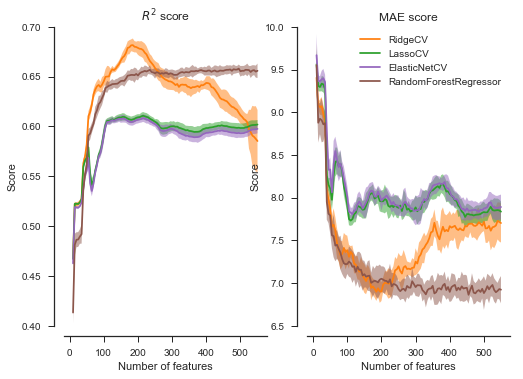

In [122]:
f, (ax1, ax2) = plt.subplots(1, 2)
for estimator in estimators:
    estimator_name = estimator.__class__.__name__
    k = np.arange(n_features_range[0], n_features_range[1], n_features_range[2], dtype=int)
    
    ax1.plot(k, mean_r2[estimator_name], label=estimator_name)
    ax1.fill_between(k, mean_r2[estimator_name] + std_r2[estimator_name],
                    mean_r2[estimator_name] - std_r2[estimator_name], alpha=0.5)
    ax1.set_title(r'$R^2$ score')
    ax1.set_xlabel('Number of features')
    ax1.set_ylabel('Score')
    
    ax2.plot(k, mean_mae[estimator_name], label=estimator_name)
    ax2.fill_between(k, mean_mae[estimator_name] + std_mae[estimator_name],
                    mean_mae[estimator_name] - std_mae[estimator_name], alpha=0.5)
    ax2.set_title('MAE score')
    ax2.set_xlabel('Number of features')
    ax2.set_ylabel('Score')
    ax2.legend()
    
    sns.despine(offset=10)
    ax1.set_ylim([0.4, 0.7])
    ax2.set_ylim([6.5, 10.])

In [126]:
k = np.arange(n_features_range[0], n_features_range[1], n_features_range[2], dtype=int)
print('Maximum R2 with Ridge using {} feature'.format(k[mean_r2['RidgeCV'].argmax()]))
print('Maximum R2 with Random Forest using {} feature'.format(k[mean_r2['RandomForestRegressor'].argmax()]))

print('Maximum MAE with Ridge using {} feature'.format(k[mean_mae['RidgeCV'].argmin()]))
print('Maximum MAE with Random Forest using {} feature'.format(k[mean_mae['RandomForestRegressor'].argmin()]))

Maximum R2 with Ridge using 185 feature
Maximum R2 with Random Forest using 495 feature
Maximum MAE with Ridge using 185 feature
Maximum MAE with Random Forest using 455 feature


##### Analysis

The best performance can be reached with 185 features. After this point, Ridge performance are deacreasing and the performance of Random Forest are stable. It means that the trees are probably not using any of the additional features added. The next experiments: (i) check what are these 185 features and (ii) check a selection on feature based on features importance when using the Random Forest.

R2 score: 0.6872499128007612
Median absolute deviation score: 6.98629643562785


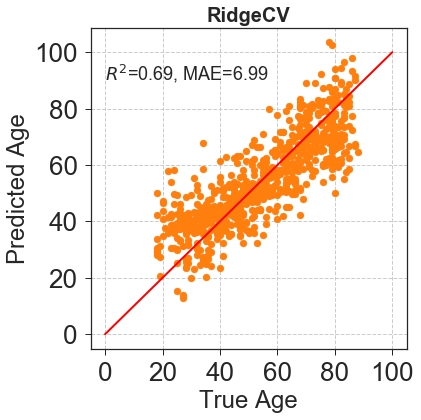

In [129]:
pipeline = make_pipeline(SelectKBest(f_regression, k=185), RidgeCV())
y_pred = cross_val_predict(pipeline, X, y, cv=KFold(n_splits=10, shuffle=True,
                                                    random_state=0))

print('R2 score: {}'.format(r2_score(y, y_pred)))
print('Median absolute deviation score: {}'.format(median_absolute_error(y, y_pred)))
plot_results(y, y_pred, 'RidgeCV')

#### Analysis of the selected features

In [141]:
feature_selected_idx = np.zeros(X.shape[1])
kf = KFold(n_splits=10, random_state=0, shuffle=True)
for train_index, _ in kf.split(X):
    X_train, y_train = X[train_index], y[train_index]
    selector = SelectKBest(f_regression, k=185)
    selector.fit(X_train, y_train)
    feature_selected_idx[selector.get_support()] += 1

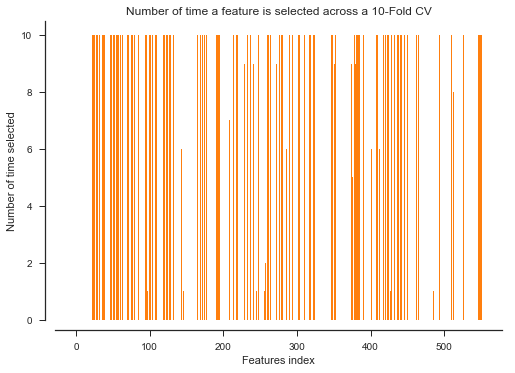

In [145]:
plt.bar(range(X.shape[1]), feature_selected_idx)
plt.xlabel('Features index')
plt.ylabel('Number of time selected')
plt.title('Number of time a feature is selected across a 10-Fold CV')
sns.despine(offset=10)

In [150]:
final_features_idx = feature_selected_idx > 5
print('{} selected features'.format(np.count_nonzero(final_features_idx)))

186 selected features


In [152]:
print('The selected columns are: \n {}'.format(column_names[final_features_idx].tolist()))

The selected columns are: 
 ['RTmean_all', 'RTmedian_all', 'RTsd_all', 'RTcv_all', 'RTtrim3mean_all', 'RTtrim3median_all', 'RTtrim3sd_all', 'RTtrim3cv_all', 'invRTmean_all', 'invRTmedian_all', 'invRTcv_all', 'invRTtrim3mean_all', 'invRTtrim3median_all', 'invRTtrim3cv_all', 'RTmean_73', 'RTmedian_73', 'RTsd_73', 'RTtrim3mean_73', 'RTtrim3median_73', 'RTtrim3sd_73', 'invRTmean_73', 'invRTmedian_73', 'invRTcv_73', 'invRTtrim3mean_73', 'invRTtrim3median_73', 'invRTtrim3cv_73', 'RTmean_79', 'RTmedian_79', 'RTsd_79', 'RTtrim3mean_79', 'RTtrim3median_79', 'RTtrim3sd_79', 'invRTmean_79', 'invRTmedian_79', 'invRTtrim3mean_79', 'invRTtrim3median_79', 'RTmean_85', 'RTmedian_85', 'RTsd_85', 'RTtrim3mean_85', 'RTtrim3median_85', 'RTtrim3sd_85', 'RTtrim3cv_85', 'invRTmean_85', 'invRTmedian_85', 'invRTcv_85', 'invRTtrim3mean_85', 'invRTtrim3median_85', 'invRTtrim3cv_85', 'RTmean_59', 'RTmedian_59', 'RTsd_59', 'RTtrim3mean_59', 'RTtrim3median_59', 'RTtrim3sd_59', 'invRTmean_59', 'invRTmedian_59', 'inv

#### Analysis using feature importance

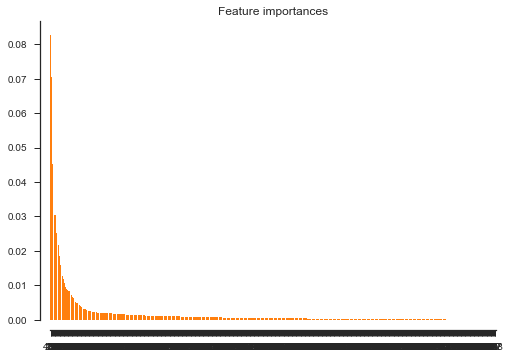

In [173]:
forest = RandomForestRegressor(n_estimators=50, random_state=0, n_jobs=-1)
forest.fit(X, y)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
sns.despine(offset=10)

In [202]:
def n_features_to_importances(k, importances, min_increment=0.0001):
    threshold = 0
    n_features = importances.size
    while n_features > k:
        threshold += min_increment
        n_features = np.count_nonzero(importances >= threshold)
        
    return threshold

In [205]:
memory = Memory(cachedir='/home/glemaitre/cache', verbose=0)
cv = KFold(shuffle=True, random_state=0)
pipeline = Pipeline(memory=memory,
                        steps=[('selectfrommodel', SelectFromModel(
                            RandomForestRegressor(n_estimators=50,
                            n_jobs=-1,
                            random_state=0))),
                               ('clf', RandomForestRegressor(n_estimators=50,
                                                             n_jobs=-1,
                                                             random_state=0))])

n_features = np.arange(10, X.shape[1], 5)
thresholds = [n_features_to_importances(k, importances) for k in n_features]

results_r2 = np.zeros((10, len(thresholds)))
results_mae = np.zeros((10, len(thresholds)))
for n_try in range(10):
    for threshold_index, threshold in enumerate(thresholds):
        pipeline.set_params(selectfrommodel__threshold=threshold)
        y_pred = cross_val_predict(pipeline, X, y, cv=KFold(n_splits=10, shuffle=True, random_state=n_try))
        results_r2[n_try, threshold_index] = r2_score(y, y_pred)
        results_mae[n_try, threshold_index] = median_absolute_error(y, y_pred)

(6.5, 8.0)

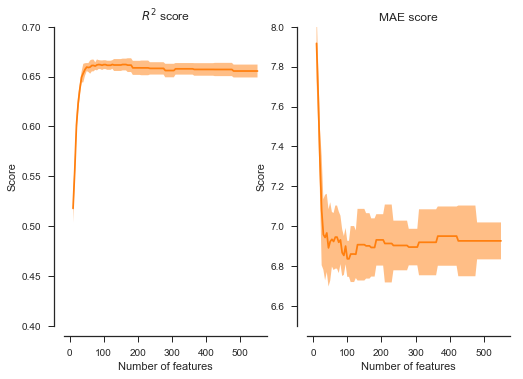

In [220]:
mean_r2 = np.mean(results_r2, axis=0)
mean_mae = np.mean(results_mae, axis=0)
std_r2 = np.std(results_r2, axis=0)
std_mae = np.std(results_mae, axis=0)

k = range(len(thresholds))

f, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(n_features[k], mean_r2, label=estimator_name)
ax1.fill_between(n_features[k], mean_r2 + std_r2, mean_r2 - std_r2, alpha=0.5)
ax1.set_title(r'$R^2$ score')
ax1.set_xlabel('Number of features')
ax1.set_ylabel('Score')
    
ax2.plot(n_features[k], mean_mae)
ax2.fill_between(n_features[k], mean_mae + std_mae, mean_mae - std_mae, alpha=0.5)
ax2.set_title('MAE score')
ax2.set_xlabel('Number of features')
ax2.set_ylabel('Score')
    
sns.despine(offset=10)
ax1.set_ylim([0.4, 0.7])
ax2.set_ylim([6.5, 8.])

In [218]:
print('Maximum R2 ({}) with Random Forest using a threshold of {} corresponding to {} features'.format(
    mean_r2.max(), thresholds[mean_r2.argmax()], n_features[mean_r2.argmax()]))
print('Maximum MAE ({}) with Random Forest using a threshold of {} corresponding to {} features'.format(
    mean_mae.min(), thresholds[mean_mae.argmin()], n_features[mean_mae.argmin()]))

Maximum R2 (0.6622031517439227) with Random Forest using a threshold of 0.0012000000000000003 corresponding to 125 features
Maximum MAE (6.836) with Random Forest using a threshold of 0.0014000000000000004 corresponding to 100 features


R2 score: 0.672947978128543
Median absolute deviation score: 6.719999999999999


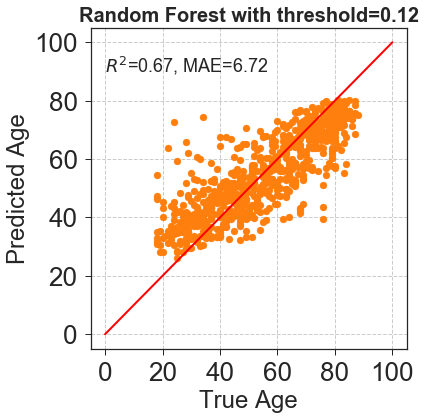

In [222]:
pipeline = make_pipeline(SelectFromModel(RandomForestRegressor(n_estimators=50, n_jobs=-1), threshold=0.0012),
                         RandomForestRegressor(n_estimators=50, n_jobs=-1))
y_pred = cross_val_predict(pipeline, X, y, cv=KFold(n_splits=10, shuffle=True,
                                                    random_state=0))

print('R2 score: {}'.format(r2_score(y, y_pred)))
print('Median absolute deviation score: {}'.format(median_absolute_error(y, y_pred)))
plot_results(y, y_pred, 'Random Forest with threshold of 0.0012')

R2 score: 0.6686081421301624
Median absolute deviation score: 6.740000000000002


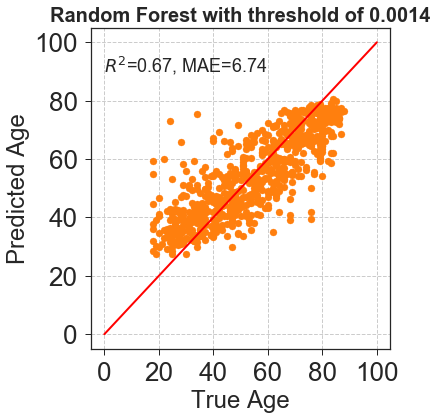

In [223]:
pipeline = make_pipeline(SelectFromModel(RandomForestRegressor(n_estimators=50, n_jobs=-1), threshold=0.0014),
                         RandomForestRegressor(n_estimators=50, n_jobs=-1))
y_pred = cross_val_predict(pipeline, X, y, cv=KFold(n_splits=10, shuffle=True,
                                                    random_state=0))

print('R2 score: {}'.format(r2_score(y, y_pred)))
print('Median absolute deviation score: {}'.format(median_absolute_error(y, y_pred)))
plot_results(y, y_pred, 'Random Forest with threshold of 0.0014')

### Analysis per experiment

This code can be used to observe the correlation between each feature in a cognitive behavioral experiment

In [154]:
experiment_name = "Hotel"
experiment_feature = load_camcan_behavioural_feature(path_exp_feat_map, experiment_name)
print('The number of features for this experiment is {}'.format(len(experiment_feature)))
dataset = load_camcan_behavioural(path_data, path_participants_info,
                                  column_selected=tuple(['Observations'] + list(experiment_feature)))

X = dataset.data
X = Imputer().fit_transform(X)
y = np.array(dataset.scores.age)
y = (np.floor(y / 10) * 10).astype(int)
X = np.hstack((X, np.atleast_2d(y).T))
X = pd.DataFrame(data=X, columns=list(experiment_feature) + ['age'])

The number of features for this experiment is 3


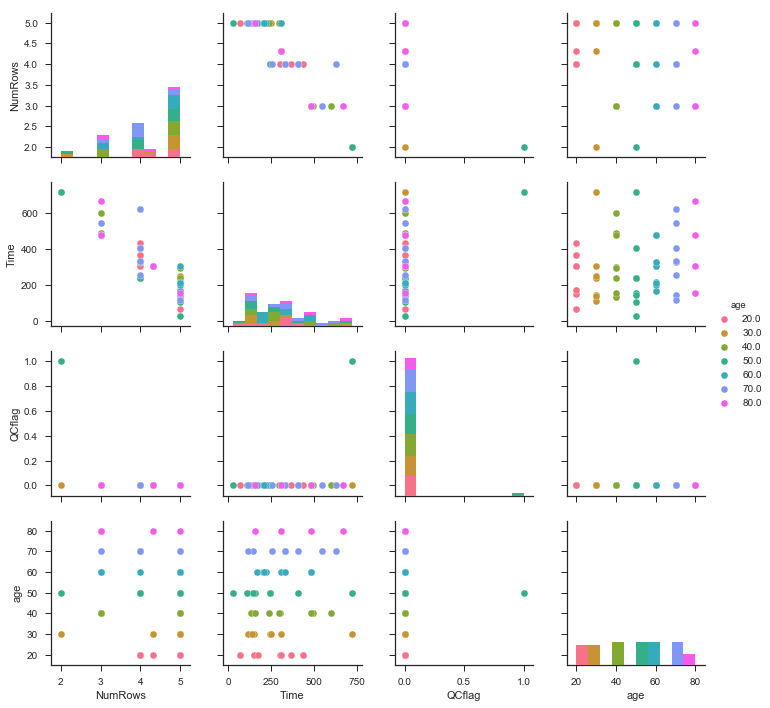

In [155]:
sns.pairplot(X.sample(50), hue='age')
plt.show()